In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
import os
os.getcwd()
os.chdir('C:\\')
path = 'F:\\Science\\MF Notebooks\\' # Шлях звідки зсчитувати та зберігати файли

In [39]:
from pyrqa.settings import JointSettings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import TaxicabMetric, EuclideanMetric, MaximumMetric
from pyrqa.computation import JRPComputation, JRQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.image_generator import ImageGenerator
from pyrqa.analysis_type import Classic

In [40]:
plt.style.use('classic')
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300

## Зчитування з Yahoo Finance

In [41]:
name_1 = "^GSPC"
data_1 = yf.download(name_1, start='2001-01-01')
time_ser_1 = data_1['Adj Close']
np.savetxt(path+f'{name_1}_initial_time_series.txt', time_ser_1.values)

[*********************100%***********************]  1 of 1 completed


In [42]:
name_2 = "^DJI"
data_2 = yf.download(name_2, start='2001-01-01')
time_ser_2 = data_2['Adj Close']
np.savetxt(path+f'{name_2}_initial_time_series.txt', time_ser_2.values)

[*********************100%***********************]  1 of 1 completed


## Зчитування з .txt файлів

In [ ]:
name_1 = "^GSPC_initial_time_series.txt" #назва файлу, що зчитуємо
with open(path+name_1, 'r') as f1: #зчитуємо файл
    time_ser_1 = [line.strip('\n') for line in f1.readlines()]
    time_ser_1 = [float(line) for line in time_ser_1 if line != '']
time_ser_1 = pd.Series(time_ser_1) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

In [ ]:
name_2 = "^DJI_initial_time_series.txt" #назва файлу, що зчитуємо
with open(path+name_2, 'r') as f2: #зчитуємо файл
    time_ser_2 = [line.strip('\n') for line in f2.readlines()]
    time_ser_2 = [float(line) for line in time_ser_2 if line != '']
time_ser_2 = pd.Series(time_ser_2)

## Виведення графіків досліджуваних рядів

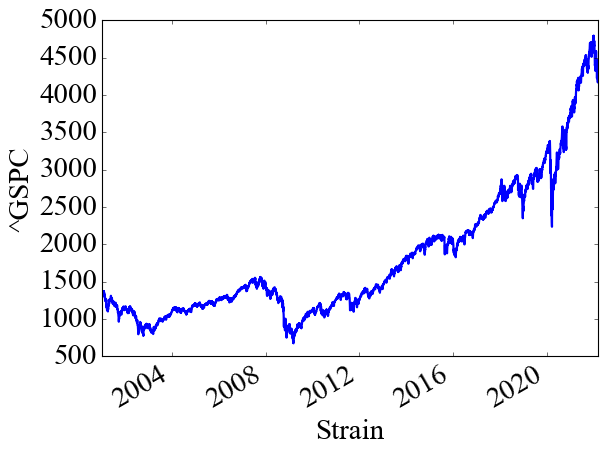

In [43]:
time_ser_1.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_1.split('.')[0]}")
plt.savefig(path+f'{name_1}.jpg', bbox_inches="tight")
plt.show()

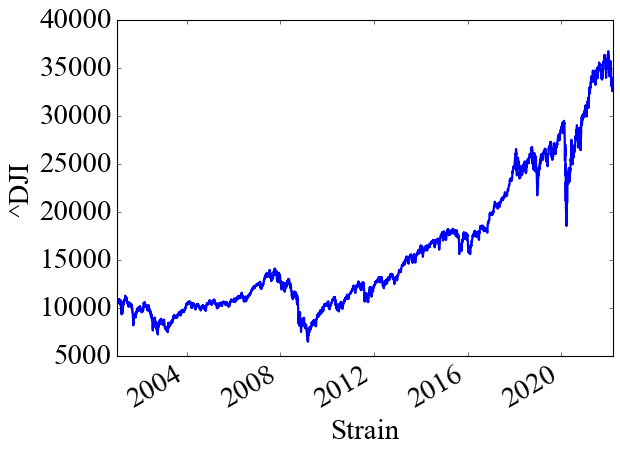

In [44]:
time_ser_2.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_2.split('.')[0]}")
plt.savefig(path+f'{name_2}.jpg', bbox_inches="tight")
plt.show()

## Побудова рекурентної карти всього часового ряду

In [45]:
for_rec_1 = time_ser_1.copy()
for_rec_2 = time_ser_2.copy()

ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 
                        # 4 - стандартизовані прибутковості, 
                        # 5 - абсолютні значення (волатильності)
                        # 6 - стандартизований ряд


if ret_type == 1:
    pass

elif ret_type == 2:
    for_rec_1 = for_rec_1.diff()
    for_rec_2 = for_rec_2.diff()
    
elif ret_type == 3:
    for_rec_1 = for_rec_1.pct_change()
    for_rec_2 = for_rec_2.pct_change()
    
elif ret_type == 4:
    for_rec_1 = for_rec_1.pct_change()
    for_rec_1 -= for_rec_1.mean()
    for_rec_1 /= for_rec_1.std()
    
    for_rec_2 = for_rec_2.pct_change()
    for_rec_2 -= for_rec_2.mean()
    for_rec_2 /= for_rec_2.std()
    
elif ret_type == 5: 
    for_rec_1 = for_rec_1.pct_change()
    for_rec_1 -= for_rec_1.mean()
    for_rec_1 /= for_rec_1.std()
    for_rec_1 = for_rec_1.abs()
    
    for_rec_2 = for_rec_2.pct_change()
    for_rec_2 -= for_rec_2.mean()
    for_rec_2 /= for_rec_2.std()
    for_rec_2 = for_rec_2.abs()
    
elif ret_type == 6:
    for_rec_1 -= for_rec_1.mean()
    for_rec_1 /= for_rec_1.std()
    
    for_rec_2 -= for_rec_2.mean()
    for_rec_2 /= for_rec_2.std()

for_rec_1 = for_rec_1.dropna().values
for_rec_2 = for_rec_2.dropna().values

In [51]:
d_e_1 = 1 # розмірність вкладень першого ряду
tau_1 = 1 # часова затримка першого ряду
theiler_wind_1 = 1 # вікно Тейлера
sim_measure_1 = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps_1 = 0.3 # радіус

d_e_2 = 1 # розмірність вкладень другого ряду
tau_2 = 1 # часова затримка другого ряду 
theiler_wind_2 = 1 # вікно Тейлера
sim_measure_2 = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps_2 = 0.3 # радіус


In [52]:
whole_series_1 = TimeSeries(for_rec_1,
                         embedding_dimension=d_e_1,
                         time_delay=tau_1)

whole_series_2 = TimeSeries(for_rec_2,
                         embedding_dimension=d_e_2,
                         time_delay=tau_2)

settings_1 = Settings(whole_series_1,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(eps_1),
                    similarity_measure=sim_measure_1,
                    theiler_corrector=theiler_wind_1)

settings_2 = Settings(whole_series_2,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(eps_2),
                    similarity_measure=sim_measure_2,
                    theiler_corrector=theiler_wind_2)

joint_settings = JointSettings(settings_1, settings_2)

In [53]:
jrqa_computation = JRPComputation.create(joint_settings)
jrqa_result = jrqa_computation.run()

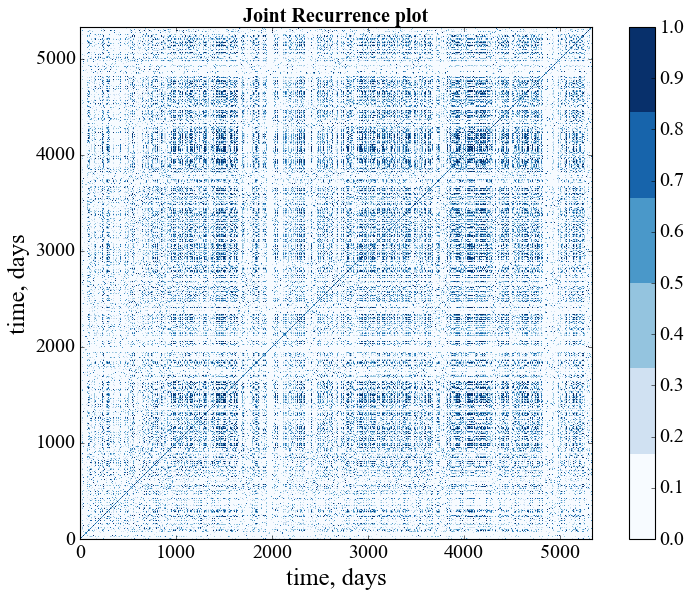

In [54]:
title = "Joint Recurrence plot" # підпис титульний
title_axes = "time, days" #підпис по осям

plt.rcParams['font.size'] = '18' 
fig, ax = plt.subplots(figsize=(12, 8))

rp = ax.imshow(jrqa_result.recurrence_matrix, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar(rp, ax=ax)
plt.gca().invert_yaxis()
ax.set_title(title, fontweight="bold", size=18)
ax.set_xlabel(title_axes, fontsize=22)
ax.set_ylabel(title_axes, fontsize=22)
plt.savefig(path+f'jrp_{name_1}_{name_2}.jpg')
plt.show()

### Віконна процедура

In [55]:
ret_type = 4
window = 100
tstep = 1
length = len(time_ser_1)

d_e_1 = 1 # розмірність вкладень першого ряду
tau_1 = 1 # часова затримка першого ряду
theiler_wind_1 = 1 # вікно Тейлера
sim_measure_1 = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps_1 = 0.3 # радіус

d_e_2 = 1 # розмірність вкладень другого ряду
tau_2 = 1 # часова затримка другого ряду 
theiler_wind_2 = 1 # вікно Тейлера
sim_measure_2 = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps_2 = 0.3 # радіус

RR = []
DET = []
DIV = []
AVG_DIAG_LINE = []
ENT_DIAG = []
LAM = []
TT = []
ENT_VERT = []
ENT_WHITE_VERT = []
AVG_VERT_LINE = []
VERT_DIV = []
RATIO_DET_REC = []
RATIO_LAM_DET = []

In [56]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window].copy() #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    fragm_2 = time_ser_2.iloc[i:i+window].copy()
    
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
        fragm_2 = fragm_2.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
        fragm_2 = fragm_2.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        
        fragm_2 = fragm_2.pct_change()
        fragm_2 -= fragm_2.mean()
        fragm_2 /= fragm_2.std()
    elif ret_type == 5: 
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()

        fragm_2 = fragm_2.pct_change()
        fragm_2 -= fragm_2.mean()
        fragm_2 /= fragm_2.std()
        fragm_2 = fragm_2.abs()
    elif ret_type == 6:
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()

        fragm_2 -= fragm_2.mean()
        fragm_2 /= fragm_2.std()

    fragm_1 = fragm_1.dropna().values
    fragm_2 = fragm_2.dropna().values
    
    whole_series_1 = TimeSeries(fragm_1,
                         embedding_dimension=d_e_1,
                         time_delay=tau_1)

    whole_series_2 = TimeSeries(fragm_1,
                             embedding_dimension=d_e_2,
                             time_delay=tau_2)

    settings_1 = Settings(whole_series_1,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(eps_1),
                        similarity_measure=sim_measure_1,
                        theiler_corrector=theiler_wind_1)

    settings_2 = Settings(whole_series_2,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(eps_2),
                        similarity_measure=sim_measure_2,
                        theiler_corrector=theiler_wind_2)
    
    joint_settings = JointSettings(settings_1, settings_2)

    jrqa_computation = JRQAComputation.create(joint_settings)
    JRQA_result = jrqa_computation.run()
    print(JRQA_result)
    
    RR.append(JRQA_result.recurrence_rate)
    DET.append(JRQA_result.determinism)
    DIV.append(JRQA_result.divergence)
    AVG_DIAG_LINE.append(JRQA_result.average_diagonal_line)
    ENT_DIAG.append(JRQA_result.entropy_diagonal_lines)
    LAM.append(JRQA_result.laminarity)
    TT.append(JRQA_result.trapping_time)
    ENT_VERT.append(JRQA_result.entropy_vertical_lines)
    ENT_WHITE_VERT.append(JRQA_result.entropy_white_vertical_lines)
    AVG_VERT_LINE.append(JRQA_result.average_white_vertical_line)
    VERT_DIV.append(1./JRQA_result.longest_vertical_line)
    RATIO_DET_REC.append(JRQA_result.ratio_determinism_recurrence_rate)
    RATIO_LAM_DET.append(JRQA_result.ratio_laminarity_determinism)

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.320946
Average diagonal line length (L): 2.244094
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.606561
Laminarity (LAM): 0.370667
Trapping time (TT): 2.332215
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.739526
Average white vertical line length (W): 6.386306
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.371654

Ratio determinism / recurrence rate (DET/RR): 1.677649
Ratio laminarity / determinism (LAM/DET): 1.154919

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184165
Determinism (DET): 0.3188

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.298561
Average diagonal line length (L): 2.165217
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.467440
Laminarity (LAM): 0.365591
Trapping time (TT): 2.340580
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.754534
Average white vertical line length (W): 6.806878
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.498954

Ratio determinism / recurrence rate (DET/RR): 1.656026
Ratio laminarity / determinism (LAM/DET): 1.224511

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180696
Determinism (DET): 0.3026

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182124
Determinism (DET): 0.316726
Average diagonal line length (L): 2.225000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.569817
Laminarity (LAM): 0.401120
Trapping time (TT): 2.394649
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.819397
Average white vertical line length (W): 7.016393
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.528433

Ratio determinism / recurrence rate (DET/RR): 1.739065
Ratio laminarity / determinism (LAM/DET): 1.266459

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.3129

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179880
Determinism (DET): 0.298077
Average diagonal line length (L): 2.296296
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.688033
Laminarity (LAM): 0.336926
Trapping time (TT): 2.444444
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.880923
Average white vertical line length (W): 6.925158
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.480892

Ratio determinism / recurrence rate (DET/RR): 1.657091
Ratio laminarity / determinism (LAM/DET): 1.130331

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178655
Determinism (DET): 0.2929

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.282742
Average diagonal line length (L): 2.287129
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.674198
Laminarity (LAM): 0.324293
Trapping time (TT): 2.381356
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.802575
Average white vertical line length (W): 6.802111
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.522206

Ratio determinism / recurrence rate (DET/RR): 1.599049
Ratio laminarity / determinism (LAM/DET): 1.146959

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177431
Determinism (DET): 0.2902

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.286041
Average diagonal line length (L): 2.252252
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.626661
Laminarity (LAM): 0.356253
Trapping time (TT): 2.392727
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.810107
Average white vertical line length (W): 6.560554
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.497896

Ratio determinism / recurrence rate (DET/RR): 1.517861
Ratio laminarity / determinism (LAM/DET): 1.245462

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186818
Determinism (DET): 0.2840

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176615
Determinism (DET): 0.278186
Average diagonal line length (L): 2.161905
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.466213
Laminarity (LAM): 0.354708
Trapping time (TT): 2.316981
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.699629
Average white vertical line length (W): 6.806140
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.536439

Ratio determinism / recurrence rate (DET/RR): 1.575103
Ratio laminarity / determinism (LAM/DET): 1.275075

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.2778

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.310148
Average diagonal line length (L): 2.211382
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.550755
Laminarity (LAM): 0.385861
Trapping time (TT): 2.359736
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.765600
Average white vertical line length (W): 6.597391
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.499166

Ratio determinism / recurrence rate (DET/RR): 1.640455
Ratio laminarity / determinism (LAM/DET): 1.244117

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189470
Determinism (DET): 0.3185

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183757
Determinism (DET): 0.296122
Average diagonal line length (L): 2.191304
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.516767
Laminarity (LAM): 0.342032
Trapping time (TT): 2.231884
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.551263
Average white vertical line length (W): 6.421273
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.477203

Ratio determinism / recurrence rate (DET/RR): 1.611490
Ratio laminarity / determinism (LAM/DET): 1.155037

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185593
Determinism (DET): 0.2848

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.268065
Average diagonal line length (L): 2.149533
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.441643
Laminarity (LAM): 0.319559
Trapping time (TT): 2.172285
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.465410
Average white vertical line length (W): 6.177134
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.435419

Ratio determinism / recurrence rate (DET/RR): 1.447552
Ratio laminarity / determinism (LAM/DET): 1.192095

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184573
Determinism (DET): 0.2783

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.281564
Average diagonal line length (L): 2.210526
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.552196
Laminarity (LAM): 0.353626
Trapping time (TT): 2.343860
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.754372
Average white vertical line length (W): 6.271973
Longest white vertical line length (W_max): 59
Longest white vertical line length inverse (W_div): 0.016949
Entropy white vertical lines (W_entr): 2.435102

Ratio determinism / recurrence rate (DET/RR): 1.460885
Ratio laminarity / determinism (LAM/DET): 1.255935

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191511
Determinism (DET): 0.2902

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.290210
Average diagonal line length (L): 2.184211
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.507304
Laminarity (LAM): 0.336088
Trapping time (TT): 2.310606
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.707854
Average white vertical line length (W): 6.080569
Longest white vertical line length (W_max): 56
Longest white vertical line length inverse (W_div): 0.017857
Entropy white vertical lines (W_entr): 2.367679

Ratio determinism / recurrence rate (DET/RR): 1.567133
Ratio laminarity / determinism (LAM/DET): 1.158087

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187838
Determinism (DET): 0.2778

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193144
Determinism (DET): 0.279822
Average diagonal line length (L): 2.201754
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.538565
Laminarity (LAM): 0.356577
Trapping time (TT): 2.272727
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.647592
Average white vertical line length (W): 6.004732
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.333035

Ratio determinism / recurrence rate (DET/RR): 1.448775
Ratio laminarity / determinism (LAM/DET): 1.274301

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193348
Determinism (DET): 0.2917

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191511
Determinism (DET): 0.309336
Average diagonal line length (L): 2.148438
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.429242
Laminarity (LAM): 0.362280
Trapping time (TT): 2.411348
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.825040
Average white vertical line length (W): 6.269580
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.430950

Ratio determinism / recurrence rate (DET/RR): 1.615240
Ratio laminarity / determinism (LAM/DET): 1.171153

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190083
Determinism (DET): 0.3061

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196613
Determinism (DET): 0.323851
Average diagonal line length (L): 2.225564
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.580089
Laminarity (LAM): 0.435392
Trapping time (TT): 2.404011
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.812132
Average white vertical line length (W): 6.184853
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.381858

Ratio determinism / recurrence rate (DET/RR): 1.647154
Ratio laminarity / determinism (LAM/DET): 1.344419

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194980
Determinism (DET): 0.3167

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179471
Determinism (DET): 0.279518
Average diagonal line length (L): 2.230769
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.585783
Laminarity (LAM): 0.376350
Trapping time (TT): 2.290657
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.656349
Average white vertical line length (W): 6.537752
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.456985

Ratio determinism / recurrence rate (DET/RR): 1.557451
Ratio laminarity / determinism (LAM/DET): 1.346425

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177635
Determinism (DET): 0.2789

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171717
Determinism (DET): 0.266414
Average diagonal line length (L): 2.221053
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.567702
Laminarity (LAM): 0.412359
Trapping time (TT): 2.352542
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.724234
Average white vertical line length (W): 7.009769
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.566101

Ratio determinism / recurrence rate (DET/RR): 1.551471
Ratio laminarity / determinism (LAM/DET): 1.547812

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.2622

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171717
Determinism (DET): 0.271465
Average diagonal line length (L): 2.239583
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.594117
Laminarity (LAM): 0.397504
Trapping time (TT): 2.339161
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.714114
Average white vertical line length (W): 7.193756
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.604058

Ratio determinism / recurrence rate (DET/RR): 1.580882
Ratio laminarity / determinism (LAM/DET): 1.464295

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.2711

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.287724
Average diagonal line length (L): 2.205882
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.545510
Laminarity (LAM): 0.372219
Trapping time (TT): 2.284133
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.596814
Average white vertical line length (W): 7.119349
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.620662

Ratio determinism / recurrence rate (DET/RR): 1.695719
Ratio laminarity / determinism (LAM/DET): 1.293667

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167636
Determinism (DET): 0.2901

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.269861
Average diagonal line length (L): 2.229167
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.583825
Laminarity (LAM): 0.411276
Trapping time (TT): 2.317726
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.625143
Average white vertical line length (W): 7.390566
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.642227

Ratio determinism / recurrence rate (DET/RR): 1.569680
Ratio laminarity / determinism (LAM/DET): 1.524027

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171105
Determinism (DET): 0.2801

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174982
Determinism (DET): 0.268564
Average diagonal line length (L): 2.237113
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.595441
Laminarity (LAM): 0.433819
Trapping time (TT): 2.361905
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.654506
Average white vertical line length (W): 7.183993
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.611063

Ratio determinism / recurrence rate (DET/RR): 1.534810
Ratio laminarity / determinism (LAM/DET): 1.615327

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175798
Determinism (DET): 0.2770

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176411
Determinism (DET): 0.268712
Average diagonal line length (L): 2.257732
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.616791
Laminarity (LAM): 0.451128
Trapping time (TT): 2.241379
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.564905
Average white vertical line length (W): 6.935626
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.589772

Ratio determinism / recurrence rate (DET/RR): 1.523217
Ratio laminarity / determinism (LAM/DET): 1.678855

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174574
Determinism (DET): 0.2741

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179471
Determinism (DET): 0.281928
Average diagonal line length (L): 2.186916
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.505985
Laminarity (LAM): 0.429790
Trapping time (TT): 2.263473
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.606073
Average white vertical line length (W): 6.737024
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.528934

Ratio determinism / recurrence rate (DET/RR): 1.570877
Ratio laminarity / determinism (LAM/DET): 1.524468

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179471
Determinism (DET): 0.2626

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.274251
Average diagonal line length (L): 2.180952
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.492961
Laminarity (LAM): 0.379876
Trapping time (TT): 2.285714
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.632306
Average white vertical line length (W): 6.618601
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.520140

Ratio determinism / recurrence rate (DET/RR): 1.519468
Ratio laminarity / determinism (LAM/DET): 1.385136

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181920
Determinism (DET): 0.2862

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184165
Determinism (DET): 0.304807
Average diagonal line length (L): 2.203390
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.541282
Laminarity (LAM): 0.423269
Trapping time (TT): 2.253687
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.605214
Average white vertical line length (W): 6.378401
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.428910

Ratio determinism / recurrence rate (DET/RR): 1.655074
Ratio laminarity / determinism (LAM/DET): 1.388647

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183553
Determinism (DET): 0.3000

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197429
Determinism (DET): 0.358388
Average diagonal line length (L): 2.222973
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.571697
Laminarity (LAM): 0.472868
Trapping time (TT): 2.352185
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.747550
Average white vertical line length (W): 6.374264
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.387374

Ratio determinism / recurrence rate (DET/RR): 1.815276
Ratio laminarity / determinism (LAM/DET): 1.319432

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196000
Determinism (DET): 0.3677

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184573
Determinism (DET): 0.329825
Average diagonal line length (L): 2.186047
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.511212
Laminarity (LAM): 0.433941
Trapping time (TT): 2.281977
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.637161
Average white vertical line length (W): 6.583333
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.445613

Ratio determinism / recurrence rate (DET/RR): 1.786960
Ratio laminarity / determinism (LAM/DET): 1.315673

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183553
Determinism (DET): 0.3211

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.297006
Average diagonal line length (L): 2.214286
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.561754
Laminarity (LAM): 0.448276
Trapping time (TT): 2.172603
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.482458
Average white vertical line length (W): 6.578151
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.474884

Ratio determinism / recurrence rate (DET/RR): 1.645537
Ratio laminarity / determinism (LAM/DET): 1.509316

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179880
Determinism (DET): 0.2992

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179063
Determinism (DET): 0.299517
Average diagonal line length (L): 2.214286
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.562710
Laminarity (LAM): 0.418234
Trapping time (TT): 2.127536
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.396452
Average white vertical line length (W): 6.549958
Longest white vertical line length (W_max): 52
Longest white vertical line length inverse (W_div): 0.019231
Entropy white vertical lines (W_entr): 2.471371

Ratio determinism / recurrence rate (DET/RR): 1.672687
Ratio laminarity / determinism (LAM/DET): 1.396361

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179063
Determinism (DET): 0.2874

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181716
Determinism (DET): 0.315101
Average diagonal line length (L): 2.226891
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.571576
Laminarity (LAM): 0.379001
Trapping time (TT): 2.163462
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.469206
Average white vertical line length (W): 6.636992
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.484680

Ratio determinism / recurrence rate (DET/RR): 1.734029
Ratio laminarity / determinism (LAM/DET): 1.202790

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.3073

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172737
Determinism (DET): 0.274780
Average diagonal line length (L): 2.126214
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.393321
Laminarity (LAM): 0.331955
Trapping time (TT): 2.128788
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.399095
Average white vertical line length (W): 6.804538
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.531403

Ratio determinism / recurrence rate (DET/RR): 1.590740
Ratio laminarity / determinism (LAM/DET): 1.208074

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172533
Determinism (DET): 0.2763

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172329
Determinism (DET): 0.275472
Average diagonal line length (L): 2.147059
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.435267
Laminarity (LAM): 0.338662
Trapping time (TT): 2.150376
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.441784
Average white vertical line length (W): 6.581590
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.499115

Ratio determinism / recurrence rate (DET/RR): 1.598519
Ratio laminarity / determinism (LAM/DET): 1.229389

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170697
Determinism (DET): 0.2795

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167024
Determinism (DET): 0.267880
Average diagonal line length (L): 2.168421
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.478555
Laminarity (LAM): 0.352474
Trapping time (TT): 2.121324
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.379800
Average white vertical line length (W): 6.919510
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.565287

Ratio determinism / recurrence rate (DET/RR): 1.603846
Ratio laminarity / determinism (LAM/DET): 1.315789

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166412
Determinism (DET): 0.2624

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166616
Determinism (DET): 0.279009
Average diagonal line length (L): 2.140000
Longest diagonal line length (L_max): 3
Divergence (DIV): 0.333333
Entropy diagonal lines (L_entr): 0.404963
Laminarity (LAM): 0.331904
Trapping time (TT): 2.117188
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.373351
Average white vertical line length (W): 6.747871
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.542569

Ratio determinism / recurrence rate (DET/RR): 1.674567
Ratio laminarity / determinism (LAM/DET): 1.189583

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167840
Determinism (DET): 0.2807

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168044
Determinism (DET): 0.279070
Average diagonal line length (L): 2.181818
Longest diagonal line length (L_max): 3
Divergence (DIV): 0.333333
Entropy diagonal lines (L_entr): 0.474139
Laminarity (LAM): 0.348512
Trapping time (TT): 2.110294
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.355377
Average white vertical line length (W): 6.935796
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.572380

Ratio determinism / recurrence rate (DET/RR): 1.660694
Ratio laminarity / determinism (LAM/DET): 1.248836

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168656
Determinism (DET): 0.2857

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167636
Determinism (DET): 0.284974
Average diagonal line length (L): 2.178218
Longest diagonal line length (L_max): 3
Divergence (DIV): 0.333333
Entropy diagonal lines (L_entr): 0.468680
Laminarity (LAM): 0.337797
Trapping time (TT): 2.185039
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.478949
Average white vertical line length (W): 6.868810
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.528546

Ratio determinism / recurrence rate (DET/RR): 1.699958
Ratio laminarity / determinism (LAM/DET): 1.185359

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167432
Determinism (DET): 0.2879

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.327366
Average diagonal line length (L): 2.206897
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.543498
Laminarity (LAM): 0.328322
Trapping time (TT): 2.256198
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.596288
Average white vertical line length (W): 6.772610
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.498509

Ratio determinism / recurrence rate (DET/RR): 1.929351
Ratio laminarity / determinism (LAM/DET): 1.002922

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.3260

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175390
Determinism (DET): 0.348148
Average diagonal line length (L): 2.220472
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.574448
Laminarity (LAM): 0.310646
Trapping time (TT): 2.215768
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.521499
Average white vertical line length (W): 6.235481
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.432346

Ratio determinism / recurrence rate (DET/RR): 1.984991
Ratio laminarity / determinism (LAM/DET): 0.892280

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174370
Determinism (DET): 0.3440

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171513
Determinism (DET): 0.357775
Average diagonal line length (L): 2.264000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.634120
Laminarity (LAM): 0.299227
Trapping time (TT): 2.245536
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.557377
Average white vertical line length (W): 6.541667
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.474031

Ratio determinism / recurrence rate (DET/RR): 2.085992
Ratio laminarity / determinism (LAM/DET): 0.836354

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.3556

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174166
Determinism (DET): 0.371891
Average diagonal line length (L): 2.248120
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.611301
Laminarity (LAM): 0.326303
Trapping time (TT): 2.264228
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.594166
Average white vertical line length (W): 6.490066
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.486352

Ratio determinism / recurrence rate (DET/RR): 2.135266
Ratio laminarity / determinism (LAM/DET): 0.877418

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174778
Determinism (DET): 0.3742

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176411
Determinism (DET): 0.377914
Average diagonal line length (L): 2.248175
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.606681
Laminarity (LAM): 0.261423
Trapping time (TT): 2.329897
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.656862
Average white vertical line length (W): 6.078416
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.407307

Ratio determinism / recurrence rate (DET/RR): 2.142242
Ratio laminarity / determinism (LAM/DET): 0.691752

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174166
Determinism (DET): 0.3805

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174574
Determinism (DET): 0.351117
Average diagonal line length (L): 2.210938
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.557912
Laminarity (LAM): 0.281122
Trapping time (TT): 2.279621
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.611996
Average white vertical line length (W): 6.209321
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.452767

Ratio determinism / recurrence rate (DET/RR): 2.011276
Ratio laminarity / determinism (LAM/DET): 0.800652

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175186
Determinism (DET): 0.3559

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.325347
Average diagonal line length (L): 2.263158
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.635756
Laminarity (LAM): 0.293769
Trapping time (TT): 2.229730
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.555523
Average white vertical line length (W): 6.490066
Longest white vertical line length (W_max): 57
Longest white vertical line length inverse (W_div): 0.017544
Entropy white vertical lines (W_entr): 2.485626

Ratio determinism / recurrence rate (DET/RR): 1.892418
Ratio laminarity / determinism (LAM/DET): 0.902940

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.3329

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170289
Determinism (DET): 0.296815
Average diagonal line length (L): 2.240385
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.601376
Laminarity (LAM): 0.275015
Trapping time (TT): 2.165094
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.448022
Average white vertical line length (W): 6.428922
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.483169

Ratio determinism / recurrence rate (DET/RR): 1.743012
Ratio laminarity / determinism (LAM/DET): 0.926553

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172737
Determinism (DET): 0.2948

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176207
Determinism (DET): 0.269042
Average diagonal line length (L): 2.190000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.517462
Laminarity (LAM): 0.270990
Trapping time (TT): 2.136986
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.399455
Average white vertical line length (W): 6.511824
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.504459

Ratio determinism / recurrence rate (DET/RR): 1.526855
Ratio laminarity / determinism (LAM/DET): 1.007242

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175594
Determinism (DET): 0.2675

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175390
Determinism (DET): 0.285185
Average diagonal line length (L): 2.242718
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.603753
Laminarity (LAM): 0.261780
Trapping time (TT): 2.122642
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.372155
Average white vertical line length (W): 6.438436
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.491088

Ratio determinism / recurrence rate (DET/RR): 1.626003
Ratio laminarity / determinism (LAM/DET): 0.917930

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177431
Determinism (DET): 0.2878

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172737
Determinism (DET): 0.282309
Average diagonal line length (L): 2.184466
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.507730
Laminarity (LAM): 0.251034
Trapping time (TT): 2.125000
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.376770
Average white vertical line length (W): 6.482068
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.498639

Ratio determinism / recurrence rate (DET/RR): 1.634322
Ratio laminarity / determinism (LAM/DET): 0.889217

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173554
Determinism (DET): 0.2808

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172329
Determinism (DET): 0.265409
Average diagonal line length (L): 2.175258
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.491395
Laminarity (LAM): 0.222025
Trapping time (TT): 2.118644
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.364215
Average white vertical line length (W): 6.678756
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.571608

Ratio determinism / recurrence rate (DET/RR): 1.540125
Ratio laminarity / determinism (LAM/DET): 0.836539

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172533
Determinism (DET): 0.2688

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172125
Determinism (DET): 0.278338
Average diagonal line length (L): 2.166667
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.471264
Laminarity (LAM): 0.241257
Trapping time (TT): 2.130890
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.388075
Average white vertical line length (W): 6.966455
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.600714

Ratio determinism / recurrence rate (DET/RR): 1.617064
Ratio laminarity / determinism (LAM/DET): 0.866777

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174370
Determinism (DET): 0.2832

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168044
Determinism (DET): 0.275194
Average diagonal line length (L): 2.151515
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.437495
Laminarity (LAM): 0.245902
Trapping time (TT): 2.098446
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.321654
Average white vertical line length (W): 7.147086
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.607814

Ratio determinism / recurrence rate (DET/RR): 1.637629
Ratio laminarity / determinism (LAM/DET): 0.893558

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168248
Determinism (DET): 0.2800

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172737
Determinism (DET): 0.303639
Average diagonal line length (L): 2.283019
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.657805
Laminarity (LAM): 0.253396
Trapping time (TT): 2.102941
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.331498
Average white vertical line length (W): 7.100093
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.602933

Ratio determinism / recurrence rate (DET/RR): 1.757804
Ratio laminarity / determinism (LAM/DET): 0.834533

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173554
Determinism (DET): 0.2921

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.281518
Average diagonal line length (L): 2.371134
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.753968
Laminarity (LAM): 0.246971
Trapping time (TT): 2.108374
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.343103
Average white vertical line length (W): 7.325875
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.636137

Ratio determinism / recurrence rate (DET/RR): 1.592127
Ratio laminarity / determinism (LAM/DET): 0.877282

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.2827

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.262295
Average diagonal line length (L): 2.337079
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.703995
Laminarity (LAM): 0.265875
Trapping time (TT): 2.083721
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.287764
Average white vertical line length (W): 7.182927
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.649825

Ratio determinism / recurrence rate (DET/RR): 1.525670
Ratio laminarity / determinism (LAM/DET): 1.013650

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.2622

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176615
Determinism (DET): 0.251225
Average diagonal line length (L): 2.329545
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.691259
Laminarity (LAM): 0.251878
Trapping time (TT): 2.096154
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.316549
Average white vertical line length (W): 7.217433
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.632515

Ratio determinism / recurrence rate (DET/RR): 1.422450
Ratio laminarity / determinism (LAM/DET): 1.002595

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.2558

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180696
Determinism (DET): 0.285885
Average diagonal line length (L): 2.276190
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.619207
Laminarity (LAM): 0.260870
Trapping time (TT): 2.090498
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.303688
Average white vertical line length (W): 6.831369
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.580716

Ratio determinism / recurrence rate (DET/RR): 1.582135
Ratio laminarity / determinism (LAM/DET): 0.912498

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.2910

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181308
Determinism (DET): 0.275328
Average diagonal line length (L): 2.264706
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.637954
Laminarity (LAM): 0.273495
Trapping time (TT): 2.103896
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.333560
Average white vertical line length (W): 7.008372
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.622172

Ratio determinism / recurrence rate (DET/RR): 1.518564
Ratio laminarity / determinism (LAM/DET): 0.993342

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178859
Determinism (DET): 0.2841

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.286445
Average diagonal line length (L): 2.309278
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.696377
Laminarity (LAM): 0.229104
Trapping time (TT): 2.059459
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.225478
Average white vertical line length (W): 7.021878
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.606265

Ratio determinism / recurrence rate (DET/RR): 1.688183
Ratio laminarity / determinism (LAM/DET): 0.799819

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170901
Determinism (DET): 0.2969

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168044
Determinism (DET): 0.280362
Average diagonal line length (L): 2.260417
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.628893
Laminarity (LAM): 0.218579
Trapping time (TT): 2.033898
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.148042
Average white vertical line length (W): 6.829956
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.554614

Ratio determinism / recurrence rate (DET/RR): 1.668382
Ratio laminarity / determinism (LAM/DET): 0.779633

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168656
Determinism (DET): 0.2805

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169064
Determinism (DET): 0.286264
Average diagonal line length (L): 2.207921
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.548978
Laminarity (LAM): 0.261316
Trapping time (TT): 2.197970
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.438514
Average white vertical line length (W): 7.004509
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.604426

Ratio determinism / recurrence rate (DET/RR): 1.693227
Ratio laminarity / determinism (LAM/DET): 0.912847

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171309
Determinism (DET): 0.2898

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166208
Determinism (DET): 0.311111
Average diagonal line length (L): 2.266667
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.640390
Laminarity (LAM): 0.300184
Trapping time (TT): 2.285047
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.649646
Average white vertical line length (W): 7.061995
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.586136

Ratio determinism / recurrence rate (DET/RR): 1.871823
Ratio laminarity / determinism (LAM/DET): 0.964878

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166412
Determinism (DET): 0.3041

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164983
Determinism (DET): 0.292490
Average diagonal line length (L): 2.312500
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.702919
Laminarity (LAM): 0.327149
Trapping time (TT): 2.300000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.669764
Average white vertical line length (W): 7.382160
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.611174

Ratio determinism / recurrence rate (DET/RR): 1.772848
Ratio laminarity / determinism (LAM/DET): 1.118496

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166003
Determinism (DET): 0.2879

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172329
Determinism (DET): 0.285535
Average diagonal line length (L): 2.292929
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.675414
Laminarity (LAM): 0.286560
Trapping time (TT): 2.293839
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.664900
Average white vertical line length (W): 6.898667
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.568772

Ratio determinism / recurrence rate (DET/RR): 1.656912
Ratio laminarity / determinism (LAM/DET): 1.003592

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172125
Determinism (DET): 0.2758

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170289
Determinism (DET): 0.280255
Average diagonal line length (L): 2.222222
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.568864
Laminarity (LAM): 0.346914
Trapping time (TT): 2.244186
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.588266
Average white vertical line length (W): 7.331767
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.653483

Ratio determinism / recurrence rate (DET/RR): 1.645762
Ratio laminarity / determinism (LAM/DET): 1.237853

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.2698

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169064
Determinism (DET): 0.290116
Average diagonal line length (L): 2.237624
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.596735
Laminarity (LAM): 0.336753
Trapping time (TT): 2.305785
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.688866
Average white vertical line length (W): 7.334897
Longest white vertical line length (W_max): 53
Longest white vertical line length inverse (W_div): 0.018868
Entropy white vertical lines (W_entr): 2.660834

Ratio determinism / recurrence rate (DET/RR): 1.716006
Ratio laminarity / determinism (LAM/DET): 1.160755

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171105
Determinism (DET): 0.2978

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174574
Determinism (DET): 0.310174
Average diagonal line length (L): 2.314815
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.706987
Laminarity (LAM): 0.363530
Trapping time (TT): 2.295203
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.673803
Average white vertical line length (W): 7.003604
Longest white vertical line length (W_max): 55
Longest white vertical line length inverse (W_div): 0.018182
Entropy white vertical lines (W_entr): 2.574171

Ratio determinism / recurrence rate (DET/RR): 1.776746
Ratio laminarity / determinism (LAM/DET): 1.172021

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.3108

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172125
Determinism (DET): 0.293451
Average diagonal line length (L): 2.330000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.719053
Laminarity (LAM): 0.377001
Trapping time (TT): 2.279570
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.655517
Average white vertical line length (W): 7.149404
Longest white vertical line length (W_max): 67
Longest white vertical line length inverse (W_div): 0.014925
Entropy white vertical lines (W_entr): 2.581596

Ratio determinism / recurrence rate (DET/RR): 1.704868
Ratio laminarity / determinism (LAM/DET): 1.284714

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174166
Determinism (DET): 0.2873

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179063
Determinism (DET): 0.297101
Average diagonal line length (L): 2.299065
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.697665
Laminarity (LAM): 0.347578
Trapping time (TT): 2.267658
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.596676
Average white vertical line length (W): 6.879249
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.494515

Ratio determinism / recurrence rate (DET/RR): 1.659197
Ratio laminarity / determinism (LAM/DET): 1.169898

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.2984

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184369
Determinism (DET): 0.296253
Average diagonal line length (L): 2.279279
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.657559
Laminarity (LAM): 0.303818
Trapping time (TT): 2.196000
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.516393
Average white vertical line length (W): 6.454699
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.425561

Ratio determinism / recurrence rate (DET/RR): 1.606848
Ratio laminarity / determinism (LAM/DET): 1.025537

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.3061

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183757
Determinism (DET): 0.286722
Average diagonal line length (L): 2.301887
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.689596
Laminarity (LAM): 0.280400
Trapping time (TT): 2.234513
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.571318
Average white vertical line length (W): 6.418290
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.394977

Ratio determinism / recurrence rate (DET/RR): 1.560332
Ratio laminarity / determinism (LAM/DET): 0.977952

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186614
Determinism (DET): 0.2763

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186614
Determinism (DET): 0.294798
Average diagonal line length (L): 2.361111
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.781878
Laminarity (LAM): 0.288136
Trapping time (TT): 2.242553
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.570456
Average white vertical line length (W): 6.580560
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.410610

Ratio determinism / recurrence rate (DET/RR): 1.579722
Ratio laminarity / determinism (LAM/DET): 0.977401

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187838
Determinism (DET): 0.2755

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.287879
Average diagonal line length (L): 2.330189
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.740311
Laminarity (LAM): 0.286501
Trapping time (TT): 2.212766
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.547878
Average white vertical line length (W): 6.461933
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.438655

Ratio determinism / recurrence rate (DET/RR): 1.554545
Ratio laminarity / determinism (LAM/DET): 0.995215

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187022
Determinism (DET): 0.2929

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184165
Determinism (DET): 0.296600
Average diagonal line length (L): 2.258929
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.629238
Laminarity (LAM): 0.255956
Trapping time (TT): 2.189573
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.516378
Average white vertical line length (W): 6.333611
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.429200

Ratio determinism / recurrence rate (DET/RR): 1.610515
Ratio laminarity / determinism (LAM/DET): 0.862965

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.2955

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185593
Determinism (DET): 0.289535
Average diagonal line length (L): 2.184211
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.507304
Laminarity (LAM): 0.317757
Trapping time (TT): 2.275591
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.638937
Average white vertical line length (W): 6.385260
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.450516

Ratio determinism / recurrence rate (DET/RR): 1.560050
Ratio laminarity / determinism (LAM/DET): 1.097474

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184981
Determinism (DET): 0.2940

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.289598
Average diagonal line length (L): 2.247706
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.600847
Laminarity (LAM): 0.329425
Trapping time (TT): 2.350598
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.749856
Average white vertical line length (W): 6.424875
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.440340

Ratio determinism / recurrence rate (DET/RR): 1.584786
Ratio laminarity / determinism (LAM/DET): 1.137524

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183145
Determinism (DET): 0.2936

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185797
Determinism (DET): 0.299652
Average diagonal line length (L): 2.243478
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.584140
Laminarity (LAM): 0.318506
Trapping time (TT): 2.338710
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.735310
Average white vertical line length (W): 6.163446
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.348531

Ratio determinism / recurrence rate (DET/RR): 1.612787
Ratio laminarity / determinism (LAM/DET): 1.062922

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186410
Determinism (DET): 0.2951

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186410
Determinism (DET): 0.306713
Average diagonal line length (L): 2.208333
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.536926
Laminarity (LAM): 0.355774
Trapping time (TT): 2.288732
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.667487
Average white vertical line length (W): 6.135350
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.330394

Ratio determinism / recurrence rate (DET/RR): 1.645372
Ratio laminarity / determinism (LAM/DET): 1.159959

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181512
Determinism (DET): 0.3059

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184369
Determinism (DET): 0.329040
Average diagonal line length (L): 2.161538
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.465159
Laminarity (LAM): 0.355838
Trapping time (TT): 2.355311
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.746931
Average white vertical line length (W): 6.249191
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.364766

Ratio determinism / recurrence rate (DET/RR): 1.784681
Ratio laminarity / determinism (LAM/DET): 1.081445

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.3263

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183553
Determinism (DET): 0.324706
Average diagonal line length (L): 2.173228
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.480099
Laminarity (LAM): 0.376876
Trapping time (TT): 2.321918
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.710637
Average white vertical line length (W): 6.360427
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.443449

Ratio determinism / recurrence rate (DET/RR): 1.769006
Ratio laminarity / determinism (LAM/DET): 1.160669

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181512
Determinism (DET): 0.3380

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184165
Determinism (DET): 0.330598
Average diagonal line length (L): 2.186047
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.508699
Laminarity (LAM): 0.375623
Trapping time (TT): 2.306122
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.671789
Average white vertical line length (W): 6.024710
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.379850

Ratio determinism / recurrence rate (DET/RR): 1.795119
Ratio laminarity / determinism (LAM/DET): 1.136194

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187838
Determinism (DET): 0.3375

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186818
Determinism (DET): 0.330254
Average diagonal line length (L): 2.217054
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.562794
Laminarity (LAM): 0.413981
Trapping time (TT): 2.296970
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.663684
Average white vertical line length (W): 6.233871
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.409086

Ratio determinism / recurrence rate (DET/RR): 1.767788
Ratio laminarity / determinism (LAM/DET): 1.253524

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.3249

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181716
Determinism (DET): 0.348395
Average diagonal line length (L): 2.236641
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.595211
Laminarity (LAM): 0.396407
Trapping time (TT): 2.292208
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.604117
Average white vertical line length (W): 6.356444
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.460076

Ratio determinism / recurrence rate (DET/RR): 1.917247
Ratio laminarity / determinism (LAM/DET): 1.137808

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183553
Determinism (DET): 0.3282

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.313631
Average diagonal line length (L): 2.203390
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.539893
Laminarity (LAM): 0.340922
Trapping time (TT): 2.235075
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.545336
Average white vertical line length (W): 6.256019
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.447524

Ratio determinism / recurrence rate (DET/RR): 1.749514
Ratio laminarity / determinism (LAM/DET): 1.087017

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.3053

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180900
Determinism (DET): 0.280765
Average diagonal line length (L): 2.196262
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.528855
Laminarity (LAM): 0.360970
Trapping time (TT): 2.191781
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.513152
Average white vertical line length (W): 6.241793
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.461972

Ratio determinism / recurrence rate (DET/RR): 1.552044
Ratio laminarity / determinism (LAM/DET): 1.285668

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180900
Determinism (DET): 0.2664

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177227
Determinism (DET): 0.288156
Average diagonal line length (L): 2.226415
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.583717
Laminarity (LAM): 0.321819
Trapping time (TT): 2.227092
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.575765
Average white vertical line length (W): 6.409728
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.481334

Ratio determinism / recurrence rate (DET/RR): 1.625918
Ratio laminarity / determinism (LAM/DET): 1.116822

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175594
Determinism (DET): 0.2799

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177227
Determinism (DET): 0.304029
Average diagonal line length (L): 2.203540
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.543163
Laminarity (LAM): 0.283247
Trapping time (TT): 2.167401
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.474747
Average white vertical line length (W): 6.370888
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.482431

Ratio determinism / recurrence rate (DET/RR): 1.715481
Ratio laminarity / determinism (LAM/DET): 0.931644

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175798
Determinism (DET): 0.3029

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.296029
Average diagonal line length (L): 2.196429
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.524781
Laminarity (LAM): 0.296422
Trapping time (TT): 2.330357
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.706008
Average white vertical line length (W): 6.434638
Longest white vertical line length (W_max): 59
Longest white vertical line length inverse (W_div): 0.016949
Entropy white vertical lines (W_entr): 2.499354

Ratio determinism / recurrence rate (DET/RR): 1.647575
Ratio laminarity / determinism (LAM/DET): 1.001330

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.2905

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179063
Determinism (DET): 0.300725
Average diagonal line length (L): 2.165217
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.467440
Laminarity (LAM): 0.294587
Trapping time (TT): 2.415888
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.847331
Average white vertical line length (W): 6.541206
Longest white vertical line length (W_max): 55
Longest white vertical line length inverse (W_div): 0.018182
Entropy white vertical lines (W_entr): 2.489838

Ratio determinism / recurrence rate (DET/RR): 1.679431
Ratio laminarity / determinism (LAM/DET): 0.979590

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.2949

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.303249
Average diagonal line length (L): 2.172414
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.479679
Laminarity (LAM): 0.314026
Trapping time (TT): 2.572093
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.976452
Average white vertical line length (W): 6.487866
Longest white vertical line length (W_max): 67
Longest white vertical line length inverse (W_div): 0.014925
Entropy white vertical lines (W_entr): 2.441278

Ratio determinism / recurrence rate (DET/RR): 1.687759
Ratio laminarity / determinism (LAM/DET): 1.035539

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.3032

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.312575
Average diagonal line length (L): 2.211864
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.555281
Laminarity (LAM): 0.297908
Trapping time (TT): 2.570732
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.981749
Average white vertical line length (W): 6.423940
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.441971

Ratio determinism / recurrence rate (DET/RR): 1.731795
Ratio laminarity / determinism (LAM/DET): 0.953079

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179471
Determinism (DET): 0.3120

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.299760
Average diagonal line length (L): 2.232143
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.581045
Laminarity (LAM): 0.302207
Trapping time (TT): 2.592233
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.941719
Average white vertical line length (W): 6.602058
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.485410

Ratio determinism / recurrence rate (DET/RR): 1.662677
Ratio laminarity / determinism (LAM/DET): 1.008163

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178859
Determinism (DET): 0.2998

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170697
Determinism (DET): 0.292249
Average diagonal line length (L): 2.211538
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.541714
Laminarity (LAM): 0.260610
Trapping time (TT): 2.610778
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.972306
Average white vertical line length (W): 6.555649
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.457349

Ratio determinism / recurrence rate (DET/RR): 1.712094
Ratio laminarity / determinism (LAM/DET): 0.891738

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169064
Determinism (DET): 0.2862

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170289
Determinism (DET): 0.275159
Average diagonal line length (L): 2.204082
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.531773
Laminarity (LAM): 0.273217
Trapping time (TT): 2.651163
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.040488
Average white vertical line length (W): 6.590301
Longest white vertical line length (W_max): 53
Longest white vertical line length inverse (W_div): 0.018868
Entropy white vertical lines (W_entr): 2.516633

Ratio determinism / recurrence rate (DET/RR): 1.615839
Ratio laminarity / determinism (LAM/DET): 0.992943

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.2749

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178247
Determinism (DET): 0.276699
Average diagonal line length (L): 2.192308
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.521106
Laminarity (LAM): 0.289067
Trapping time (TT): 2.715054
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.008673
Average white vertical line length (W): 6.518487
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.477526

Ratio determinism / recurrence rate (DET/RR): 1.552334
Ratio laminarity / determinism (LAM/DET): 1.044698

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.2822

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.280912
Average diagonal line length (L): 2.271845
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.633442
Laminarity (LAM): 0.309915
Trapping time (TT): 2.878947
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.071658
Average white vertical line length (W): 6.386885
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.453646

Ratio determinism / recurrence rate (DET/RR): 1.559899
Ratio laminarity / determinism (LAM/DET): 1.103244

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177635
Determinism (DET): 0.2813

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.288115
Average diagonal line length (L): 2.222222
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.555943
Laminarity (LAM): 0.255524
Trapping time (TT): 2.684524
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.831101
Average white vertical line length (W): 6.286992
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.408842

Ratio determinism / recurrence rate (DET/RR): 1.599897
Ratio laminarity / determinism (LAM/DET): 0.886881

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179880
Determinism (DET): 0.2932

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173554
Determinism (DET): 0.292135
Average diagonal line length (L): 2.228571
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.582426
Laminarity (LAM): 0.265726
Trapping time (TT): 2.597701
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.871592
Average white vertical line length (W): 6.614601
Longest white vertical line length (W_max): 66
Longest white vertical line length inverse (W_div): 0.015152
Entropy white vertical lines (W_entr): 2.469998

Ratio determinism / recurrence rate (DET/RR): 1.683253
Ratio laminarity / determinism (LAM/DET): 0.909601

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175186
Determinism (DET): 0.2904

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180696
Determinism (DET): 0.287081
Average diagonal line length (L): 2.222222
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.572348
Laminarity (LAM): 0.278938
Trapping time (TT): 2.507614
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.780143
Average white vertical line length (W): 6.472269
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.420710

Ratio determinism / recurrence rate (DET/RR): 1.588754
Ratio laminarity / determinism (LAM/DET): 0.971636

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178859
Determinism (DET): 0.2853

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184981
Determinism (DET): 0.315053
Average diagonal line length (L): 2.213115
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.557391
Laminarity (LAM): 0.280199
Trapping time (TT): 2.396226
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.655535
Average white vertical line length (W): 6.171360
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.338442

Ratio determinism / recurrence rate (DET/RR): 1.703160
Ratio laminarity / determinism (LAM/DET): 0.889371

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183757
Determinism (DET): 0.3102

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188654
Determinism (DET): 0.317714
Average diagonal line length (L): 2.188976
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.508249
Laminarity (LAM): 0.311520
Trapping time (TT): 2.360656
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.626888
Average white vertical line length (W): 6.195599
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.364514

Ratio determinism / recurrence rate (DET/RR): 1.684109
Ratio laminarity / determinism (LAM/DET): 0.980503

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.3169

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193348
Determinism (DET): 0.340757
Average diagonal line length (L): 2.201439
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.535263
Laminarity (LAM): 0.293404
Trapping time (TT): 2.336134
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.551412
Average white vertical line length (W): 6.001596
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.339975

Ratio determinism / recurrence rate (DET/RR): 1.762407
Ratio laminarity / determinism (LAM/DET): 0.861034

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.3463

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187838
Determinism (DET): 0.354765
Average diagonal line length (L): 2.191489
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.516650
Laminarity (LAM): 0.279196
Trapping time (TT): 2.132780
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.280021
Average white vertical line length (W): 5.919317
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.312454

Ratio determinism / recurrence rate (DET/RR): 1.888674
Ratio laminarity / determinism (LAM/DET): 0.786990

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.3613

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181104
Determinism (DET): 0.355609
Average diagonal line length (L): 2.257576
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.632655
Laminarity (LAM): 0.276056
Trapping time (TT): 2.130435
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.353655
Average white vertical line length (W): 5.988354
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.364264

Ratio determinism / recurrence rate (DET/RR): 1.963560
Ratio laminarity / determinism (LAM/DET): 0.776293

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.3513

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175594
Determinism (DET): 0.334155
Average diagonal line length (L): 2.203252
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.530133
Laminarity (LAM): 0.272516
Trapping time (TT): 2.131818
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.351524
Average white vertical line length (W): 6.116771
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.413897

Ratio determinism / recurrence rate (DET/RR): 1.902996
Ratio laminarity / determinism (LAM/DET): 0.815537

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176615
Determinism (DET): 0.3174

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.338673
Average diagonal line length (L): 2.242424
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.601741
Laminarity (LAM): 0.312398
Trapping time (TT): 2.053381
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.208352
Average white vertical line length (W): 5.770566
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.337068

Ratio determinism / recurrence rate (DET/RR): 1.797148
Ratio laminarity / determinism (LAM/DET): 0.922420

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190899
Determinism (DET): 0.3374

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187634
Determinism (DET): 0.331034
Average diagonal line length (L): 2.232558
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.579044
Laminarity (LAM): 0.321914
Trapping time (TT): 2.106762
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.339691
Average white vertical line length (W): 5.819286
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.360084

Ratio determinism / recurrence rate (DET/RR): 1.764257
Ratio laminarity / determinism (LAM/DET): 0.972449

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.3318

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182328
Determinism (DET): 0.343602
Average diagonal line length (L): 2.230769
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.586617
Laminarity (LAM): 0.330162
Trapping time (TT): 2.129964
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.386318
Average white vertical line length (W): 5.919908
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.367659

Ratio determinism / recurrence rate (DET/RR): 1.884523
Ratio laminarity / determinism (LAM/DET): 0.960886

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.3384

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.349340
Average diagonal line length (L): 2.273438
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.654115
Laminarity (LAM): 0.316714
Trapping time (TT): 2.200787
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.501492
Average white vertical line length (W): 6.064692
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.405402

Ratio determinism / recurrence rate (DET/RR): 1.939875
Ratio laminarity / determinism (LAM/DET): 0.906607

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181104
Determinism (DET): 0.3448

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185797
Determinism (DET): 0.313589
Average diagonal line length (L): 2.327586
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.730130
Laminarity (LAM): 0.318506
Trapping time (TT): 2.239382
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.550367
Average white vertical line length (W): 5.991446
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.382100

Ratio determinism / recurrence rate (DET/RR): 1.687800
Ratio laminarity / determinism (LAM/DET): 1.015681

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183145
Determinism (DET): 0.3030

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182941
Determinism (DET): 0.303424
Average diagonal line length (L): 2.357798
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.763433
Laminarity (LAM): 0.331288
Trapping time (TT): 2.284615
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.597260
Average white vertical line length (W): 6.059421
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.374967

Ratio determinism / recurrence rate (DET/RR): 1.658593
Ratio laminarity / determinism (LAM/DET): 1.091834

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183349
Determinism (DET): 0.2956

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.328341
Average diagonal line length (L): 2.317073
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.710366
Laminarity (LAM): 0.361308
Trapping time (TT): 2.255102
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.582214
Average white vertical line length (W): 6.072327
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.386499

Ratio determinism / recurrence rate (DET/RR): 1.753717
Ratio laminarity / determinism (LAM/DET): 1.100404

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.3341

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187634
Determinism (DET): 0.328736
Average diagonal line length (L): 2.269841
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.642115
Laminarity (LAM): 0.343665
Trapping time (TT): 2.306569
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.668665
Average white vertical line length (W): 6.313223
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.426247

Ratio determinism / recurrence rate (DET/RR): 1.752005
Ratio laminarity / determinism (LAM/DET): 1.045415

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.3283

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181716
Determinism (DET): 0.325803
Average diagonal line length (L): 2.192000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.519734
Laminarity (LAM): 0.312184
Trapping time (TT): 2.251012
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.597783
Average white vertical line length (W): 6.173982
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.391966

Ratio determinism / recurrence rate (DET/RR): 1.792921
Ratio laminarity / determinism (LAM/DET): 0.958200

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182124
Determinism (DET): 0.3202

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178451
Determinism (DET): 0.300606
Average diagonal line length (L): 2.214286
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.558578
Laminarity (LAM): 0.301315
Trapping time (TT): 2.142276
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.427202
Average white vertical line length (W): 6.218051
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.403121

Ratio determinism / recurrence rate (DET/RR): 1.684528
Ratio laminarity / determinism (LAM/DET): 1.002358

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.3208

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.336384
Average diagonal line length (L): 2.279070
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.644856
Laminarity (LAM): 0.342177
Trapping time (TT): 2.120805
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.376931
Average white vertical line length (W): 6.089243
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.348591

Ratio determinism / recurrence rate (DET/RR): 1.785005
Ratio laminarity / determinism (LAM/DET): 1.017219

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189266
Determinism (DET): 0.3485

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197225
Determinism (DET): 0.330425
Average diagonal line length (L): 2.295455
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.678265
Laminarity (LAM): 0.375582
Trapping time (TT): 2.167164
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.467179
Average white vertical line length (W): 5.902745
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.301027

Ratio determinism / recurrence rate (DET/RR): 1.675374
Ratio laminarity / determinism (LAM/DET): 1.136662

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198857
Determinism (DET): 0.3329

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203959
Determinism (DET): 0.326316
Average diagonal line length (L): 2.262774
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.621773
Laminarity (LAM): 0.424712
Trapping time (TT): 2.210938
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.515196
Average white vertical line length (W): 6.139554
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.363007

Ratio determinism / recurrence rate (DET/RR): 1.599910
Ratio laminarity / determinism (LAM/DET): 1.301538

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204367
Determinism (DET): 0.3361

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208652
Determinism (DET): 0.357657
Average diagonal line length (L): 2.245161
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.607234
Laminarity (LAM): 0.442054
Trapping time (TT): 2.243176
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.551212
Average white vertical line length (W): 5.907200
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.316174

Ratio determinism / recurrence rate (DET/RR): 1.714129
Ratio laminarity / determinism (LAM/DET): 1.235972

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204979
Determinism (DET): 0.3476

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208652
Determinism (DET): 0.335046
Average diagonal line length (L): 2.217687
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.564928
Laminarity (LAM): 0.432763
Trapping time (TT): 2.179803
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.471095
Average white vertical line length (W): 6.035420
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.359542

Ratio determinism / recurrence rate (DET/RR): 1.605764
Ratio laminarity / determinism (LAM/DET): 1.291651

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208652
Determinism (DET): 0.3340

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202530
Determinism (DET): 0.302227
Average diagonal line length (L): 2.192308
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.520867
Laminarity (LAM): 0.398992
Trapping time (TT): 2.163934
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.446137
Average white vertical line length (W): 6.317052
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.433105

Ratio determinism / recurrence rate (DET/RR): 1.492255
Ratio laminarity / determinism (LAM/DET): 1.320175

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201714
Determinism (DET): 0.3077

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194980
Determinism (DET): 0.310155
Average diagonal line length (L): 2.230159
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.584387
Laminarity (LAM): 0.416536
Trapping time (TT): 2.163043
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.444682
Average white vertical line length (W): 6.606732
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.499477

Ratio determinism / recurrence rate (DET/RR): 1.590698
Ratio laminarity / determinism (LAM/DET): 1.342995

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194572
Determinism (DET): 0.3130

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199674
Determinism (DET): 0.336921
Average diagonal line length (L): 2.235714
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.594246
Laminarity (LAM): 0.426162
Trapping time (TT): 2.177546
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.477195
Average white vertical line length (W): 6.750459
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.525825

Ratio determinism / recurrence rate (DET/RR): 1.687362
Ratio laminarity / determinism (LAM/DET): 1.264872

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200490
Determinism (DET): 0.3290

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225997
Determinism (DET): 0.388469
Average diagonal line length (L): 2.270718
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.644274
Laminarity (LAM): 0.508352
Trapping time (TT): 2.307377
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.670669
Average white vertical line length (W): 6.426484
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.452448

Ratio determinism / recurrence rate (DET/RR): 1.718909
Ratio laminarity / determinism (LAM/DET): 1.308605

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226814
Determinism (DET): 0.3813

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227834
Determinism (DET): 0.388004
Average diagonal line length (L): 2.178947
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.498164
Laminarity (LAM): 0.516794
Trapping time (TT): 2.276134
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.605676
Average white vertical line length (W): 6.310775
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.425876

Ratio determinism / recurrence rate (DET/RR): 1.703012
Ratio laminarity / determinism (LAM/DET): 1.331929

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226610
Determinism (DET): 0.3864

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223753
Determinism (DET): 0.422159
Average diagonal line length (L): 2.255102
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.630776
Laminarity (LAM): 0.477428
Trapping time (TT): 2.457746
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.863651
Average white vertical line length (W): 6.181976
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.416146

Ratio determinism / recurrence rate (DET/RR): 1.886720
Ratio laminarity / determinism (LAM/DET): 1.130922

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220692
Determinism (DET): 0.4195

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220896
Determinism (DET): 0.409487
Average diagonal line length (L): 2.226316
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.585007
Laminarity (LAM): 0.484065
Trapping time (TT): 2.273319
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.649139
Average white vertical line length (W): 6.268421
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.454016

Ratio determinism / recurrence rate (DET/RR): 1.853756
Ratio laminarity / determinism (LAM/DET): 1.182125

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220080
Determinism (DET): 0.4130

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220896
Determinism (DET): 0.388190
Average diagonal line length (L): 2.265537
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.639143
Laminarity (LAM): 0.521940
Trapping time (TT): 2.296748
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.692276
Average white vertical line length (W): 6.389876
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.465562

Ratio determinism / recurrence rate (DET/RR): 1.757343
Ratio laminarity / determinism (LAM/DET): 1.344549

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219671
Determinism (DET): 0.3982

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230487
Determinism (DET): 0.400000
Average diagonal line length (L): 2.273684
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.659615
Laminarity (LAM): 0.517486
Trapping time (TT): 2.310277
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.711351
Average white vertical line length (W): 6.196303
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.446376

Ratio determinism / recurrence rate (DET/RR): 1.735458
Ratio laminarity / determinism (LAM/DET): 1.293714

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230487
Determinism (DET): 0.4092

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228854
Determinism (DET): 0.422575
Average diagonal line length (L): 2.299492
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.690520
Laminarity (LAM): 0.516273
Trapping time (TT): 2.392562
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.816967
Average white vertical line length (W): 6.342601
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.463951

Ratio determinism / recurrence rate (DET/RR): 1.846480
Ratio laminarity / determinism (LAM/DET): 1.221732

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225181
Determinism (DET): 0.4278

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222324
Determinism (DET): 0.411538
Average diagonal line length (L): 2.301075
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.690532
Laminarity (LAM): 0.491969
Trapping time (TT): 2.350877
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.766591
Average white vertical line length (W): 6.341637
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.461972

Ratio determinism / recurrence rate (DET/RR): 1.851073
Ratio laminarity / determinism (LAM/DET): 1.195438

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226201
Determinism (DET): 0.4098

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209877
Determinism (DET): 0.401430
Average diagonal line length (L): 2.325444
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.728189
Laminarity (LAM): 0.460865
Trapping time (TT): 2.364090
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.773003
Average white vertical line length (W): 6.314879
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.439276

Ratio determinism / recurrence rate (DET/RR): 1.912696
Ratio laminarity / determinism (LAM/DET): 1.148059

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213346
Determinism (DET): 0.3935

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227222
Determinism (DET): 0.434211
Average diagonal line length (L): 2.369231
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.784869
Laminarity (LAM): 0.522676
Trapping time (TT): 2.497854
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.925645
Average white vertical line length (W): 6.602637
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.409510

Ratio determinism / recurrence rate (DET/RR): 1.910955
Ratio laminarity / determinism (LAM/DET): 1.203739

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230487
Determinism (DET): 0.4194

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226610
Determinism (DET): 0.407163
Average diagonal line length (L): 2.322581
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.721685
Laminarity (LAM): 0.520937
Trapping time (TT): 2.356415
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.775547
Average white vertical line length (W): 6.607512
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.428788

Ratio determinism / recurrence rate (DET/RR): 1.796761
Ratio laminarity / determinism (LAM/DET): 1.279430

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226201
Determinism (DET): 0.4192

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213754
Determinism (DET): 0.389780
Average diagonal line length (L): 2.248555
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.612522
Laminarity (LAM): 0.465394
Trapping time (TT): 2.419355
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.848833
Average white vertical line length (W): 6.821123
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.487229

Ratio determinism / recurrence rate (DET/RR): 1.823499
Ratio laminarity / determinism (LAM/DET): 1.193992

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218039
Determinism (DET): 0.3846

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202938
Determinism (DET): 0.366138
Average diagonal line length (L): 2.261438
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.628907
Laminarity (LAM): 0.408748
Trapping time (TT): 2.277311
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.650432
Average white vertical line length (W): 6.860246
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.491462

Ratio determinism / recurrence rate (DET/RR): 1.804180
Ratio laminarity / determinism (LAM/DET): 1.116379

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206408
Determinism (DET): 0.3523

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191715
Determinism (DET): 0.320225
Average diagonal line length (L): 2.226562
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.579708
Laminarity (LAM): 0.348057
Trapping time (TT): 2.247423
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.576620
Average white vertical line length (W): 6.909767
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.500186

Ratio determinism / recurrence rate (DET/RR): 1.670315
Ratio laminarity / determinism (LAM/DET): 1.086916

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191715
Determinism (DET): 0.3202

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196613
Determinism (DET): 0.341357
Average diagonal line length (L): 2.244604
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.614910
Laminarity (LAM): 0.369486
Trapping time (TT): 2.177370
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.455706
Average white vertical line length (W): 6.549246
Longest white vertical line length (W_max): 67
Longest white vertical line length inverse (W_div): 0.014925
Entropy white vertical lines (W_entr): 2.409418

Ratio determinism / recurrence rate (DET/RR): 1.736189
Ratio laminarity / determinism (LAM/DET): 1.082405

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200694
Determinism (DET): 0.3511

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.337763
Average diagonal line length (L): 2.276119
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.663981
Laminarity (LAM): 0.321785
Trapping time (TT): 2.295880
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.629003
Average white vertical line length (W): 6.573959
Longest white vertical line length (W_max): 58
Longest white vertical line length inverse (W_div): 0.017241
Entropy white vertical lines (W_entr): 2.379042

Ratio determinism / recurrence rate (DET/RR): 1.737751
Ratio laminarity / determinism (LAM/DET): 0.952694

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190899
Determinism (DET): 0.3340

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178859
Determinism (DET): 0.308343
Average diagonal line length (L): 2.339450
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.752672
Laminarity (LAM): 0.268112
Trapping time (TT): 2.034632
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.150492
Average white vertical line length (W): 6.729204
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.441205

Ratio determinism / recurrence rate (DET/RR): 1.723944
Ratio laminarity / determinism (LAM/DET): 0.869523

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177227
Determinism (DET): 0.3076

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183349
Determinism (DET): 0.336867
Average diagonal line length (L): 2.269841
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.654544
Laminarity (LAM): 0.289928
Trapping time (TT): 2.035156
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.152232
Average white vertical line length (W): 6.392405
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.371169

Ratio determinism / recurrence rate (DET/RR): 1.837302
Ratio laminarity / determinism (LAM/DET): 0.860659

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.3242

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182941
Determinism (DET): 0.342385
Average diagonal line length (L): 2.230769
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.592042
Laminarity (LAM): 0.209704
Trapping time (TT): 2.032432
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.143098
Average white vertical line length (W): 6.323283
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.408572

Ratio determinism / recurrence rate (DET/RR): 1.871564
Ratio laminarity / determinism (LAM/DET): 0.612481

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.3453

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.323133
Average diagonal line length (L): 2.218487
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.570827
Laminarity (LAM): 0.209463
Trapping time (TT): 2.039326
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.165796
Average white vertical line length (W): 6.521814
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.380373

Ratio determinism / recurrence rate (DET/RR): 1.827484
Ratio laminarity / determinism (LAM/DET): 0.648226

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177635
Determinism (DET): 0.3349

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172533
Determinism (DET): 0.310302
Average diagonal line length (L): 2.185841
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.487597
Laminarity (LAM): 0.241869
Trapping time (TT): 2.034826
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.151136
Average white vertical line length (W): 6.632618
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.479687

Ratio determinism / recurrence rate (DET/RR): 1.798501
Ratio laminarity / determinism (LAM/DET): 0.779464

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172942
Determinism (DET): 0.3032

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169473
Determinism (DET): 0.286812
Average diagonal line length (L): 2.153846
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.443765
Laminarity (LAM): 0.231186
Trapping time (TT): 2.010471
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.058156
Average white vertical line length (W): 6.608475
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.515410

Ratio determinism / recurrence rate (DET/RR): 1.692379
Ratio laminarity / determinism (LAM/DET): 0.806055

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169473
Determinism (DET): 0.2932

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170901
Determinism (DET): 0.312183
Average diagonal line length (L): 2.196429
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.524781
Laminarity (LAM): 0.211343
Trapping time (TT): 2.034483
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.149995
Average white vertical line length (W): 6.414533
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.422004

Ratio determinism / recurrence rate (DET/RR): 1.826688
Ratio laminarity / determinism (LAM/DET): 0.676986

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169268
Determinism (DET): 0.3089

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170901
Determinism (DET): 0.304569
Average diagonal line length (L): 2.181818
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.495799
Laminarity (LAM): 0.262687
Trapping time (TT): 2.291667
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.651951
Average white vertical line length (W): 6.726880
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.434098

Ratio determinism / recurrence rate (DET/RR): 1.782135
Ratio laminarity / determinism (LAM/DET): 0.862488

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171309
Determinism (DET): 0.3075

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176207
Determinism (DET): 0.289926
Average diagonal line length (L): 2.165138
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.467807
Laminarity (LAM): 0.266937
Trapping time (TT): 2.305000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.672052
Average white vertical line length (W): 6.627468
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.442060

Ratio determinism / recurrence rate (DET/RR): 1.645378
Ratio laminarity / determinism (LAM/DET): 0.920706

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176411
Determinism (DET): 0.2895

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.324940
Average diagonal line length (L): 2.185484
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.508123
Laminarity (LAM): 0.265422
Trapping time (TT): 2.468421
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.899234
Average white vertical line length (W): 6.540956
Longest white vertical line length (W_max): 66
Longest white vertical line length inverse (W_div): 0.015152
Entropy white vertical lines (W_entr): 2.433743

Ratio determinism / recurrence rate (DET/RR): 1.802341
Ratio laminarity / determinism (LAM/DET): 0.816833

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178451
Determinism (DET): 0.3200

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182941
Determinism (DET): 0.306966
Average diagonal line length (L): 2.184874
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.504488
Laminarity (LAM): 0.326269
Trapping time (TT): 2.368421
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.789156
Average white vertical line length (W): 6.447324
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.381417

Ratio determinism / recurrence rate (DET/RR): 1.677954
Ratio laminarity / determinism (LAM/DET): 1.062883

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.3112

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191715
Determinism (DET): 0.326966
Average diagonal line length (L): 2.187970
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.515275
Laminarity (LAM): 0.361895
Trapping time (TT): 2.490842
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.914115
Average white vertical line length (W): 6.150242
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.360893

Ratio determinism / recurrence rate (DET/RR): 1.705480
Ratio laminarity / determinism (LAM/DET): 1.106825

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.3211

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207836
Determinism (DET): 0.320949
Average diagonal line length (L): 2.221429
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.560005
Laminarity (LAM): 0.411880
Trapping time (TT): 2.404011
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.824823
Average white vertical line length (W): 5.769290
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.268764

Ratio determinism / recurrence rate (DET/RR): 1.544244
Ratio laminarity / determinism (LAM/DET): 1.283318

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206612
Determinism (DET): 0.3322

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207632
Determinism (DET): 0.333678
Average diagonal line length (L): 2.258741
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.624714
Laminarity (LAM): 0.405897
Trapping time (TT): 2.487952
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.913882
Average white vertical line length (W): 5.842476
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.278082

Ratio determinism / recurrence rate (DET/RR): 1.607064
Ratio laminarity / determinism (LAM/DET): 1.216434

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209672
Determinism (DET): 0.3435

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202530
Determinism (DET): 0.336161
Average diagonal line length (L): 2.232394
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.581419
Laminarity (LAM): 0.428715
Trapping time (TT): 2.445402
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.868368
Average white vertical line length (W): 6.148971
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.371378

Ratio determinism / recurrence rate (DET/RR): 1.659806
Ratio laminarity / determinism (LAM/DET): 1.275327

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206203
Determinism (DET): 0.3277

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198653
Determinism (DET): 0.284632
Average diagonal line length (L): 2.138211
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.394057
Laminarity (LAM): 0.382640
Trapping time (TT): 2.342767
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.725860
Average white vertical line length (W): 5.955975
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.364423

Ratio determinism / recurrence rate (DET/RR): 1.432809
Ratio laminarity / determinism (LAM/DET): 1.344332

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193552
Determinism (DET): 0.2858

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191919
Determinism (DET): 0.305275
Average diagonal line length (L): 2.125000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.389986
Laminarity (LAM): 0.390218
Trapping time (TT): 2.258462
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.628955
Average white vertical line length (W): 5.991386
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.367187

Ratio determinism / recurrence rate (DET/RR): 1.590643
Ratio laminarity / determinism (LAM/DET): 1.278251

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193144
Determinism (DET): 0.2943

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205999
Determinism (DET): 0.347917
Average diagonal line length (L): 2.256757
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.632690
Laminarity (LAM): 0.422982
Trapping time (TT): 2.247368
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.606653
Average white vertical line length (W): 6.012205
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.300898

Ratio determinism / recurrence rate (DET/RR): 1.688921
Ratio laminarity / determinism (LAM/DET): 1.215756

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209672
Determinism (DET): 0.3292

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.242526
Determinism (DET): 0.445127
Average diagonal line length (L): 2.369159
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.790547
Laminarity (LAM): 0.498107
Trapping time (TT): 2.466667
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.886177
Average white vertical line length (W): 5.771429
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.180179

Ratio determinism / recurrence rate (DET/RR): 1.835378
Ratio laminarity / determinism (LAM/DET): 1.119021

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244159
Determinism (DET): 0.4324

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.241506
Determinism (DET): 0.417989
Average diagonal line length (L): 2.443299
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.878149
Laminarity (LAM): 0.482045
Trapping time (TT): 2.518764
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.846745
Average white vertical line length (W): 5.919897
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.104161

Ratio determinism / recurrence rate (DET/RR): 1.730762
Ratio laminarity / determinism (LAM/DET): 1.153246

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.239261
Determinism (DET): 0.4185

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217427
Determinism (DET): 0.380906
Average diagonal line length (L): 2.464968
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.909671
Laminarity (LAM): 0.477241
Trapping time (TT): 2.517327
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.861030
Average white vertical line length (W): 6.250430
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.246203

Ratio determinism / recurrence rate (DET/RR): 1.751879
Ratio laminarity / determinism (LAM/DET): 1.252911

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212733
Determinism (DET): 0.3756

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200694
Determinism (DET): 0.338330
Average diagonal line length (L): 2.488189
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.888556
Laminarity (LAM): 0.471784
Trapping time (TT): 2.521739
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.877355
Average white vertical line length (W): 6.799270
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.390939

Ratio determinism / recurrence rate (DET/RR): 1.685801
Ratio laminarity / determinism (LAM/DET): 1.394451

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200694
Determinism (DET): 0.3286

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.302928
Average diagonal line length (L): 2.318966
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.643974
Laminarity (LAM): 0.422400
Trapping time (TT): 2.378378
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.726742
Average white vertical line length (W): 7.009285
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.465711

Ratio determinism / recurrence rate (DET/RR): 1.583465
Ratio laminarity / determinism (LAM/DET): 1.394391

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189675
Determinism (DET): 0.3034

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.309173
Average diagonal line length (L): 2.237705
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.572728
Laminarity (LAM): 0.395174
Trapping time (TT): 2.354633
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.723371
Average white vertical line length (W): 7.171292
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.549382

Ratio determinism / recurrence rate (DET/RR): 1.624776
Ratio laminarity / determinism (LAM/DET): 1.278164

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.3091

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184573
Determinism (DET): 0.301754
Average diagonal line length (L): 2.186441
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.510178
Laminarity (LAM): 0.370923
Trapping time (TT): 2.259259
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.625417
Average white vertical line length (W): 7.078358
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.552035

Ratio determinism / recurrence rate (DET/RR): 1.634878
Ratio laminarity / determinism (LAM/DET): 1.229222

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.3002

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191103
Determinism (DET): 0.319053
Average diagonal line length (L): 2.193798
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.523534
Laminarity (LAM): 0.360918
Trapping time (TT): 2.194805
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.525977
Average white vertical line length (W): 6.894640
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.481339

Ratio determinism / recurrence rate (DET/RR): 1.669535
Ratio laminarity / determinism (LAM/DET): 1.131217

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191103
Determinism (DET): 0.3145

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188246
Determinism (DET): 0.328751
Average diagonal line length (L): 2.190840
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.519494
Laminarity (LAM): 0.396206
Trapping time (TT): 2.221884
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.563825
Average white vertical line length (W): 6.809739
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.479505

Ratio determinism / recurrence rate (DET/RR): 1.746392
Ratio laminarity / determinism (LAM/DET): 1.205184

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185797
Determinism (DET): 0.3275

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181920
Determinism (DET): 0.327791
Average diagonal line length (L): 2.156250
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.453589
Laminarity (LAM): 0.367919
Trapping time (TT): 2.208754
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.546038
Average white vertical line length (W): 6.620482
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.405120

Ratio determinism / recurrence rate (DET/RR): 1.801839
Ratio laminarity / determinism (LAM/DET): 1.122420

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183553
Determinism (DET): 0.3352

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182124
Determinism (DET): 0.336892
Average diagonal line length (L): 2.135338
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.408729
Laminarity (LAM): 0.368067
Trapping time (TT): 2.161184
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.452152
Average white vertical line length (W): 6.689685
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.413190

Ratio determinism / recurrence rate (DET/RR): 1.849792
Ratio laminarity / determinism (LAM/DET): 1.092538

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.3384

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176207
Determinism (DET): 0.288698
Average diagonal line length (L): 2.136364
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.413919
Laminarity (LAM): 0.327736
Trapping time (TT): 2.185328
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.479377
Average white vertical line length (W): 6.550590
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.446895

Ratio determinism / recurrence rate (DET/RR): 1.638406
Ratio laminarity / determinism (LAM/DET): 1.135222

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171309
Determinism (DET): 0.2708

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175186
Determinism (DET): 0.284302
Average diagonal line length (L): 2.110092
Longest diagonal line length (L_max): 3
Divergence (DIV): 0.333333
Entropy diagonal lines (L_entr): 0.346707
Laminarity (LAM): 0.321491
Trapping time (TT): 2.131274
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.388802
Average white vertical line length (W): 6.464789
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.450487

Ratio determinism / recurrence rate (DET/RR): 1.622854
Ratio laminarity / determinism (LAM/DET): 1.130810

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176207
Determinism (DET): 0.2800

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173554
Determinism (DET): 0.293383
Average diagonal line length (L): 2.117117
Longest diagonal line length (L_max): 3
Divergence (DIV): 0.333333
Entropy diagonal lines (L_entr): 0.361141
Laminarity (LAM): 0.293357
Trapping time (TT): 2.105485
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.336971
Average white vertical line length (W): 6.498751
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.480320

Ratio determinism / recurrence rate (DET/RR): 1.690446
Ratio laminarity / determinism (LAM/DET): 0.999910

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172942
Determinism (DET): 0.3020

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179063
Determinism (DET): 0.294686
Average diagonal line length (L): 2.103448
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.342455
Laminarity (LAM): 0.320798
Trapping time (TT): 2.288618
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.589640
Average white vertical line length (W): 6.375205
Longest white vertical line length (W_max): 67
Longest white vertical line length inverse (W_div): 0.014925
Entropy white vertical lines (W_entr): 2.456522

Ratio determinism / recurrence rate (DET/RR): 1.645708
Ratio laminarity / determinism (LAM/DET): 1.088609

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177431
Determinism (DET): 0.2865

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181104
Determinism (DET): 0.291169
Average diagonal line length (L): 2.121739
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.381548
Laminarity (LAM): 0.301408
Trapping time (TT): 2.276596
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.562666
Average white vertical line length (W): 6.307692
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.402399

Ratio determinism / recurrence rate (DET/RR): 1.607747
Ratio laminarity / determinism (LAM/DET): 1.035165

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178859
Determinism (DET): 0.2865

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.294931
Average diagonal line length (L): 2.115702
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.367947
Laminarity (LAM): 0.263215
Trapping time (TT): 2.379310
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.741140
Average white vertical line length (W): 6.150974
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.409461

Ratio determinism / recurrence rate (DET/RR): 1.575268
Ratio laminarity / determinism (LAM/DET): 0.892464

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.2919

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187430
Determinism (DET): 0.295742
Average diagonal line length (L): 2.159664
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.457932
Laminarity (LAM): 0.320631
Trapping time (TT): 2.265385
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.596303
Average white vertical line length (W): 6.524221
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.489245

Ratio determinism / recurrence rate (DET/RR): 1.577882
Ratio laminarity / determinism (LAM/DET): 1.084159

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189675
Determinism (DET): 0.2931

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.285207
Average diagonal line length (L): 2.190909
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.494711
Laminarity (LAM): 0.297932
Trapping time (TT): 2.202479
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.517850
Average white vertical line length (W): 6.417018
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.482297

Ratio determinism / recurrence rate (DET/RR): 1.562501
Ratio laminarity / determinism (LAM/DET): 1.044616

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184777
Determinism (DET): 0.2733

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186001
Determinism (DET): 0.294664
Average diagonal line length (L): 2.267857
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.644608
Laminarity (LAM): 0.339550
Trapping time (TT): 2.362595
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.731378
Average white vertical line length (W): 6.557377
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.454754

Ratio determinism / recurrence rate (DET/RR): 1.584201
Ratio laminarity / determinism (LAM/DET): 1.152332

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187022
Determinism (DET): 0.2964

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.332956
Average diagonal line length (L): 2.261538
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.637821
Laminarity (LAM): 0.354960
Trapping time (TT): 2.389892
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.777228
Average white vertical line length (W): 6.539931
Longest white vertical line length (W_max): 59
Longest white vertical line length inverse (W_div): 0.016949
Entropy white vertical lines (W_entr): 2.443620

Ratio determinism / recurrence rate (DET/RR): 1.749759
Ratio laminarity / determinism (LAM/DET): 1.066087

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.3352

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.324474
Average diagonal line length (L): 2.219697
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.567183
Laminarity (LAM): 0.371654
Trapping time (TT): 2.328947
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.726637
Average white vertical line length (W): 6.604960
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.485248

Ratio determinism / recurrence rate (DET/RR): 1.669380
Ratio laminarity / determinism (LAM/DET): 1.145403

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192123
Determinism (DET): 0.3217

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185389
Determinism (DET): 0.288708
Average diagonal line length (L): 2.175439
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.484927
Laminarity (LAM): 0.353880
Trapping time (TT): 2.363971
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.769914
Average white vertical line length (W): 6.647469
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.474592

Ratio determinism / recurrence rate (DET/RR): 1.557306
Ratio laminarity / determinism (LAM/DET): 1.225738

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186001
Determinism (DET): 0.2993

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185593
Determinism (DET): 0.295349
Average diagonal line length (L): 2.170940
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.482990
Laminarity (LAM): 0.366685
Trapping time (TT): 2.399281
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.816450
Average white vertical line length (W): 7.044734
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.552034

Ratio determinism / recurrence rate (DET/RR): 1.591377
Ratio laminarity / determinism (LAM/DET): 1.241532

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.3012

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177839
Determinism (DET): 0.316302
Average diagonal line length (L): 2.148760
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.440427
Laminarity (LAM): 0.345955
Trapping time (TT): 2.337209
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.732394
Average white vertical line length (W): 7.289122
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.669251

Ratio determinism / recurrence rate (DET/RR): 1.778585
Ratio laminarity / determinism (LAM/DET): 1.093751

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.3112

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176411
Determinism (DET): 0.310429
Average diagonal line length (L): 2.126050
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.374557
Laminarity (LAM): 0.327357
Trapping time (TT): 2.515556
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.946678
Average white vertical line length (W): 7.097786
Longest white vertical line length (W_max): 62
Longest white vertical line length inverse (W_div): 0.016129
Entropy white vertical lines (W_entr): 2.639509

Ratio determinism / recurrence rate (DET/RR): 1.759699
Ratio laminarity / determinism (LAM/DET): 1.054529

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178451
Determinism (DET): 0.3006

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189470
Determinism (DET): 0.320819
Average diagonal line length (L): 2.169231
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.475823
Laminarity (LAM): 0.397415
Trapping time (TT): 2.635714
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.038997
Average white vertical line length (W): 7.095685
Longest white vertical line length (W_max): 50
Longest white vertical line length inverse (W_div): 0.020000
Entropy white vertical lines (W_entr): 2.628773

Ratio determinism / recurrence rate (DET/RR): 1.693241
Ratio laminarity / determinism (LAM/DET): 1.238752

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.3265

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192939
Determinism (DET): 0.319196
Average diagonal line length (L): 2.183206
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.501173
Laminarity (LAM): 0.388683
Trapping time (TT): 2.625000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.040593
Average white vertical line length (W): 6.916129
Longest white vertical line length (W_max): 59
Longest white vertical line length inverse (W_div): 0.016949
Entropy white vertical lines (W_entr): 2.560673

Ratio determinism / recurrence rate (DET/RR): 1.654386
Ratio laminarity / determinism (LAM/DET): 1.217693

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193552
Determinism (DET): 0.3236

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190491
Determinism (DET): 0.328054
Average diagonal line length (L): 2.230769
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.582828
Laminarity (LAM): 0.396893
Trapping time (TT): 2.609155
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.013226
Average white vertical line length (W): 6.883424
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.573335

Ratio determinism / recurrence rate (DET/RR): 1.722153
Ratio laminarity / determinism (LAM/DET): 1.209841

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189675
Determinism (DET): 0.3386

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200082
Determinism (DET): 0.340494
Average diagonal line length (L): 2.232394
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.593181
Laminarity (LAM): 0.404386
Trapping time (TT): 2.501577
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.926467
Average white vertical line length (W): 6.587245
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.482028

Ratio determinism / recurrence rate (DET/RR): 1.701776
Ratio laminarity / determinism (LAM/DET): 1.187643

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202122
Determinism (DET): 0.3294

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219263
Determinism (DET): 0.357073
Average diagonal line length (L): 2.331210
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.740101
Laminarity (LAM): 0.457887
Trapping time (TT): 2.589474
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.037096
Average white vertical line length (W): 6.154701
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.378931

Ratio determinism / recurrence rate (DET/RR): 1.628513
Ratio laminarity / determinism (LAM/DET): 1.282335

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223140
Determinism (DET): 0.3524

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201918
Determinism (DET): 0.335106
Average diagonal line length (L): 2.350746
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.759972
Laminarity (LAM): 0.416877
Trapping time (TT): 2.426471
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.864694
Average white vertical line length (W): 6.159372
Longest white vertical line length (W_max): 56
Longest white vertical line length inverse (W_div): 0.017857
Entropy white vertical lines (W_entr): 2.391766

Ratio determinism / recurrence rate (DET/RR): 1.659615
Ratio laminarity / determinism (LAM/DET): 1.244015

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204775
Determinism (DET): 0.3238

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207836
Determinism (DET): 0.345717
Average diagonal line length (L): 2.326389
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.724671
Laminarity (LAM): 0.433481
Trapping time (TT): 2.380054
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.803765
Average white vertical line length (W): 6.188394
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.339778

Ratio determinism / recurrence rate (DET/RR): 1.663414
Ratio laminarity / determinism (LAM/DET): 1.253859

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205999
Determinism (DET): 0.3406

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224365
Determinism (DET): 0.412381
Average diagonal line length (L): 2.446328
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.877155
Laminarity (LAM): 0.522510
Trapping time (TT): 2.481641
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.898409
Average white vertical line length (W): 6.160377
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.290565

Ratio determinism / recurrence rate (DET/RR): 1.837993
Ratio laminarity / determinism (LAM/DET): 1.267057

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224773
Determinism (DET): 0.4096

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216611
Determinism (DET): 0.389328
Average diagonal line length (L): 2.541935
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.989218
Laminarity (LAM): 0.494583
Trapping time (TT): 2.419355
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.810833
Average white vertical line length (W): 6.192177
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.277523

Ratio determinism / recurrence rate (DET/RR): 1.797364
Ratio laminarity / determinism (LAM/DET): 1.270351

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212529
Determinism (DET): 0.3760

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216202
Determinism (DET): 0.379208
Average diagonal line length (L): 2.587838
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.999361
Laminarity (LAM): 0.485606
Trapping time (TT): 2.360092
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.722083
Average white vertical line length (W): 6.137437
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.208940

Ratio determinism / recurrence rate (DET/RR): 1.753948
Ratio laminarity / determinism (LAM/DET): 1.280581

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215794
Determinism (DET): 0.368

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232731
Determinism (DET): 0.394134
Average diagonal line length (L): 2.500000
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.911212
Laminarity (LAM): 0.525208
Trapping time (TT): 2.396000
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.780754
Average white vertical line length (W): 5.982278
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.165230

Ratio determinism / recurrence rate (DET/RR): 1.693514
Ratio laminarity / determinism (LAM/DET): 1.332563

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229670
Determinism (DET): 0.399

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228242
Determinism (DET): 0.393826
Average diagonal line length (L): 2.491124
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.902982
Laminarity (LAM): 0.551632
Trapping time (TT): 2.405458
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.780600
Average white vertical line length (W): 6.279788
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.263328

Ratio determinism / recurrence rate (DET/RR): 1.725475
Ratio laminarity / determinism (LAM/DET): 1.400699

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227426
Determinism (DET): 0.392

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209060
Determinism (DET): 0.351795
Average diagonal line length (L): 2.271523
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.621929
Laminarity (LAM): 0.457296
Trapping time (TT): 2.230952
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.565420
Average white vertical line length (W): 6.365451
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.402339

Ratio determinism / recurrence rate (DET/RR): 1.682744
Ratio laminarity / determinism (LAM/DET): 1.299895

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209877
Determinism (DET): 0.3483

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202938
Determinism (DET): 0.351323
Average diagonal line length (L): 2.184211
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.508215
Laminarity (LAM): 0.419809
Trapping time (TT): 2.244624
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.585170
Average white vertical line length (W): 6.508834
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.451349

Ratio determinism / recurrence rate (DET/RR): 1.731179
Ratio laminarity / determinism (LAM/DET): 1.194938

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202326
Determinism (DET): 0.3418

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193756
Determinism (DET): 0.324444
Average diagonal line length (L): 2.147059
Longest diagonal line length (L_max): 3
Divergence (DIV): 0.333333
Entropy diagonal lines (L_entr): 0.417573
Laminarity (LAM): 0.398104
Trapping time (TT): 2.236686
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.572304
Average white vertical line length (W): 6.420561
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.455616

Ratio determinism / recurrence rate (DET/RR): 1.674502
Ratio laminarity / determinism (LAM/DET): 1.227034

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191919
Determinism (DET): 0.3153

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203143
Determinism (DET): 0.345666
Average diagonal line length (L): 2.224490
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.564760
Laminarity (LAM): 0.440984
Trapping time (TT): 2.385870
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.762748
Average white vertical line length (W): 6.399655
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.424637

Ratio determinism / recurrence rate (DET/RR): 1.701593
Ratio laminarity / determinism (LAM/DET): 1.275753

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203347
Determinism (DET): 0.3410

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206408
Determinism (DET): 0.325364
Average diagonal line length (L): 2.173611
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.457719
Laminarity (LAM): 0.482452
Trapping time (TT): 2.269767
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.632393
Average white vertical line length (W): 6.647696
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.490403

Ratio determinism / recurrence rate (DET/RR): 1.576318
Ratio laminarity / determinism (LAM/DET): 1.482807

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207224
Determinism (DET): 0.3198

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215998
Determinism (DET): 0.368682
Average diagonal line length (L): 2.201183
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.521238
Laminarity (LAM): 0.505905
Trapping time (TT): 2.423077
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.786400
Average white vertical line length (W): 6.485307
Longest white vertical line length (W_max): 56
Longest white vertical line length inverse (W_div): 0.017857
Entropy white vertical lines (W_entr): 2.445002

Ratio determinism / recurrence rate (DET/RR): 1.706873
Ratio laminarity / determinism (LAM/DET): 1.372198

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216815
Determinism (DET): 0.3642

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202938
Determinism (DET): 0.349206
Average diagonal line length (L): 2.229730
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.570799
Laminarity (LAM): 0.468074
Trapping time (TT): 2.437173
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.779507
Average white vertical line length (W): 6.524186
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.430649

Ratio determinism / recurrence rate (DET/RR): 1.720750
Ratio laminarity / determinism (LAM/DET): 1.340395

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200898
Determinism (DET): 0.3272

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196817
Determinism (DET): 0.330055
Average diagonal line length (L): 2.188406
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.482287
Laminarity (LAM): 0.419388
Trapping time (TT): 2.458967
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.818546
Average white vertical line length (W): 6.594190
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.440635

Ratio determinism / recurrence rate (DET/RR): 1.676965
Ratio laminarity / determinism (LAM/DET): 1.270663

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196000
Determinism (DET): 0.3271

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208652
Determinism (DET): 0.346351
Average diagonal line length (L): 2.246667
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.611570
Laminarity (LAM): 0.470416
Trapping time (TT): 2.435443
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.876545
Average white vertical line length (W): 6.398438
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.392203

Ratio determinism / recurrence rate (DET/RR): 1.659947
Ratio laminarity / determinism (LAM/DET): 1.358203

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210285
Determinism (DET): 0.3445

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218243
Determinism (DET): 0.379412
Average diagonal line length (L): 2.317365
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.714209
Laminarity (LAM): 0.524077
Trapping time (TT): 2.613054
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.020259
Average white vertical line length (W): 6.463588
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.400768

Ratio determinism / recurrence rate (DET/RR): 1.738483
Ratio laminarity / determinism (LAM/DET): 1.381287

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219467
Determinism (DET): 0.3801

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212937
Determinism (DET): 0.365191
Average diagonal line length (L): 2.240741
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.608123
Laminarity (LAM): 0.439866
Trapping time (TT): 2.542936
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.946019
Average white vertical line length (W): 6.270690
Longest white vertical line length (W_max): 56
Longest white vertical line length inverse (W_div): 0.017857
Entropy white vertical lines (W_entr): 2.396339

Ratio determinism / recurrence rate (DET/RR): 1.715016
Ratio laminarity / determinism (LAM/DET): 1.204481

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213958
Determinism (DET): 0.3523

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222936
Determinism (DET): 0.381592
Average diagonal line length (L): 2.300578
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.698580
Laminarity (LAM): 0.448970
Trapping time (TT): 2.508951
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.919745
Average white vertical line length (W): 5.846091
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.231543

Ratio determinism / recurrence rate (DET/RR): 1.711661
Ratio laminarity / determinism (LAM/DET): 1.176573

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227834
Determinism (DET): 0.3786

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232119
Determinism (DET): 0.364890
Average diagonal line length (L): 2.308140
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.711008
Laminarity (LAM): 0.433407
Trapping time (TT): 2.508906
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.919309
Average white vertical line length (W): 5.604909
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.167695

Ratio determinism / recurrence rate (DET/RR): 1.571993
Ratio laminarity / determinism (LAM/DET): 1.187774

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229670
Determinism (DET): 0.3698

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218447
Determinism (DET): 0.356513
Average diagonal line length (L): 2.379085
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.807375
Laminarity (LAM): 0.437179
Trapping time (TT): 2.550409
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.917650
Average white vertical line length (W): 6.015781
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.287154

Ratio determinism / recurrence rate (DET/RR): 1.632035
Ratio laminarity / determinism (LAM/DET): 1.226263

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217427
Determinism (DET): 0.3523

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216815
Determinism (DET): 0.358342
Average diagonal line length (L): 2.341935
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.754749
Laminarity (LAM): 0.429176
Trapping time (TT): 2.451613
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.807583
Average white vertical line length (W): 5.871463
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.217857

Ratio determinism / recurrence rate (DET/RR): 1.652756
Ratio laminarity / determinism (LAM/DET): 1.197674

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220284
Determinism (DET): 0.3553

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215386
Determinism (DET): 0.362823
Average diagonal line length (L): 2.310127
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.712687
Laminarity (LAM): 0.441023
Trapping time (TT): 2.418182
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.810322
Average white vertical line length (W): 5.905186
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.298446

Ratio determinism / recurrence rate (DET/RR): 1.684523
Ratio laminarity / determinism (LAM/DET): 1.215532

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213550
Determinism (DET): 0.3610

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209264
Determinism (DET): 0.345287
Average diagonal line length (L): 2.231788
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.572528
Laminarity (LAM): 0.423696
Trapping time (TT): 2.329759
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.710398
Average white vertical line length (W): 6.091964
Longest white vertical line length (W_max): 62
Longest white vertical line length inverse (W_div): 0.016129
Entropy white vertical lines (W_entr): 2.352113

Ratio determinism / recurrence rate (DET/RR): 1.650003
Ratio laminarity / determinism (LAM/DET): 1.227083

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207836
Determinism (DET): 0.3457

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196817
Determinism (DET): 0.313661
Average diagonal line length (L): 2.224806
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.576891
Laminarity (LAM): 0.375324
Trapping time (TT): 2.227692
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.579641
Average white vertical line length (W): 6.182716
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.408018

Ratio determinism / recurrence rate (DET/RR): 1.593672
Ratio laminarity / determinism (LAM/DET): 1.196590

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197837
Determinism (DET): 0.3021

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192939
Determinism (DET): 0.302455
Average diagonal line length (L): 2.221311
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.571182
Laminarity (LAM): 0.435219
Trapping time (TT): 2.305322
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.692067
Average white vertical line length (W): 6.450931
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.460208

Ratio determinism / recurrence rate (DET/RR): 1.567618
Ratio laminarity / determinism (LAM/DET): 1.438954

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189470
Determinism (DET): 0.3037

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.281062
Average diagonal line length (L): 2.157407
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.457479
Laminarity (LAM): 0.416050
Trapping time (TT): 2.305994
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.674205
Average white vertical line length (W): 6.714531
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.555058

Ratio determinism / recurrence rate (DET/RR): 1.567834
Ratio laminarity / determinism (LAM/DET): 1.480281

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176819
Determinism (DET): 0.2741

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170289
Determinism (DET): 0.250955
Average diagonal line length (L): 2.141304
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.422748
Laminarity (LAM): 0.395446
Trapping time (TT): 2.299652
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.683379
Average white vertical line length (W): 7.182815
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.625579

Ratio determinism / recurrence rate (DET/RR): 1.473705
Ratio laminarity / determinism (LAM/DET): 1.575763

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.2531

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173554
Determinism (DET): 0.273408
Average diagonal line length (L): 2.147059
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.436230
Laminarity (LAM): 0.406820
Trapping time (TT): 2.306667
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.690522
Average white vertical line length (W): 7.100726
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.614109

Ratio determinism / recurrence rate (DET/RR): 1.575352
Ratio laminarity / determinism (LAM/DET): 1.487956

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195592
Determinism (DET): 0.3058

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.258035
Determinism (DET): 0.424691
Average diagonal line length (L): 2.388889
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.790584
Laminarity (LAM): 0.550020
Trapping time (TT): 2.798793
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.163156
Average white vertical line length (W): 5.635382
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.228630

Ratio determinism / recurrence rate (DET/RR): 1.645868
Ratio laminarity / determinism (LAM/DET): 1.295105

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.259259
Determinism (DET): 0.416

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233956
Determinism (DET): 0.400182
Average diagonal line length (L): 2.274611
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.651406
Laminarity (LAM): 0.500218
Trapping time (TT): 2.606818
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.016194
Average white vertical line length (W): 5.872500
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.270883

Ratio determinism / recurrence rate (DET/RR): 1.710505
Ratio laminarity / determinism (LAM/DET): 1.249975

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233752
Determinism (DET): 0.3923

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219876
Determinism (DET): 0.392996
Average diagonal line length (L): 2.269663
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.641573
Laminarity (LAM): 0.451972
Trapping time (TT): 2.497436
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.931343
Average white vertical line length (W): 6.072330
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.323602

Ratio determinism / recurrence rate (DET/RR): 1.787357
Ratio laminarity / determinism (LAM/DET): 1.150068

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218447
Determinism (DET): 0.3907

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202122
Determinism (DET): 0.344315
Average diagonal line length (L): 2.265734
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.639439
Laminarity (LAM): 0.425543
Trapping time (TT): 2.601852
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.032812
Average white vertical line length (W): 6.649955
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.457358

Ratio determinism / recurrence rate (DET/RR): 1.703497
Ratio laminarity / determinism (LAM/DET): 1.235912

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203347
Determinism (DET): 0.3431

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.317318
Average diagonal line length (L): 2.290323
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.682283
Laminarity (LAM): 0.355744
Trapping time (TT): 2.488889
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.869056
Average white vertical line length (W): 6.784349
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.520089

Ratio determinism / recurrence rate (DET/RR): 1.646394
Ratio laminarity / determinism (LAM/DET): 1.121094

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192939
Determinism (DET): 0.3125

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190083
Determinism (DET): 0.301587
Average diagonal line length (L): 2.313043
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.714772
Laminarity (LAM): 0.355341
Trapping time (TT): 2.398551
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.791486
Average white vertical line length (W): 6.932407
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.559461

Ratio determinism / recurrence rate (DET/RR): 1.586611
Ratio laminarity / determinism (LAM/DET): 1.178235

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.2978

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180900
Determinism (DET): 0.274791
Average diagonal line length (L): 2.323232
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.728759
Laminarity (LAM): 0.276368
Trapping time (TT): 2.279070
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.636836
Average white vertical line length (W): 6.954044
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.555439

Ratio determinism / recurrence rate (DET/RR): 1.519022
Ratio laminarity / determinism (LAM/DET): 1.005738

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182124
Determinism (DET): 0.2752

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179880
Determinism (DET): 0.290865
Average diagonal line length (L): 2.240741
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.597505
Laminarity (LAM): 0.318208
Trapping time (TT): 2.208661
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.553973
Average white vertical line length (W): 6.891599
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.523715

Ratio determinism / recurrence rate (DET/RR): 1.617000
Ratio laminarity / determinism (LAM/DET): 1.094003

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177431
Determinism (DET): 0.2902

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173350
Determinism (DET): 0.261250
Average diagonal line length (L): 2.247312
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.618038
Laminarity (LAM): 0.346086
Trapping time (TT): 2.210526
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.542699
Average white vertical line length (W): 7.169131
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.586957

Ratio determinism / recurrence rate (DET/RR): 1.507070
Ratio laminarity / determinism (LAM/DET): 1.324731

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173350
Determinism (DET): 0.2737

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180288
Determinism (DET): 0.278177
Average diagonal line length (L): 2.442105
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.863381
Laminarity (LAM): 0.415959
Trapping time (TT): 2.417763
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.796140
Average white vertical line length (W): 7.746694
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.662015

Ratio determinism / recurrence rate (DET/RR): 1.542964
Ratio laminarity / determinism (LAM/DET): 1.495302

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179063
Determinism (DET): 0.2777

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197429
Determinism (DET): 0.324619
Average diagonal line length (L): 2.483333
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.916322
Laminarity (LAM): 0.467700
Trapping time (TT): 2.578348
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.908369
Average white vertical line length (W): 7.569231
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.554391

Ratio determinism / recurrence rate (DET/RR): 1.644232
Ratio laminarity / determinism (LAM/DET): 1.440768

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197021
Determinism (DET): 0.3089

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220692
Determinism (DET): 0.371124
Average diagonal line length (L): 2.408805
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.833728
Laminarity (LAM): 0.510402
Trapping time (TT): 2.660241
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.986489
Average white vertical line length (W): 6.843720
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.433941

Ratio determinism / recurrence rate (DET/RR): 1.681640
Ratio laminarity / determinism (LAM/DET): 1.375287

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222120
Determinism (DET): 0.3715

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234160
Determinism (DET): 0.386157
Average diagonal line length (L): 2.382022
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.799817
Laminarity (LAM): 0.544227
Trapping time (TT): 2.533469
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.893795
Average white vertical line length (W): 6.632381
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.400424

Ratio determinism / recurrence rate (DET/RR): 1.649116
Ratio laminarity / determinism (LAM/DET): 1.409341

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235588
Determinism (DET): 0.3909

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232527
Determinism (DET): 0.346789
Average diagonal line length (L): 2.362500
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.774724
Laminarity (LAM): 0.513822
Trapping time (TT): 2.434511
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.835665
Average white vertical line length (W): 6.011092
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.317342

Ratio determinism / recurrence rate (DET/RR): 1.491390
Ratio laminarity / determinism (LAM/DET): 1.481656

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231711
Determinism (DET): 0.3535

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222120
Determinism (DET): 0.333975
Average diagonal line length (L): 2.360544
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.772155
Laminarity (LAM): 0.489205
Trapping time (TT): 2.393258
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.796305
Average white vertical line length (W): 6.151748
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.350634

Ratio determinism / recurrence rate (DET/RR): 1.503578
Ratio laminarity / determinism (LAM/DET): 1.464796

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216611
Determinism (DET): 0.3468

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194776
Determinism (DET): 0.306077
Average diagonal line length (L): 2.252033
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.616783
Laminarity (LAM): 0.379256
Trapping time (TT): 2.389439
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.793758
Average white vertical line length (W): 6.204098
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.386714

Ratio determinism / recurrence rate (DET/RR): 1.571432
Ratio laminarity / determinism (LAM/DET): 1.239086

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.3072

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190083
Determinism (DET): 0.326531
Average diagonal line length (L): 2.181818
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.503405
Laminarity (LAM): 0.380569
Trapping time (TT): 2.428082
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.835238
Average white vertical line length (W): 6.453931
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.484461

Ratio determinism / recurrence rate (DET/RR): 1.717835
Ratio laminarity / determinism (LAM/DET): 1.165492

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.3181

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.309685
Average diagonal line length (L): 2.235772
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.569762
Laminarity (LAM): 0.374400
Trapping time (TT): 2.463158
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.866907
Average white vertical line length (W): 6.178658
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.403952

Ratio determinism / recurrence rate (DET/RR): 1.618784
Ratio laminarity / determinism (LAM/DET): 1.208972

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.2987

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.292419
Average diagonal line length (L): 2.271028
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.621525
Laminarity (LAM): 0.350369
Trapping time (TT): 2.363985
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.767012
Average white vertical line length (W): 6.526891
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.488406

Ratio determinism / recurrence rate (DET/RR): 1.627482
Ratio laminarity / determinism (LAM/DET): 1.198176

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179676
Determinism (DET): 0.2803

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182941
Determinism (DET): 0.275089
Average diagonal line length (L): 2.284314
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.673661
Laminarity (LAM): 0.291690
Trapping time (TT): 2.254310
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.622190
Average white vertical line length (W): 6.457770
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.469564

Ratio determinism / recurrence rate (DET/RR): 1.503705
Ratio laminarity / determinism (LAM/DET): 1.060349

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182328
Determinism (DET): 0.2784

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181716
Determinism (DET): 0.277051
Average diagonal line length (L): 2.240385
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.604230
Laminarity (LAM): 0.289163
Trapping time (TT): 2.319820
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.707955
Average white vertical line length (W): 6.398998
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.454175

Ratio determinism / recurrence rate (DET/RR): 1.524637
Ratio laminarity / determinism (LAM/DET): 1.043719

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180696
Determinism (DET): 0.2787

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.261072
Average diagonal line length (L): 2.262626
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.642066
Laminarity (LAM): 0.309642
Trapping time (TT): 2.701923
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.065957
Average white vertical line length (W): 6.627604
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.482572

Ratio determinism / recurrence rate (DET/RR): 1.409790
Ratio laminarity / determinism (LAM/DET): 1.186039

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185593
Determinism (DET): 0.2651

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198449
Determinism (DET): 0.286024
Average diagonal line length (L): 2.275862
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.652091
Laminarity (LAM): 0.398972
Trapping time (TT): 2.630508
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.008634
Average white vertical line length (W): 6.378080
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.402695

Ratio determinism / recurrence rate (DET/RR): 1.441295
Ratio laminarity / determinism (LAM/DET): 1.394890

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200082
Determinism (DET): 0.2835

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211101
Determinism (DET): 0.310660
Average diagonal line length (L): 2.353846
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.725223
Laminarity (LAM): 0.470759
Trapping time (TT): 2.751412
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.157082
Average white vertical line length (W): 6.395329
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.402993

Ratio determinism / recurrence rate (DET/RR): 1.471618
Ratio laminarity / determinism (LAM/DET): 1.515351

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214366
Determinism (DET): 0.3266

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215182
Determinism (DET): 0.350249
Average diagonal line length (L): 2.331126
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.731303
Laminarity (LAM): 0.486961
Trapping time (TT): 2.768194
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.145134
Average white vertical line length (W): 6.388792
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.421858

Ratio determinism / recurrence rate (DET/RR): 1.627685
Ratio laminarity / determinism (LAM/DET): 1.390328

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214366
Determinism (DET): 0.3466

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201102
Determinism (DET): 0.299145
Average diagonal line length (L): 2.295082
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.681254
Laminarity (LAM): 0.442415
Trapping time (TT): 2.602985
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.986060
Average white vertical line length (W): 6.652135
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.485231

Ratio determinism / recurrence rate (DET/RR): 1.487531
Ratio laminarity / determinism (LAM/DET): 1.478930

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201306
Determinism (DET): 0.3094

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212529
Determinism (DET): 0.348790
Average diagonal line length (L): 2.306667
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.704541
Laminarity (LAM): 0.478637
Trapping time (TT): 2.569588
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.951591
Average white vertical line length (W): 6.076733
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.357603

Ratio determinism / recurrence rate (DET/RR): 1.641140
Ratio laminarity / determinism (LAM/DET): 1.372276

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213550
Determinism (DET): 0.3269

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210693
Determinism (DET): 0.340793
Average diagonal line length (L): 2.278912
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.663528
Laminarity (LAM): 0.488136
Trapping time (TT): 2.507463
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.907861
Average white vertical line length (W): 6.068571
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.348274

Ratio determinism / recurrence rate (DET/RR): 1.617490
Ratio laminarity / determinism (LAM/DET): 1.432350

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214162
Determinism (DET): 0.3390

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215590
Determinism (DET): 0.356504
Average diagonal line length (L): 2.243750
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.613051
Laminarity (LAM): 0.490771
Trapping time (TT): 2.492788
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.919009
Average white vertical line length (W): 6.032787
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.348324

Ratio determinism / recurrence rate (DET/RR): 1.653621
Ratio laminarity / determinism (LAM/DET): 1.376621

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211713
Determinism (DET): 0.3562

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209264
Determinism (DET): 0.311475
Average diagonal line length (L): 2.171429
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.484143
Laminarity (LAM): 0.460751
Trapping time (TT): 2.339109
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.753592
Average white vertical line length (W): 6.120562
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.357691

Ratio determinism / recurrence rate (DET/RR): 1.488430
Ratio laminarity / determinism (LAM/DET): 1.479253

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207020
Determinism (DET): 0.3025

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207224
Determinism (DET): 0.332298
Average diagonal line length (L): 2.229167
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.583841
Laminarity (LAM): 0.482029
Trapping time (TT): 2.417284
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.833418
Average white vertical line length (W): 6.208993
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.384061

Ratio determinism / recurrence rate (DET/RR): 1.603572
Ratio laminarity / determinism (LAM/DET): 1.450591

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208448
Determinism (DET): 0.3353

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205387
Determinism (DET): 0.343783
Average diagonal line length (L): 2.222973
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.577939
Laminarity (LAM): 0.437655
Trapping time (TT): 2.426997
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.834295
Average white vertical line length (W): 6.363870
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.402455

Ratio determinism / recurrence rate (DET/RR): 1.673827
Ratio laminarity / determinism (LAM/DET): 1.273058

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204571
Determinism (DET): 0.3525

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203551
Determinism (DET): 0.361814
Average diagonal line length (L): 2.271523
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.653231
Laminarity (LAM): 0.444110
Trapping time (TT): 2.461111
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.842620
Average white vertical line length (W): 6.486911
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.433484

Ratio determinism / recurrence rate (DET/RR): 1.777515
Ratio laminarity / determinism (LAM/DET): 1.227453

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205591
Determinism (DET): 0.3611

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208856
Determinism (DET): 0.396304
Average diagonal line length (L): 2.311377
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.713369
Laminarity (LAM): 0.461163
Trapping time (TT): 2.464752
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.855767
Average white vertical line length (W): 6.292164
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.366809

Ratio determinism / recurrence rate (DET/RR): 1.897496
Ratio laminarity / determinism (LAM/DET): 1.163659

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206612
Determinism (DET): 0.4060

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.361486
Average diagonal line length (L): 2.276596
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.662890
Laminarity (LAM): 0.376533
Trapping time (TT): 2.442907
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.850511
Average white vertical line length (W): 6.624014
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.475475

Ratio determinism / recurrence rate (DET/RR): 1.889562
Ratio laminarity / determinism (LAM/DET): 1.041625

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190083
Determinism (DET): 0.3560

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190899
Determinism (DET): 0.371332
Average diagonal line length (L): 2.366906
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.782219
Laminarity (LAM): 0.358097
Trapping time (TT): 2.500000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.922650
Average white vertical line length (W): 6.834093
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.495241

Ratio determinism / recurrence rate (DET/RR): 1.945175
Ratio laminarity / determinism (LAM/DET): 0.964359

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190899
Determinism (DET): 0.3747

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.385051
Average diagonal line length (L): 2.328767
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.733882
Laminarity (LAM): 0.344772
Trapping time (TT): 2.473077
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.898656
Average white vertical line length (W): 6.651060
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.478449

Ratio determinism / recurrence rate (DET/RR): 2.023531
Ratio laminarity / determinism (LAM/DET): 0.895393

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190695
Determinism (DET): 0.4011

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.383295
Average diagonal line length (L): 2.248322
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.620077
Laminarity (LAM): 0.315647
Trapping time (TT): 2.389344
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.805349
Average white vertical line length (W): 6.507321
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.508314

Ratio determinism / recurrence rate (DET/RR): 2.033934
Ratio laminarity / determinism (LAM/DET): 0.823509

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.3899

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.359281
Average diagonal line length (L): 2.238806
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.594316
Laminarity (LAM): 0.258338
Trapping time (TT): 2.296482
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.639504
Average white vertical line length (W): 6.416107
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.473585

Ratio determinism / recurrence rate (DET/RR): 1.990569
Ratio laminarity / determinism (LAM/DET): 0.719041

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178655
Determinism (DET): 0.3668

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.352663
Average diagonal line length (L): 2.223881
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.575315
Laminarity (LAM): 0.276691
Trapping time (TT): 2.357143
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.730705
Average white vertical line length (W): 6.468591
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.503804

Ratio determinism / recurrence rate (DET/RR): 1.932056
Ratio laminarity / determinism (LAM/DET): 0.784577

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185389
Determinism (DET): 0.3434

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184981
Determinism (DET): 0.310385
Average diagonal line length (L): 2.254237
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.622434
Laminarity (LAM): 0.271925
Trapping time (TT): 2.152838
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.444506
Average white vertical line length (W): 6.259259
Longest white vertical line length (W_max): 46
Longest white vertical line length inverse (W_div): 0.021739
Entropy white vertical lines (W_entr): 2.442312

Ratio determinism / recurrence rate (DET/RR): 1.677928
Ratio laminarity / determinism (LAM/DET): 0.876089

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185593
Determinism (DET): 0.3186

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181716
Determinism (DET): 0.300832
Average diagonal line length (L): 2.200000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.523482
Laminarity (LAM): 0.281303
Trapping time (TT): 2.150215
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.442026
Average white vertical line length (W): 6.545064
Longest white vertical line length (W_max): 46
Longest white vertical line length inverse (W_div): 0.021739
Entropy white vertical lines (W_entr): 2.514004

Ratio determinism / recurrence rate (DET/RR): 1.655507
Ratio laminarity / determinism (LAM/DET): 0.935081

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180696
Determinism (DET): 0.2978

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183145
Determinism (DET): 0.316038
Average diagonal line length (L): 2.178862
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.489730
Laminarity (LAM): 0.316992
Trapping time (TT): 2.163498
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.459723
Average white vertical line length (W): 6.413389
Longest white vertical line length (W_max): 48
Longest white vertical line length inverse (W_div): 0.020833
Entropy white vertical lines (W_entr): 2.459318

Ratio determinism / recurrence rate (DET/RR): 1.725619
Ratio laminarity / determinism (LAM/DET): 1.003018

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182124
Determinism (DET): 0.3309

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.313631
Average diagonal line length (L): 2.203390
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.537817
Laminarity (LAM): 0.324417
Trapping time (TT): 2.065217
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.243190
Average white vertical line length (W): 6.247182
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.405875

Ratio determinism / recurrence rate (DET/RR): 1.749514
Ratio laminarity / determinism (LAM/DET): 1.034390

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181104
Determinism (DET): 0.3126

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181512
Determinism (DET): 0.310714
Average diagonal line length (L): 2.269565
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.645186
Laminarity (LAM): 0.345138
Trapping time (TT): 2.081356
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.285892
Average white vertical line length (W): 6.403320
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.450602

Ratio determinism / recurrence rate (DET/RR): 1.711810
Ratio laminarity / determinism (LAM/DET): 1.110788

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.3169

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181308
Determinism (DET): 0.326579
Average diagonal line length (L): 2.245902
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.609549
Laminarity (LAM): 0.387732
Trapping time (TT): 2.159875
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.461626
Average white vertical line length (W): 6.612210
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.467186

Ratio determinism / recurrence rate (DET/RR): 1.801240
Ratio laminarity / determinism (LAM/DET): 1.187253

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.3226

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183349
Determinism (DET): 0.314488
Average diagonal line length (L): 2.243697
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.605932
Laminarity (LAM): 0.403450
Trapping time (TT): 2.144970
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.432241
Average white vertical line length (W): 6.674761
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.494605

Ratio determinism / recurrence rate (DET/RR): 1.715244
Ratio laminarity / determinism (LAM/DET): 1.282881

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183961
Determinism (DET): 0.3192

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183553
Determinism (DET): 0.336471
Average diagonal line length (L): 2.269841
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.645270
Laminarity (LAM): 0.360756
Trapping time (TT): 2.107143
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.350584
Average white vertical line length (W): 6.351821
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.422292

Ratio determinism / recurrence rate (DET/RR): 1.833101
Ratio laminarity / determinism (LAM/DET): 1.072177

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185797
Determinism (DET): 0.3310

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.339817
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.616285
Laminarity (LAM): 0.379534
Trapping time (TT): 2.150307
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.432800
Average white vertical line length (W): 6.331675
Longest white vertical line length (W_max): 67
Longest white vertical line length inverse (W_div): 0.014925
Entropy white vertical lines (W_entr): 2.418546

Ratio determinism / recurrence rate (DET/RR): 1.803219
Ratio laminarity / determinism (LAM/DET): 1.116879

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189470
Determinism (DET): 0.3401

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189266
Determinism (DET): 0.324601
Average diagonal line length (L): 2.209302
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.545709
Laminarity (LAM): 0.369811
Trapping time (TT): 2.286667
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.678854
Average white vertical line length (W): 6.227124
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.407306

Ratio determinism / recurrence rate (DET/RR): 1.715050
Ratio laminarity / determinism (LAM/DET): 1.139278

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.3249

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.279258
Average diagonal line length (L): 2.190909
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.519379
Laminarity (LAM): 0.396712
Trapping time (TT): 2.313099
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.704851
Average white vertical line length (W): 6.417152
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.460582

Ratio determinism / recurrence rate (DET/RR): 1.499732
Ratio laminarity / determinism (LAM/DET): 1.420592

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.2855

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.315789
Average diagonal line length (L): 2.190476
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.516987
Laminarity (LAM): 0.427721
Trapping time (TT): 2.323529
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.722066
Average white vertical line length (W): 6.264443
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.420012

Ratio determinism / recurrence rate (DET/RR): 1.675719
Ratio laminarity / determinism (LAM/DET): 1.354449

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189266
Determinism (DET): 0.3075

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188858
Determinism (DET): 0.326484
Average diagonal line length (L): 2.234375
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.591570
Laminarity (LAM): 0.439222
Trapping time (TT): 2.349711
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.758132
Average white vertical line length (W): 6.320197
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.408971

Ratio determinism / recurrence rate (DET/RR): 1.728725
Ratio laminarity / determinism (LAM/DET): 1.345309

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.3243

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202122
Determinism (DET): 0.351753
Average diagonal line length (L): 2.221477
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.564588
Laminarity (LAM): 0.441191
Trapping time (TT): 2.270130
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.624476
Average white vertical line length (W): 5.929866
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.323357

Ratio determinism / recurrence rate (DET/RR): 1.740301
Ratio laminarity / determinism (LAM/DET): 1.254263

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201102
Determinism (DET): 0.3557

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198449
Determinism (DET): 0.351029
Average diagonal line length (L): 2.219178
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.551500
Laminarity (LAM): 0.434447
Trapping time (TT): 2.380282
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.754636
Average white vertical line length (W): 6.050199
Longest white vertical line length (W_max): 62
Longest white vertical line length inverse (W_div): 0.016129
Entropy white vertical lines (W_entr): 2.347320

Ratio determinism / recurrence rate (DET/RR): 1.768863
Ratio laminarity / determinism (LAM/DET): 1.237638

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196817
Determinism (DET): 0.3475

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.338870
Average diagonal line length (L): 2.201439
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.508790
Laminarity (LAM): 0.389501
Trapping time (TT): 2.385852
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.765359
Average white vertical line length (W): 6.116279
Longest white vertical line length (W_max): 59
Longest white vertical line length inverse (W_div): 0.016949
Entropy white vertical lines (W_entr): 2.382289

Ratio determinism / recurrence rate (DET/RR): 1.743448
Ratio laminarity / determinism (LAM/DET): 1.149411

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194980
Determinism (DET): 0.3465

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187430
Determinism (DET): 0.329114
Average diagonal line length (L): 2.183206
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.487684
Laminarity (LAM): 0.387044
Trapping time (TT): 2.370000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.716562
Average white vertical line length (W): 6.255267
Longest white vertical line length (W_max): 49
Longest white vertical line length inverse (W_div): 0.020408
Entropy white vertical lines (W_entr): 2.414747

Ratio determinism / recurrence rate (DET/RR): 1.755931
Ratio laminarity / determinism (LAM/DET): 1.176019

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188858
Determinism (DET): 0.3344

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195592
Determinism (DET): 0.356436
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.582624
Laminarity (LAM): 0.406364
Trapping time (TT): 2.346386
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.735080
Average white vertical line length (W): 6.108347
Longest white vertical line length (W_max): 49
Longest white vertical line length inverse (W_div): 0.020408
Entropy white vertical lines (W_entr): 2.396039

Ratio determinism / recurrence rate (DET/RR): 1.822340
Ratio laminarity / determinism (LAM/DET): 1.140077

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196000
Determinism (DET): 0.3534

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188246
Determinism (DET): 0.335624
Average diagonal line length (L): 2.203008
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.540407
Laminarity (LAM): 0.403794
Trapping time (TT): 2.292308
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.676343
Average white vertical line length (W): 6.257908
Longest white vertical line length (W_max): 58
Longest white vertical line length inverse (W_div): 0.017241
Entropy white vertical lines (W_entr): 2.451722

Ratio determinism / recurrence rate (DET/RR): 1.782902
Ratio laminarity / determinism (LAM/DET): 1.203113

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187430
Determinism (DET): 0.3475

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.337763
Average diagonal line length (L): 2.293233
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.686209
Laminarity (LAM): 0.429396
Trapping time (TT): 2.317280
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.687695
Average white vertical line length (W): 6.264198
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.397055

Ratio determinism / recurrence rate (DET/RR): 1.737751
Ratio laminarity / determinism (LAM/DET): 1.271295

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.3377

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191715
Determinism (DET): 0.316854
Average diagonal line length (L): 2.274194
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.649126
Laminarity (LAM): 0.392230
Trapping time (TT): 2.288820
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.669961
Average white vertical line length (W): 6.282051
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.435823

Ratio determinism / recurrence rate (DET/RR): 1.652733
Ratio laminarity / determinism (LAM/DET): 1.237889

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190491
Determinism (DET): 0.3178

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188654
Determinism (DET): 0.324571
Average diagonal line length (L): 2.253968
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.609485
Laminarity (LAM): 0.366685
Trapping time (TT): 2.313993
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.704242
Average white vertical line length (W): 6.305785
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.443150

Ratio determinism / recurrence rate (DET/RR): 1.720457
Ratio laminarity / determinism (LAM/DET): 1.129750

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186410
Determinism (DET): 0.3194

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186001
Determinism (DET): 0.296984
Average diagonal line length (L): 2.245614
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.606340
Laminarity (LAM): 0.335710
Trapping time (TT): 2.250000
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.615613
Average white vertical line length (W): 6.232899
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.430792

Ratio determinism / recurrence rate (DET/RR): 1.596675
Ratio laminarity / determinism (LAM/DET): 1.130400

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.3059

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195796
Determinism (DET): 0.319780
Average diagonal line length (L): 2.221374
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.566899
Laminarity (LAM): 0.340803
Trapping time (TT): 2.247423
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.611224
Average white vertical line length (W): 5.949487
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.362164

Ratio determinism / recurrence rate (DET/RR): 1.633229
Ratio laminarity / determinism (LAM/DET): 1.065740

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198857
Determinism (DET): 0.3156

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.338964
Average diagonal line length (L): 2.246269
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.610023
Laminarity (LAM): 0.346667
Trapping time (TT): 2.218430
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.565201
Average white vertical line length (W): 6.058964
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.393948

Ratio determinism / recurrence rate (DET/RR): 1.771832
Ratio laminarity / determinism (LAM/DET): 1.022724

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188246
Determinism (DET): 0.3447

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.336037
Average diagonal line length (L): 2.265625
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.632075
Laminarity (LAM): 0.304110
Trapping time (TT): 2.246964
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.611008
Average white vertical line length (W): 5.982799
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.389264

Ratio determinism / recurrence rate (DET/RR): 1.804657
Ratio laminarity / determinism (LAM/DET): 0.904988

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191103
Determinism (DET): 0.3472

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208652
Determinism (DET): 0.391572
Average diagonal line length (L): 2.309091
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.679588
Laminarity (LAM): 0.369193
Trapping time (TT): 2.352025
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.745946
Average white vertical line length (W): 5.825258
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.302257

Ratio determinism / recurrence rate (DET/RR): 1.876676
Ratio laminarity / determinism (LAM/DET): 0.942848

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207836
Determinism (DET): 0.3952

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198857
Determinism (DET): 0.372973
Average diagonal line length (L): 2.284768
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.658280
Laminarity (LAM): 0.317086
Trapping time (TT): 2.367816
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.657783
Average white vertical line length (W): 6.341947
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.406016

Ratio determinism / recurrence rate (DET/RR): 1.875581
Ratio laminarity / determinism (LAM/DET): 0.850157

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197837
Determinism (DET): 0.3673

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204571
Determinism (DET): 0.373557
Average diagonal line length (L): 2.296774
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.684659
Laminarity (LAM): 0.309726
Trapping time (TT): 2.406977
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.763172
Average white vertical line length (W): 6.296713
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.382717

Ratio determinism / recurrence rate (DET/RR): 1.826052
Ratio laminarity / determinism (LAM/DET): 0.829125

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204367
Determinism (DET): 0.3834

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208244
Determinism (DET): 0.388260
Average diagonal line length (L): 2.298780
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.694952
Laminarity (LAM): 0.337580
Trapping time (TT): 2.570896
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.932699
Average white vertical line length (W): 6.203419
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.323976

Ratio determinism / recurrence rate (DET/RR): 1.864445
Ratio laminarity / determinism (LAM/DET): 0.869469

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206612
Determinism (DET): 0.3894

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212325
Determinism (DET): 0.419778
Average diagonal line length (L): 2.418605
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.848711
Laminarity (LAM): 0.406535
Trapping time (TT): 2.635514
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.995262
Average white vertical line length (W): 6.341549
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.272442

Ratio determinism / recurrence rate (DET/RR): 1.977052
Ratio laminarity / determinism (LAM/DET): 0.968453

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210489
Determinism (DET): 0.4042

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215590
Determinism (DET): 0.424032
Average diagonal line length (L): 2.497076
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.932010
Laminarity (LAM): 0.450544
Trapping time (TT): 2.659218
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.028297
Average white vertical line length (W): 6.761364
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.400454

Ratio determinism / recurrence rate (DET/RR): 1.966841
Ratio laminarity / determinism (LAM/DET): 1.062525

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218651
Determinism (DET): 0.4256

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196000
Determinism (DET): 0.360044
Average diagonal line length (L): 2.411765
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.841626
Laminarity (LAM): 0.382093
Trapping time (TT): 2.621429
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.928235
Average white vertical line length (W): 7.046490
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.502481

Ratio determinism / recurrence rate (DET/RR): 1.836955
Ratio laminarity / determinism (LAM/DET): 1.061239

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192327
Determinism (DET): 0.3594

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178247
Determinism (DET): 0.331311
Average diagonal line length (L): 2.459459
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.890553
Laminarity (LAM): 0.424728
Trapping time (TT): 2.612676
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.937154
Average white vertical line length (W): 7.724449
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.630875

Ratio determinism / recurrence rate (DET/RR): 1.858715
Ratio laminarity / determinism (LAM/DET): 1.281963

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178043
Determinism (DET): 0.3317

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190695
Determinism (DET): 0.397740
Average diagonal line length (L): 2.532374
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.980065
Laminarity (LAM): 0.477261
Trapping time (TT): 2.711246
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.113445
Average white vertical line length (W): 7.526421
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.551331

Ratio determinism / recurrence rate (DET/RR): 2.085741
Ratio laminarity / determinism (LAM/DET): 1.199931

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188858
Determinism (DET): 0.3881

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.374302
Average diagonal line length (L): 2.500000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.947491
Laminarity (LAM): 0.455797
Trapping time (TT): 2.617021
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.999493
Average white vertical line length (W): 7.418236
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.545359

Ratio determinism / recurrence rate (DET/RR): 1.942049
Ratio laminarity / determinism (LAM/DET): 1.217726

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.3732

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.341492
Average diagonal line length (L): 2.441667
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.884488
Laminarity (LAM): 0.429201
Trapping time (TT): 2.545752
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.912758
Average white vertical line length (W): 7.430664
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.588180

Ratio determinism / recurrence rate (DET/RR): 1.844056
Ratio laminarity / determinism (LAM/DET): 1.256841

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184981
Determinism (DET): 0.3325

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175390
Determinism (DET): 0.300000
Average diagonal line length (L): 2.314286
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.705833
Laminarity (LAM): 0.363002
Trapping time (TT): 2.311111
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.694023
Average white vertical line length (W): 7.139042
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.570431

Ratio determinism / recurrence rate (DET/RR): 1.710471
Ratio laminarity / determinism (LAM/DET): 1.210006

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174370
Determinism (DET): 0.3068

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177227
Determinism (DET): 0.328449
Average diagonal line length (L): 2.318966
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.717001
Laminarity (LAM): 0.368451
Trapping time (TT): 2.370370
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.759659
Average white vertical line length (W): 7.011807
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.543324

Ratio determinism / recurrence rate (DET/RR): 1.853271
Ratio laminarity / determinism (LAM/DET): 1.121791

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178451
Determinism (DET): 0.3369

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174778
Determinism (DET): 0.304833
Average diagonal line length (L): 2.277778
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.660217
Laminarity (LAM): 0.346176
Trapping time (TT): 2.212687
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.549318
Average white vertical line length (W): 6.734605
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.500373

Ratio determinism / recurrence rate (DET/RR): 1.744113
Ratio laminarity / determinism (LAM/DET): 1.135627

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174166
Determinism (DET): 0.2972

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178655
Determinism (DET): 0.306295
Average diagonal line length (L): 2.258929
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.625608
Laminarity (LAM): 0.295831
Trapping time (TT): 2.176471
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.472457
Average white vertical line length (W): 6.508058
Longest white vertical line length (W_max): 66
Longest white vertical line length inverse (W_div): 0.015152
Entropy white vertical lines (W_entr): 2.468472

Ratio determinism / recurrence rate (DET/RR): 1.714450
Ratio laminarity / determinism (LAM/DET): 0.965835

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177023
Determinism (DET): 0.2848

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180900
Determinism (DET): 0.264038
Average diagonal line length (L): 2.232323
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.587766
Laminarity (LAM): 0.263395
Trapping time (TT): 2.182243
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.474778
Average white vertical line length (W): 6.113312
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.398893

Ratio determinism / recurrence rate (DET/RR): 1.459582
Ratio laminarity / determinism (LAM/DET): 0.997565

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179471
Determinism (DET): 0.2698

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177635
Determinism (DET): 0.255786
Average diagonal line length (L): 2.210526
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.553183
Laminarity (LAM): 0.222860
Trapping time (TT): 2.120219
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.355777
Average white vertical line length (W): 6.027950
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.368660

Ratio determinism / recurrence rate (DET/RR): 1.439951
Ratio laminarity / determinism (LAM/DET): 0.871278

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178247
Determinism (DET): 0.2633

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178859
Determinism (DET): 0.276904
Average diagonal line length (L): 2.180952
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.500353
Laminarity (LAM): 0.261266
Trapping time (TT): 2.267327
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.650036
Average white vertical line length (W): 6.095051
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.420241

Ratio determinism / recurrence rate (DET/RR): 1.548169
Ratio laminarity / determinism (LAM/DET): 0.943525

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178247
Determinism (DET): 0.2791

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184573
Determinism (DET): 0.290058
Average diagonal line length (L): 2.234234
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.591868
Laminarity (LAM): 0.285793
Trapping time (TT): 2.257642
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.634932
Average white vertical line length (W): 5.886173
Longest white vertical line length (W_max): 67
Longest white vertical line length inverse (W_div): 0.014925
Entropy white vertical lines (W_entr): 2.377572

Ratio determinism / recurrence rate (DET/RR): 1.571511
Ratio laminarity / determinism (LAM/DET): 0.985295

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196204
Determinism (DET): 0.3201

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232527
Determinism (DET): 0.432110
Average diagonal line length (L): 2.297561
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.668418
Laminarity (LAM): 0.426064
Trapping time (TT): 2.515544
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.963156
Average white vertical line length (W): 5.429453
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.130999

Ratio determinism / recurrence rate (DET/RR): 1.858320
Ratio laminarity / determinism (LAM/DET): 0.986008

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231711
Determinism (DET): 0.4254

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225997
Determinism (DET): 0.400756
Average diagonal line length (L): 2.255319
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.626039
Laminarity (LAM): 0.453725
Trapping time (TT): 2.475369
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.911632
Average white vertical line length (W): 5.719173
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.187100

Ratio determinism / recurrence rate (DET/RR): 1.773278
Ratio laminarity / determinism (LAM/DET): 1.132171

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228038
Determinism (DET): 0.4016

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217223
Determinism (DET): 0.370443
Average diagonal line length (L): 2.278788
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.660360
Laminarity (LAM): 0.426491
Trapping time (TT): 2.440860
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.876645
Average white vertical line length (W): 6.014096
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.269510

Ratio determinism / recurrence rate (DET/RR): 1.705362
Ratio laminarity / determinism (LAM/DET): 1.151300

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214366
Determinism (DET): 0.3866

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212733
Determinism (DET): 0.395770
Average diagonal line length (L): 2.311765
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.712094
Laminarity (LAM): 0.493046
Trapping time (TT): 2.368664
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.784359
Average white vertical line length (W): 6.042623
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.310113

Ratio determinism / recurrence rate (DET/RR): 1.860406
Ratio laminarity / determinism (LAM/DET): 1.245787

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216406
Determinism (DET): 0.3837

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219263
Determinism (DET): 0.401951
Average diagonal line length (L): 2.314607
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.706781
Laminarity (LAM): 0.518846
Trapping time (TT): 2.423913
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.856122
Average white vertical line length (W): 5.987755
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.273926

Ratio determinism / recurrence rate (DET/RR): 1.833189
Ratio laminarity / determinism (LAM/DET): 1.290818

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215794
Determinism (DET): 0.4196

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232323
Determinism (DET): 0.435262
Average diagonal line length (L): 2.358209
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.772899
Laminarity (LAM): 0.530523
Trapping time (TT): 2.660793
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.102227
Average white vertical line length (W): 6.021079
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.301185

Ratio determinism / recurrence rate (DET/RR): 1.873518
Ratio laminarity / determinism (LAM/DET): 1.218859

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228038
Determinism (DET): 0.4494

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210081
Determinism (DET): 0.395918
Average diagonal line length (L): 2.255814
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.628691
Laminarity (LAM): 0.514813
Trapping time (TT): 2.554217
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.978866
Average white vertical line length (W): 6.473822
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.429240

Ratio determinism / recurrence rate (DET/RR): 1.884602
Ratio laminarity / determinism (LAM/DET): 1.300301

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205591
Determinism (DET): 0.3903

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195796
Determinism (DET): 0.375824
Average diagonal line length (L): 2.280000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.650434
Laminarity (LAM): 0.501303
Trapping time (TT): 2.454082
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.855102
Average white vertical line length (W): 6.895169
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.502419

Ratio determinism / recurrence rate (DET/RR): 1.919465
Ratio laminarity / determinism (LAM/DET): 1.333876

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194164
Determinism (DET): 0.3725

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180492
Determinism (DET): 0.311377
Average diagonal line length (L): 2.241379
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.588319
Laminarity (LAM): 0.445449
Trapping time (TT): 2.424615
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.820469
Average white vertical line length (W): 7.127757
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.574269

Ratio determinism / recurrence rate (DET/RR): 1.725160
Ratio laminarity / determinism (LAM/DET): 1.430578

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178043
Determinism (DET): 0.3134

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186001
Determinism (DET): 0.314385
Average diagonal line length (L): 2.258333
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.621169
Laminarity (LAM): 0.477235
Trapping time (TT): 2.409972
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.809117
Average white vertical line length (W): 7.246212
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.567875

Ratio determinism / recurrence rate (DET/RR): 1.690230
Ratio laminarity / determinism (LAM/DET): 1.517996

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185797
Determinism (DET): 0.3147

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178043
Determinism (DET): 0.326853
Average diagonal line length (L): 2.260504
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.618466
Laminarity (LAM): 0.452722
Trapping time (TT): 2.379518
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.767766
Average white vertical line length (W): 6.884683
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.522856

Ratio determinism / recurrence rate (DET/RR): 1.835809
Ratio laminarity / determinism (LAM/DET): 1.385094

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178451
Determinism (DET): 0.3139

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.317250
Average diagonal line length (L): 2.210084
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.552157
Laminarity (LAM): 0.450199
Trapping time (TT): 2.456522
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.870042
Average white vertical line length (W): 6.993739
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.561300

Ratio determinism / recurrence rate (DET/RR): 1.769701
Ratio laminarity / determinism (LAM/DET): 1.419069

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177227
Determinism (DET): 0.3101

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176411
Determinism (DET): 0.305521
Average diagonal line length (L): 2.203540
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.521150
Laminarity (LAM): 0.442452
Trapping time (TT): 2.500000
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.922297
Average white vertical line length (W): 7.304958
Longest white vertical line length (W_max): 56
Longest white vertical line length inverse (W_div): 0.017857
Entropy white vertical lines (W_entr): 2.615630

Ratio determinism / recurrence rate (DET/RR): 1.731877
Ratio laminarity / determinism (LAM/DET): 1.448187

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174574
Determinism (DET): 0.3089

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171513
Determinism (DET): 0.314791
Average diagonal line length (L): 2.243243
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.596251
Laminarity (LAM): 0.444378
Trapping time (TT): 2.236527
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.595110
Average white vertical line length (W): 7.038290
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.529956

Ratio determinism / recurrence rate (DET/RR): 1.835378
Ratio laminarity / determinism (LAM/DET): 1.411660

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174370
Determinism (DET): 0.3080

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.339862
Average diagonal line length (L): 2.218045
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.558551
Laminarity (LAM): 0.487738
Trapping time (TT): 2.294872
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.668501
Average white vertical line length (W): 6.730836
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.461880

Ratio determinism / recurrence rate (DET/RR): 1.815251
Ratio laminarity / determinism (LAM/DET): 1.435108

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.3398

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194572
Determinism (DET): 0.335177
Average diagonal line length (L): 2.227941
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.563203
Laminarity (LAM): 0.418983
Trapping time (TT): 2.309249
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.682464
Average white vertical line length (W): 6.180713
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.328111

Ratio determinism / recurrence rate (DET/RR): 1.722637
Ratio laminarity / determinism (LAM/DET): 1.250034

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194164
Determinism (DET): 0.3403

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194980
Determinism (DET): 0.385210
Average diagonal line length (L): 2.251613
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.617114
Laminarity (LAM): 0.445840
Trapping time (TT): 2.278075
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.649749
Average white vertical line length (W): 6.340319
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.334044

Ratio determinism / recurrence rate (DET/RR): 1.975636
Ratio laminarity / determinism (LAM/DET): 1.157395

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195796
Determinism (DET): 0.3747

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206816
Determinism (DET): 0.429461
Average diagonal line length (L): 2.274725
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.660650
Laminarity (LAM): 0.477553
Trapping time (TT): 2.240741
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.592289
Average white vertical line length (W): 6.259291
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.337317

Ratio determinism / recurrence rate (DET/RR): 2.076538
Ratio laminarity / determinism (LAM/DET): 1.111983

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201918
Determinism (DET): 0.4276

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214162
Determinism (DET): 0.422000
Average diagonal line length (L): 2.268817
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.647205
Laminarity (LAM): 0.417818
Trapping time (TT): 2.231552
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.581946
Average white vertical line length (W): 6.039167
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.317052

Ratio determinism / recurrence rate (DET/RR): 1.970473
Ratio laminarity / determinism (LAM/DET): 0.990090

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214978
Determinism (DET): 0.4352

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215386
Determinism (DET): 0.443340
Average diagonal line length (L): 2.347368
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.757271
Laminarity (LAM): 0.377072
Trapping time (TT): 2.307246
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.684597
Average white vertical line length (W): 5.937345
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.297363

Ratio determinism / recurrence rate (DET/RR): 2.058349
Ratio laminarity / determinism (LAM/DET): 0.850527

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215998
Determinism (DET): 0.4509

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220896
Determinism (DET): 0.463698
Average diagonal line length (L): 2.348039
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.762842
Laminarity (LAM): 0.383834
Trapping time (TT): 2.340845
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.738133
Average white vertical line length (W): 5.853498
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.228372

Ratio determinism / recurrence rate (DET/RR): 2.099170
Ratio laminarity / determinism (LAM/DET): 0.827767

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224773
Determinism (DET): 0.4591

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.241302
Determinism (DET): 0.458959
Average diagonal line length (L): 2.352941
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.766560
Laminarity (LAM): 0.421987
Trapping time (TT): 2.299539
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.656249
Average white vertical line length (W): 5.496790
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.150208

Ratio determinism / recurrence rate (DET/RR): 1.902009
Ratio laminarity / determinism (LAM/DET): 0.919445

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.242118
Determinism (DET): 0.4529

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.248240
Determinism (DET): 0.480720
Average diagonal line length (L): 2.439130
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.871401
Laminarity (LAM): 0.450062
Trapping time (TT): 2.375271
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.732973
Average white vertical line length (W): 5.432932
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.054508

Ratio determinism / recurrence rate (DET/RR): 1.936512
Ratio laminarity / determinism (LAM/DET): 0.936225

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.242322
Determinism (DET): 0.4797

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.239669
Determinism (DET): 0.469333
Average diagonal line length (L): 2.444444
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.877599
Laminarity (LAM): 0.454236
Trapping time (TT): 2.324619
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.676056
Average white vertical line length (W): 5.486100
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.092643

Ratio determinism / recurrence rate (DET/RR): 1.958253
Ratio laminarity / determinism (LAM/DET): 0.967832

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.239669
Determinism (DET): 0.4657

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.247220
Determinism (DET): 0.450086
Average diagonal line length (L): 2.410138
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.839864
Laminarity (LAM): 0.487412
Trapping time (TT): 2.400407
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.780752
Average white vertical line length (W): 5.425197
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.083273

Ratio determinism / recurrence rate (DET/RR): 1.820592
Ratio laminarity / determinism (LAM/DET): 1.082931

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244771
Determinism (DET): 0.4660

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226610
Determinism (DET): 0.413761
Average diagonal line length (L): 2.274611
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.650598
Laminarity (LAM): 0.473210
Trapping time (TT): 2.432870
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.850596
Average white vertical line length (W): 5.675099
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.171669

Ratio determinism / recurrence rate (DET/RR): 1.825875
Ratio laminarity / determinism (LAM/DET): 1.143681

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222324
Determinism (DET): 0.4028

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216611
Determinism (DET): 0.383399
Average diagonal line length (L): 2.204545
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.534022
Laminarity (LAM): 0.414979
Trapping time (TT): 2.312336
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.689489
Average white vertical line length (W): 5.689358
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.242649

Ratio determinism / recurrence rate (DET/RR): 1.769993
Ratio laminarity / determinism (LAM/DET): 1.082367

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218651
Determinism (DET): 0.3816

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210285
Determinism (DET): 0.347604
Average diagonal line length (L): 2.228758
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.580905
Laminarity (LAM): 0.389131
Trapping time (TT): 2.259155
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.625623
Average white vertical line length (W): 5.720714
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.271266

Ratio determinism / recurrence rate (DET/RR): 1.653019
Ratio laminarity / determinism (LAM/DET): 1.119466

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208244
Determinism (DET): 0.3532

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208244
Determinism (DET): 0.352214
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.601921
Laminarity (LAM): 0.418422
Trapping time (TT): 2.218182
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.542641
Average white vertical line length (W): 5.646212
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.253375

Ratio determinism / recurrence rate (DET/RR): 1.691353
Ratio laminarity / determinism (LAM/DET): 1.187977

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208856
Determinism (DET): 0.3531

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201102
Determinism (DET): 0.369658
Average diagonal line length (L): 2.291391
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.673905
Laminarity (LAM): 0.317098
Trapping time (TT): 2.208481
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.476064
Average white vertical line length (W): 5.664384
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.253090

Ratio determinism / recurrence rate (DET/RR): 1.838163
Ratio laminarity / determinism (LAM/DET): 0.857814

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202530
Determinism (DET): 0.3647

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.311189
Average diagonal line length (L): 2.225000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.577188
Laminarity (LAM): 0.292011
Trapping time (TT): 2.217573
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.548772
Average white vertical line length (W): 6.064873
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.403129

Ratio determinism / recurrence rate (DET/RR): 1.680420
Ratio laminarity / determinism (LAM/DET): 0.938372

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183757
Determinism (DET): 0.3172

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.340782
Average diagonal line length (L): 2.226277
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.558487
Laminarity (LAM): 0.322922
Trapping time (TT): 2.301887
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.691197
Average white vertical line length (W): 6.000000
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.386890

Ratio determinism / recurrence rate (DET/RR): 1.768134
Ratio laminarity / determinism (LAM/DET): 0.947591

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194572
Determinism (DET): 0.3440

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.361486
Average diagonal line length (L): 2.260563
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.624550
Laminarity (LAM): 0.349333
Trapping time (TT): 2.339286
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.753080
Average white vertical line length (W): 6.088658
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.393212

Ratio determinism / recurrence rate (DET/RR): 1.889562
Ratio laminarity / determinism (LAM/DET): 0.966380

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192531
Determinism (DET): 0.3568

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188042
Determinism (DET): 0.342890
Average diagonal line length (L): 2.282443
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.660356
Laminarity (LAM): 0.377645
Trapping time (TT): 2.327759
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.673382
Average white vertical line length (W): 6.145367
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.371185

Ratio determinism / recurrence rate (DET/RR): 1.823475
Ratio laminarity / determinism (LAM/DET): 1.101360

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.3421

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.361460
Average diagonal line length (L): 2.264286
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.641500
Laminarity (LAM): 0.381543
Trapping time (TT): 2.318033
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.652080
Average white vertical line length (W): 6.237745
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.389057

Ratio determinism / recurrence rate (DET/RR): 1.911854
Ratio laminarity / determinism (LAM/DET): 1.055563

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191511
Determinism (DET): 0.3565

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194980
Determinism (DET): 0.354305
Average diagonal line length (L): 2.244755
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.608760
Laminarity (LAM): 0.382522
Trapping time (TT): 2.291536
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.627994
Average white vertical line length (W): 6.124797
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.353500

Ratio determinism / recurrence rate (DET/RR): 1.817132
Ratio laminarity / determinism (LAM/DET): 1.079642

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196204
Determinism (DET): 0.3530

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212325
Determinism (DET): 0.388496
Average diagonal line length (L): 2.251462
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.614115
Laminarity (LAM): 0.423354
Trapping time (TT): 2.318421
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.666965
Average white vertical line length (W): 5.967240
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.338433

Ratio determinism / recurrence rate (DET/RR): 1.829723
Ratio laminarity / determinism (LAM/DET): 1.089725

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211101
Determinism (DET): 0.3807

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219671
Determinism (DET): 0.396300
Average diagonal line length (L): 2.224044
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.571318
Laminarity (LAM): 0.496516
Trapping time (TT): 2.303879
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.654327
Average white vertical line length (W): 5.922638
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.334373

Ratio determinism / recurrence rate (DET/RR): 1.804057
Ratio laminarity / determinism (LAM/DET): 1.252881

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223345
Determinism (DET): 0.4047

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230079
Determinism (DET): 0.418367
Average diagonal line length (L): 2.243781
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.613598
Laminarity (LAM): 0.521951
Trapping time (TT): 2.377778
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.779949
Average white vertical line length (W): 5.920899
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.304627

Ratio determinism / recurrence rate (DET/RR): 1.818367
Ratio laminarity / determinism (LAM/DET): 1.247591

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228038
Determinism (DET): 0.4176

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231099
Determinism (DET): 0.414589
Average diagonal line length (L): 2.279188
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.667235
Laminarity (LAM): 0.524945
Trapping time (TT): 2.421589
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.783971
Average white vertical line length (W): 5.938179
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.283058

Ratio determinism / recurrence rate (DET/RR): 1.793990
Ratio laminarity / determinism (LAM/DET): 1.266181

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231915
Determinism (DET): 0.4075

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244363
Determinism (DET): 0.445122
Average diagonal line length (L): 2.322727
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.726657
Laminarity (LAM): 0.560752
Trapping time (TT): 2.441818
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.832817
Average white vertical line length (W): 5.812709
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.248627

Ratio determinism / recurrence rate (DET/RR): 1.821562
Ratio laminarity / determinism (LAM/DET): 1.259771

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244159
Determinism (DET): 0.4498

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255994
Determinism (DET): 0.434025
Average diagonal line length (L): 2.432558
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.873359
Laminarity (LAM): 0.565963
Trapping time (TT): 2.354892
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.755363
Average white vertical line length (W): 5.621035
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.123598

Ratio determinism / recurrence rate (DET/RR): 1.695448
Ratio laminarity / determinism (LAM/DET): 1.303986

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.256811
Determinism (DET): 0.4284

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.251709
Determinism (DET): 0.421453
Average diagonal line length (L): 2.422330
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.853317
Laminarity (LAM): 0.570328
Trapping time (TT): 2.380711
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.781568
Average white vertical line length (W): 5.527508
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.101702

Ratio determinism / recurrence rate (DET/RR): 1.674365
Ratio laminarity / determinism (LAM/DET): 1.353244

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.251913
Determinism (DET): 0.4118

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.262524
Determinism (DET): 0.426031
Average diagonal line length (L): 2.395455
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.829901
Laminarity (LAM): 0.572095
Trapping time (TT): 2.465662
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.871304
Average white vertical line length (W): 5.339413
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.094053

Ratio determinism / recurrence rate (DET/RR): 1.622824
Ratio laminarity / determinism (LAM/DET): 1.342849

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.264769
Determinism (DET): 0.4086

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243547
Determinism (DET): 0.403846
Average diagonal line length (L): 2.321608
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.729360
Laminarity (LAM): 0.540427
Trapping time (TT): 2.424812
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.831926
Average white vertical line length (W): 5.382669
Longest white vertical line length (W_max): 66
Longest white vertical line length inverse (W_div): 0.015152
Entropy white vertical lines (W_entr): 2.118335

Ratio determinism / recurrence rate (DET/RR): 1.658189
Ratio laminarity / determinism (LAM/DET): 1.338201

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243955
Determinism (DET): 0.3996

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255178
Determinism (DET): 0.412157
Average diagonal line length (L): 2.357143
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.774646
Laminarity (LAM): 0.555378
Trapping time (TT): 2.567468
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.004585
Average white vertical line length (W): 5.495575
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.126031

Ratio determinism / recurrence rate (DET/RR): 1.615172
Ratio laminarity / determinism (LAM/DET): 1.347493

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255994
Determinism (DET): 0.3917

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.261096
Determinism (DET): 0.397561
Average diagonal line length (L): 2.373786
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.795222
Laminarity (LAM): 0.522470
Trapping time (TT): 2.606238
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.036558
Average white vertical line length (W): 5.289969
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.032653

Ratio determinism / recurrence rate (DET/RR): 1.522663
Ratio laminarity / determinism (LAM/DET): 1.314188

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.261912
Determinism (DET): 0.3841

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.246607
Determinism (DET): 0.396031
Average diagonal line length (L): 2.390625
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.811718
Laminarity (LAM): 0.463384
Trapping time (TT): 2.622951
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.051743
Average white vertical line length (W): 5.371094
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.078778

Ratio determinism / recurrence rate (DET/RR): 1.605917
Ratio laminarity / determinism (LAM/DET): 1.170071

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.247832
Determinism (DET): 0.3974

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.236813
Determinism (DET): 0.406841
Average diagonal line length (L): 2.317949
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.718133
Laminarity (LAM): 0.435157
Trapping time (TT): 2.556962
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.990241
Average white vertical line length (W): 5.444704
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.120893

Ratio determinism / recurrence rate (DET/RR): 1.717986
Ratio laminarity / determinism (LAM/DET): 1.069601

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233752
Determinism (DET): 0.4060

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215182
Determinism (DET): 0.405970
Average diagonal line length (L): 2.279330
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.650921
Laminarity (LAM): 0.413466
Trapping time (TT): 2.618619
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.046771
Average white vertical line length (W): 6.018227
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.346543

Ratio determinism / recurrence rate (DET/RR): 1.886635
Ratio laminarity / determinism (LAM/DET): 1.018464

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212529
Determinism (DET): 0.3991

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191103
Determinism (DET): 0.360767
Average diagonal line length (L): 2.269504
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.627226
Laminarity (LAM): 0.389749
Trapping time (TT): 2.525952
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.945439
Average white vertical line length (W): 6.753131
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.542620

Ratio determinism / recurrence rate (DET/RR): 1.887813
Ratio laminarity / determinism (LAM/DET): 1.080336

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.3698

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.313539
Determinism (DET): 0.579691
Average diagonal line length (L): 2.469914
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.912886
Laminarity (LAM): 0.670029
Trapping time (TT): 2.809004
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.134999
Average white vertical line length (W): 5.393589
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.184656

Ratio determinism / recurrence rate (DET/RR): 1.848860
Ratio laminarity / determinism (LAM/DET): 1.155839

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.308846
Determinism (DET): 0.571

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.285991
Determinism (DET): 0.562870
Average diagonal line length (L): 2.545151
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.982322
Laminarity (LAM): 0.662861
Trapping time (TT): 2.889580
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.197844
Average white vertical line length (W): 5.735111
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.204542

Ratio determinism / recurrence rate (DET/RR): 1.968137
Ratio laminarity / determinism (LAM/DET): 1.177646

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.285787
Determinism (DET): 0.564

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.256402
Determinism (DET): 0.497100
Average diagonal line length (L): 2.409639
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.840479
Laminarity (LAM): 0.600875
Trapping time (TT): 2.725632
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.071403
Average white vertical line length (W): 6.188696
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.307683

Ratio determinism / recurrence rate (DET/RR): 1.938750
Ratio laminarity / determinism (LAM/DET): 1.208761

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.260280
Determinism (DET): 0.4991

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.249056
Determinism (DET): 0.488471
Average diagonal line length (L): 2.434043
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.853967
Laminarity (LAM): 0.639082
Trapping time (TT): 2.708333
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.118114
Average white vertical line length (W): 6.431354
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.358473

Ratio determinism / recurrence rate (DET/RR): 1.961290
Ratio laminarity / determinism (LAM/DET): 1.308331

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243751
Determinism (DET): 0.4882

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223753
Determinism (DET): 0.424069
Average diagonal line length (L): 2.374332
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.786504
Laminarity (LAM): 0.570451
Trapping time (TT): 2.673077
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.068423
Average white vertical line length (W): 6.786453
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.480059

Ratio determinism / recurrence rate (DET/RR): 1.895257
Ratio laminarity / determinism (LAM/DET): 1.345186

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219263
Determinism (DET): 0.4331

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210897
Determinism (DET): 0.379065
Average diagonal line length (L): 2.360759
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.783013
Laminarity (LAM): 0.501209
Trapping time (TT): 2.551724
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.912381
Average white vertical line length (W): 6.696997
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.502659

Ratio determinism / recurrence rate (DET/RR): 1.797395
Ratio laminarity / determinism (LAM/DET): 1.322226

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210897
Determinism (DET): 0.3821

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205591
Determinism (DET): 0.365344
Average diagonal line length (L): 2.317881
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.723243
Laminarity (LAM): 0.479901
Trapping time (TT): 2.238426
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.602241
Average white vertical line length (W): 6.612208
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.484437

Ratio determinism / recurrence rate (DET/RR): 1.777043
Ratio laminarity / determinism (LAM/DET): 1.313557

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207224
Determinism (DET): 0.3747

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206816
Determinism (DET): 0.347510
Average diagonal line length (L): 2.294521
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.690431
Laminarity (LAM): 0.458313
Trapping time (TT): 2.180751
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.487008
Average white vertical line length (W): 6.473545
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.458396

Ratio determinism / recurrence rate (DET/RR): 1.680291
Ratio laminarity / determinism (LAM/DET): 1.318846

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209672
Determinism (DET): 0.3609

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201918
Determinism (DET): 0.357447
Average diagonal line length (L): 2.301370
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.698234
Laminarity (LAM): 0.413340
Trapping time (TT): 2.234973
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.587437
Average white vertical line length (W): 6.770659
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.515077

Ratio determinism / recurrence rate (DET/RR): 1.770256
Ratio laminarity / determinism (LAM/DET): 1.156368

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202122
Determinism (DET): 0.3538

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193756
Determinism (DET): 0.372222
Average diagonal line length (L): 2.263514
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.635660
Laminarity (LAM): 0.403370
Trapping time (TT): 2.226744
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.576641
Average white vertical line length (W): 6.759964
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.510111

Ratio determinism / recurrence rate (DET/RR): 1.921090
Ratio laminarity / determinism (LAM/DET): 1.083681

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194164
Determinism (DET): 0.3702

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199469
Determinism (DET): 0.360991
Average diagonal line length (L): 2.233333
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.588979
Laminarity (LAM): 0.401535
Trapping time (TT): 2.198880
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.525586
Average white vertical line length (W): 6.410190
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.431622

Ratio determinism / recurrence rate (DET/RR): 1.809758
Ratio laminarity / determinism (LAM/DET): 1.112311

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199061
Determinism (DET): 0.3682

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.312357
Average diagonal line length (L): 2.219512
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.568229
Laminarity (LAM): 0.369789
Trapping time (TT): 2.269103
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.635513
Average white vertical line length (W): 6.496575
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.460904

Ratio determinism / recurrence rate (DET/RR): 1.657504
Ratio laminarity / determinism (LAM/DET): 1.183866

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190083
Determinism (DET): 0.3083

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175390
Determinism (DET): 0.285185
Average diagonal line length (L): 2.200000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.531147
Laminarity (LAM): 0.367656
Trapping time (TT): 2.265233
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.634450
Average white vertical line length (W): 6.679213
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.542228

Ratio determinism / recurrence rate (DET/RR): 1.626003
Ratio laminarity / determinism (LAM/DET): 1.289182

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173758
Determinism (DET): 0.2768

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172125
Determinism (DET): 0.309824
Average diagonal line length (L): 2.236364
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.600943
Laminarity (LAM): 0.362181
Trapping time (TT): 2.296992
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.683368
Average white vertical line length (W): 6.714043
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.548781

Ratio determinism / recurrence rate (DET/RR): 1.799989
Ratio laminarity / determinism (LAM/DET): 1.168992

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.3177

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171921
Determinism (DET): 0.307692
Average diagonal line length (L): 2.218182
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.565080
Laminarity (LAM): 0.358457
Trapping time (TT): 2.279245
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.657483
Average white vertical line length (W): 6.937998
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.596342

Ratio determinism / recurrence rate (DET/RR): 1.789728
Ratio laminarity / determinism (LAM/DET): 1.164985

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202530
Determinism (DET): 0.3764

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233344
Determinism (DET): 0.411335
Average diagonal line length (L): 2.295918
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.693299
Laminarity (LAM): 0.498470
Trapping time (TT): 2.425532
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.857051
Average white vertical line length (W): 5.927303
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.300015

Ratio determinism / recurrence rate (DET/RR): 1.762785
Ratio laminarity / determinism (LAM/DET): 1.211835

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231915
Determinism (DET): 0.4222

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216202
Determinism (DET): 0.427723
Average diagonal line length (L): 2.400000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.823535
Laminarity (LAM): 0.523832
Trapping time (TT): 2.505643
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.931691
Average white vertical line length (W): 6.425287
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.322987

Ratio determinism / recurrence rate (DET/RR): 1.978344
Ratio laminarity / determinism (LAM/DET): 1.224700

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220692
Determinism (DET): 0.4127

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225589
Determinism (DET): 0.407197
Average diagonal line length (L): 2.415730
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.843382
Laminarity (LAM): 0.529625
Trapping time (TT): 2.562363
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.976962
Average white vertical line length (W): 6.287215
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.323327

Ratio determinism / recurrence rate (DET/RR): 1.805037
Ratio laminarity / determinism (LAM/DET): 1.300659

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225793
Determinism (DET): 0.4058

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232323
Determinism (DET): 0.417815
Average diagonal line length (L): 2.433155
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.873204
Laminarity (LAM): 0.519104
Trapping time (TT): 2.729792
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.130307
Average white vertical line length (W): 6.401996
Longest white vertical line length (W_max): 57
Longest white vertical line length inverse (W_div): 0.017544
Entropy white vertical lines (W_entr): 2.339572

Ratio determinism / recurrence rate (DET/RR): 1.798419
Ratio laminarity / determinism (LAM/DET): 1.242427

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231099
Determinism (DET): 0.4173

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.238241
Determinism (DET): 0.437388
Average diagonal line length (L): 2.494898
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.937704
Laminarity (LAM): 0.538330
Trapping time (TT): 3.126866
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.372379
Average white vertical line length (W): 6.447102
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.286541

Ratio determinism / recurrence rate (DET/RR): 1.835907
Ratio laminarity / determinism (LAM/DET): 1.230783

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.238649
Determinism (DET): 0.4410

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229875
Determinism (DET): 0.406685
Average diagonal line length (L): 2.367568
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.773774
Laminarity (LAM): 0.537506
Trapping time (TT): 2.876485
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.173445
Average white vertical line length (W): 6.636617
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.405735

Ratio determinism / recurrence rate (DET/RR): 1.769162
Ratio laminarity / determinism (LAM/DET): 1.321675

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226405
Determinism (DET): 0.4009

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214774
Determinism (DET): 0.356929
Average diagonal line length (L): 2.196319
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.519461
Laminarity (LAM): 0.480760
Trapping time (TT): 2.498765
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.858813
Average white vertical line length (W): 6.444444
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.416391

Ratio determinism / recurrence rate (DET/RR): 1.661883
Ratio laminarity / determinism (LAM/DET): 1.346934

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211101
Determinism (DET): 0.3583

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212733
Determinism (DET): 0.378651
Average diagonal line length (L): 2.211765
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.551096
Laminarity (LAM): 0.477218
Trapping time (TT): 2.352246
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.744184
Average white vertical line length (W): 6.237447
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.368868

Ratio determinism / recurrence rate (DET/RR): 1.779930
Ratio laminarity / determinism (LAM/DET): 1.260313

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214366
Determinism (DET): 0.3876

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214162
Determinism (DET): 0.385000
Average diagonal line length (L): 2.278107
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.649040
Laminarity (LAM): 0.452596
Trapping time (TT): 2.339901
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.726796
Average white vertical line length (W): 5.988543
Longest white vertical line length (W_max): 73
Longest white vertical line length inverse (W_div): 0.013699
Entropy white vertical lines (W_entr): 2.251564

Ratio determinism / recurrence rate (DET/RR): 1.797706
Ratio laminarity / determinism (LAM/DET): 1.175575

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217835
Determinism (DET): 0.3988

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232731
Determinism (DET): 0.401467
Average diagonal line length (L): 2.293194
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.685165
Laminarity (LAM): 0.455064
Trapping time (TT): 2.322148
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.695060
Average white vertical line length (W): 5.394238
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.072772

Ratio determinism / recurrence rate (DET/RR): 1.725021
Ratio laminarity / determinism (LAM/DET): 1.133503

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234568
Determinism (DET): 0.4145

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.265177
Determinism (DET): 0.461600
Average diagonal line length (L): 2.317269
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.716483
Laminarity (LAM): 0.519046
Trapping time (TT): 2.507435
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.922267
Average white vertical line length (W): 5.216575
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.049840

Ratio determinism / recurrence rate (DET/RR): 1.740724
Ratio laminarity / determinism (LAM/DET): 1.124449

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.262932
Determinism (DET): 0.4786

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255790
Determinism (DET): 0.448505
Average diagonal line length (L): 2.307692
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.708123
Laminarity (LAM): 0.507778
Trapping time (TT): 2.438697
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.854435
Average white vertical line length (W): 5.207214
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.053691

Ratio determinism / recurrence rate (DET/RR): 1.753409
Ratio laminarity / determinism (LAM/DET): 1.132157

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255994
Determinism (DET): 0.4506

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215998
Determinism (DET): 0.357780
Average diagonal line length (L): 2.228395
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.572221
Laminarity (LAM): 0.440718
Trapping time (TT): 2.292383
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.672991
Average white vertical line length (W): 5.540663
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.250505

Ratio determinism / recurrence rate (DET/RR): 1.656401
Ratio laminarity / determinism (LAM/DET): 1.231813

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207224
Determinism (DET): 0.3581

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197633
Determinism (DET): 0.309032
Average diagonal line length (L): 2.184615
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.508500
Laminarity (LAM): 0.427981
Trapping time (TT): 2.234501
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.590148
Average white vertical line length (W): 6.092742
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.355996

Ratio determinism / recurrence rate (DET/RR): 1.563665
Ratio laminarity / determinism (LAM/DET): 1.384912

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196817
Determinism (DET): 0.3027

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197429
Determinism (DET): 0.302832
Average diagonal line length (L): 2.155039
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.444627
Laminarity (LAM): 0.422222
Trapping time (TT): 2.214092
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.558809
Average white vertical line length (W): 6.203964
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.402199

Ratio determinism / recurrence rate (DET/RR): 1.533881
Ratio laminarity / determinism (LAM/DET): 1.394245

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199265
Determinism (DET): 0.2998

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196613
Determinism (DET): 0.304158
Average diagonal line length (L): 2.188976
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.514271
Laminarity (LAM): 0.388687
Trapping time (TT): 2.215976
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.565199
Average white vertical line length (W): 6.265664
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.411065

Ratio determinism / recurrence rate (DET/RR): 1.546989
Ratio laminarity / determinism (LAM/DET): 1.277914

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.3023

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188858
Determinism (DET): 0.315068
Average diagonal line length (L): 2.173228
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.483172
Laminarity (LAM): 0.373852
Trapping time (TT): 2.182965
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.507579
Average white vertical line length (W): 6.592851
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.472846

Ratio determinism / recurrence rate (DET/RR): 1.668280
Ratio laminarity / determinism (LAM/DET): 1.186574

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199061
Determinism (DET): 0.3412

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197837
Determinism (DET): 0.336957
Average diagonal line length (L): 2.348485
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.764454
Laminarity (LAM): 0.445075
Trapping time (TT): 2.377410
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.778454
Average white vertical line length (W): 7.001892
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.515903

Ratio determinism / recurrence rate (DET/RR): 1.703203
Ratio laminarity / determinism (LAM/DET): 1.320867

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198857
Determinism (DET): 0.3308

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191103
Determinism (DET): 0.290868
Average diagonal line length (L): 2.283186
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.670717
Laminarity (LAM): 0.388147
Trapping time (TT): 2.209726
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.546786
Average white vertical line length (W): 6.663130
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.489634

Ratio determinism / recurrence rate (DET/RR): 1.522049
Ratio laminarity / determinism (LAM/DET): 1.334445

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.2893

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194776
Determinism (DET): 0.318232
Average diagonal line length (L): 2.285714
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.664996
Laminarity (LAM): 0.422211
Trapping time (TT): 2.289773
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.667342
Average white vertical line length (W): 6.761302
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.516572

Ratio determinism / recurrence rate (DET/RR): 1.633836
Ratio laminarity / determinism (LAM/DET): 1.326738

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195388
Determinism (DET): 0.3237

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189470
Determinism (DET): 0.315131
Average diagonal line length (L): 2.289256
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.669235
Laminarity (LAM): 0.393107
Trapping time (TT): 2.295597
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.671408
Average white vertical line length (W): 6.673415
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.505040

Ratio determinism / recurrence rate (DET/RR): 1.663219
Ratio laminarity / determinism (LAM/DET): 1.247441

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188654
Determinism (DET): 0.3200

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195184
Determinism (DET): 0.341786
Average diagonal line length (L): 2.279412
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.665211
Laminarity (LAM): 0.386304
Trapping time (TT): 2.323899
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.731583
Average white vertical line length (W): 6.670241
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.506473

Ratio determinism / recurrence rate (DET/RR): 1.751095
Ratio laminarity / determinism (LAM/DET): 1.130251

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195388
Determinism (DET): 0.3381

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197021
Determinism (DET): 0.348253
Average diagonal line length (L): 2.311594
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.695739
Laminarity (LAM): 0.386846
Trapping time (TT): 2.473510
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.915101
Average white vertical line length (W): 6.535902
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.478767

Ratio determinism / recurrence rate (DET/RR): 1.767597
Ratio laminarity / determinism (LAM/DET): 1.110819

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201510
Determinism (DET): 0.3539

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204775
Determinism (DET): 0.376310
Average diagonal line length (L): 2.316129
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.712298
Laminarity (LAM): 0.440957
Trapping time (TT): 2.465181
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.866081
Average white vertical line length (W): 6.658228
Longest white vertical line length (W_max): 79
Longest white vertical line length inverse (W_div): 0.012658
Entropy white vertical lines (W_entr): 2.488777

Ratio determinism / recurrence rate (DET/RR): 1.837677
Ratio laminarity / determinism (LAM/DET): 1.171790

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202938
Determinism (DET): 0.3746

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208244
Determinism (DET): 0.381050
Average diagonal line length (L): 2.341772
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.750095
Laminarity (LAM): 0.433611
Trapping time (TT): 2.500000
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.900578
Average white vertical line length (W): 6.531612
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.419454

Ratio determinism / recurrence rate (DET/RR): 1.829826
Ratio laminarity / determinism (LAM/DET): 1.137936

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209264
Determinism (DET): 0.3985

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208244
Determinism (DET): 0.382080
Average diagonal line length (L): 2.262195
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.638562
Laminarity (LAM): 0.412543
Trapping time (TT): 2.365169
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.761432
Average white vertical line length (W): 6.004910
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.330604

Ratio determinism / recurrence rate (DET/RR): 1.834772
Ratio laminarity / determinism (LAM/DET): 1.079728

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192327
Determinism (DET): 0.3359

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182532
Determinism (DET): 0.334911
Average diagonal line length (L): 2.210938
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.521020
Laminarity (LAM): 0.326998
Trapping time (TT): 2.241379
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.552665
Average white vertical line length (W): 6.483137
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.472818

Ratio determinism / recurrence rate (DET/RR): 1.834804
Ratio laminarity / determinism (LAM/DET): 0.976373

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182736
Determinism (DET): 0.3487

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186614
Determinism (DET): 0.372254
Average diagonal line length (L): 2.175676
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.481622
Laminarity (LAM): 0.336796
Trapping time (TT): 2.176678
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.489035
Average white vertical line length (W): 6.391597
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.451916

Ratio determinism / recurrence rate (DET/RR): 1.994787
Ratio laminarity / determinism (LAM/DET): 0.904747

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184777
Determinism (DET): 0.3621

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223345
Determinism (DET): 0.465072
Average diagonal line length (L): 2.314286
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.716456
Laminarity (LAM): 0.349475
Trapping time (TT): 2.318182
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.711038
Average white vertical line length (W): 5.423106
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.208195

Ratio determinism / recurrence rate (DET/RR): 2.082306
Ratio laminarity / determinism (LAM/DET): 0.751442

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.252729
Determinism (DET): 0.5214

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.450464
Determinism (DET): 0.835032
Average diagonal line length (L): 3.700205
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.753407
Laminarity (LAM): 0.833975
Trapping time (TT): 4.217640
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.884425
Average white vertical line length (W): 6.359195
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 1.878832

Ratio determinism / recurrence rate (DET/RR): 1.853715
Ratio laminarity / determinism (LAM/DET): 0.998734

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.492093
Determinism (DET): 0.87

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.443322
Determinism (DET): 0.850212
Average diagonal line length (L): 4.958791
Longest diagonal line length (L_max): 18
Divergence (DIV): 0.055556
Entropy diagonal lines (L_entr): 2.173767
Laminarity (LAM): 0.878021
Trapping time (TT): 6.193182
Longest vertical line length (V_max): 35
Entropy vertical lines (V_entr): 2.206023
Average white vertical line length (W): 8.352234
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.183326

Ratio determinism / recurrence rate (DET/RR): 1.917820
Ratio laminarity / determinism (LAM/DET): 1.032708

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.431487
Determinism (DET): 0.84

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.354760
Determinism (DET): 0.732386
Average diagonal line length (L): 4.615672
Longest diagonal line length (L_max): 21
Divergence (DIV): 0.047619
Entropy diagonal lines (L_entr): 2.085778
Laminarity (LAM): 0.786885
Trapping time (TT): 5.796610
Longest vertical line length (V_max): 41
Entropy vertical lines (V_entr): 2.130179
Average white vertical line length (W): 8.469388
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.400448

Ratio determinism / recurrence rate (DET/RR): 2.064457
Ratio laminarity / determinism (LAM/DET): 1.074413

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.345577
Determinism (DET): 0.73

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.296194
Determinism (DET): 0.629815
Average diagonal line length (L): 4.224880
Longest diagonal line length (L_max): 16
Divergence (DIV): 0.062500
Entropy diagonal lines (L_entr): 1.891573
Laminarity (LAM): 0.688598
Trapping time (TT): 5.646893
Longest vertical line length (V_max): 30
Entropy vertical lines (V_entr): 1.977419
Average white vertical line length (W): 7.861314
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.418759

Ratio determinism / recurrence rate (DET/RR): 2.126356
Ratio laminarity / determinism (LAM/DET): 1.093335

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.293950
Determinism (DET): 0.64

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.249668
Determinism (DET): 0.546848
Average diagonal line length (L): 3.057143
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 1.371284
Laminarity (LAM): 0.578668
Trapping time (TT): 3.786096
Longest vertical line length (V_max): 18
Entropy vertical lines (V_entr): 1.514381
Average white vertical line length (W): 7.089783
Longest white vertical line length (W_max): 62
Longest white vertical line length inverse (W_div): 0.016129
Entropy white vertical lines (W_entr): 2.353245

Ratio determinism / recurrence rate (DET/RR): 2.190299
Ratio laminarity / determinism (LAM/DET): 1.058187

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.248852
Determinism (DET): 0.54

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235588
Determinism (DET): 0.506787
Average diagonal line length (L): 2.692308
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 1.134768
Laminarity (LAM): 0.541360
Trapping time (TT): 3.255208
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.443051
Average white vertical line length (W): 6.733333
Longest white vertical line length (W_max): 63
Longest white vertical line length inverse (W_div): 0.015873
Entropy white vertical lines (W_entr): 2.298486

Ratio determinism / recurrence rate (DET/RR): 2.151157
Ratio laminarity / determinism (LAM/DET): 1.068219

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233548
Determinism (DET): 0.506

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228650
Determinism (DET): 0.503268
Average diagonal line length (L): 2.629268
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 1.055524
Laminarity (LAM): 0.537706
Trapping time (TT): 2.946210
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.216272
Average white vertical line length (W): 6.755703
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.294935

Ratio determinism / recurrence rate (DET/RR): 2.201039
Ratio laminarity / determinism (LAM/DET): 1.068430

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229875
Determinism (DET): 0.493

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217019
Determinism (DET): 0.455621
Average diagonal line length (L): 2.470588
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.882966
Laminarity (LAM): 0.453691
Trapping time (TT): 2.566489
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.985987
Average white vertical line length (W): 6.720865
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.306841

Ratio determinism / recurrence rate (DET/RR): 2.099457
Ratio laminarity / determinism (LAM/DET): 0.995763

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219467
Determinism (DET): 0.4580

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255382
Determinism (DET): 0.530782
Average diagonal line length (L): 2.541833
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.978501
Laminarity (LAM): 0.520176
Trapping time (TT): 2.614458
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.035589
Average white vertical line length (W): 5.817391
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.150561

Ratio determinism / recurrence rate (DET/RR): 2.078384
Ratio laminarity / determinism (LAM/DET): 0.980018

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.259463
Determinism (DET): 0.5433

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211917
Determinism (DET): 0.430738
Average diagonal line length (L): 2.448276
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.891456
Laminarity (LAM): 0.466538
Trapping time (TT): 2.453165
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.772937
Average white vertical line length (W): 6.075083
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.317798

Ratio determinism / recurrence rate (DET/RR): 2.032578
Ratio laminarity / determinism (LAM/DET): 1.083114

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209672
Determinism (DET): 0.4182

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211509
Determinism (DET): 0.404255
Average diagonal line length (L): 2.360947
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.757237
Laminarity (LAM): 0.448143
Trapping time (TT): 2.444737
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.774558
Average white vertical line length (W): 6.303109
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.374732

Ratio determinism / recurrence rate (DET/RR): 1.911291
Ratio laminarity / determinism (LAM/DET): 1.108564

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210285
Determinism (DET): 0.3985

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211917
Determinism (DET): 0.402427
Average diagonal line length (L): 2.313953
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.707305
Laminarity (LAM): 0.424169
Trapping time (TT): 2.426997
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.781451
Average white vertical line length (W): 6.048882
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.336237

Ratio determinism / recurrence rate (DET/RR): 1.898981
Ratio laminarity / determinism (LAM/DET): 1.054029

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210693
Determinism (DET): 0.4038

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207224
Determinism (DET): 0.404762
Average diagonal line length (L): 2.327381
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.713163
Laminarity (LAM): 0.439685
Trapping time (TT): 2.426630
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.800617
Average white vertical line length (W): 6.196128
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.392610

Ratio determinism / recurrence rate (DET/RR): 1.953260
Ratio laminarity / determinism (LAM/DET): 1.086280

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207224
Determinism (DET): 0.3892

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207020
Determinism (DET): 0.352332
Average diagonal line length (L): 2.266667
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.634011
Laminarity (LAM): 0.438640
Trapping time (TT): 2.392473
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.718381
Average white vertical line length (W): 6.559034
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.464769

Ratio determinism / recurrence rate (DET/RR): 1.701923
Ratio laminarity / determinism (LAM/DET): 1.244963

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209060
Determinism (DET): 0.3702

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189062
Determinism (DET): 0.332953
Average diagonal line length (L): 2.229008
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.579244
Laminarity (LAM): 0.443065
Trapping time (TT): 2.306180
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.604539
Average white vertical line length (W): 7.323615
Longest white vertical line length (W_max): 60
Longest white vertical line length inverse (W_div): 0.016667
Entropy white vertical lines (W_entr): 2.625229

Ratio determinism / recurrence rate (DET/RR): 1.761077
Ratio laminarity / determinism (LAM/DET): 1.330713

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186818
Determinism (DET): 0.3244

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.322929
Average diagonal line length (L): 2.260504
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.634209
Laminarity (LAM): 0.356374
Trapping time (TT): 2.295620
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.613901
Average white vertical line length (W): 7.162441
Longest white vertical line length (W_max): 56
Longest white vertical line length inverse (W_div): 0.017857
Entropy white vertical lines (W_entr): 2.624239

Ratio determinism / recurrence rate (DET/RR): 1.793217
Ratio laminarity / determinism (LAM/DET): 1.103567

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181308
Determinism (DET): 0.3277

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180084
Determinism (DET): 0.321729
Average diagonal line length (L): 2.196721
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.526825
Laminarity (LAM): 0.382436
Trapping time (TT): 2.343750
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.723461
Average white vertical line length (W): 7.145251
Longest white vertical line length (W_max): 68
Longest white vertical line length inverse (W_div): 0.014706
Entropy white vertical lines (W_entr): 2.642299

Ratio determinism / recurrence rate (DET/RR): 1.786551
Ratio laminarity / determinism (LAM/DET): 1.188692

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179880
Determinism (DET): 0.3245

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187226
Determinism (DET): 0.335253
Average diagonal line length (L): 2.291339
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.675684
Laminarity (LAM): 0.404360
Trapping time (TT): 2.283077
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.662794
Average white vertical line length (W): 6.825696
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.580074

Ratio determinism / recurrence rate (DET/RR): 1.790637
Ratio laminarity / determinism (LAM/DET): 1.206131

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.3290

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181920
Determinism (DET): 0.325416
Average diagonal line length (L): 2.227642
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.579456
Laminarity (LAM): 0.377454
Trapping time (TT): 2.235880
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.592632
Average white vertical line length (W): 6.681424
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.534000

Ratio determinism / recurrence rate (DET/RR): 1.788782
Ratio laminarity / determinism (LAM/DET): 1.159913

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182941
Determinism (DET): 0.3211

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.320869
Average diagonal line length (L): 2.198347
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.532654
Laminarity (LAM): 0.391007
Trapping time (TT): 2.201923
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.537952
Average white vertical line length (W): 6.775350
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.532384

Ratio determinism / recurrence rate (DET/RR): 1.789887
Ratio laminarity / determinism (LAM/DET): 1.218591

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178655
Determinism (DET): 0.3208

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190491
Determinism (DET): 0.346154
Average diagonal line length (L): 2.233577
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.583339
Laminarity (LAM): 0.432780
Trapping time (TT): 2.282486
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.660428
Average white vertical line length (W): 6.674296
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.524341

Ratio determinism / recurrence rate (DET/RR): 1.817169
Ratio laminarity / determinism (LAM/DET): 1.250253

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192327
Determinism (DET): 0.3516

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191511
Determinism (DET): 0.341957
Average diagonal line length (L): 2.235294
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.591199
Laminarity (LAM): 0.409164
Trapping time (TT): 2.313253
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.702642
Average white vertical line length (W): 6.747321
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.505969

Ratio determinism / recurrence rate (DET/RR): 1.785574
Ratio laminarity / determinism (LAM/DET): 1.196534

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191103
Determinism (DET): 0.3416

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184981
Determinism (DET): 0.336056
Average diagonal line length (L): 2.267717
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.633247
Laminarity (LAM): 0.375621
Trapping time (TT): 2.196774
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.521450
Average white vertical line length (W): 6.455771
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.467288

Ratio determinism / recurrence rate (DET/RR): 1.816704
Ratio laminarity / determinism (LAM/DET): 1.117732

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186410
Determinism (DET): 0.3287

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193552
Determinism (DET): 0.368187
Average diagonal line length (L): 2.267123
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.646453
Laminarity (LAM): 0.391671
Trapping time (TT): 2.147399
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.435070
Average white vertical line length (W): 5.970266
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.360404

Ratio determinism / recurrence rate (DET/RR): 1.902267
Ratio laminarity / determinism (LAM/DET): 1.063783

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192735
Determinism (DET): 0.3765

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187838
Determinism (DET): 0.360505
Average diagonal line length (L): 2.242857
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.599582
Laminarity (LAM): 0.417165
Trapping time (TT): 2.169492
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.480306
Average white vertical line length (W): 6.348472
Longest white vertical line length (W_max): 65
Longest white vertical line length inverse (W_div): 0.015385
Entropy white vertical lines (W_entr): 2.454584

Ratio determinism / recurrence rate (DET/RR): 1.919235
Ratio laminarity / determinism (LAM/DET): 1.157167

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188450
Determinism (DET): 0.3558

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179267
Determinism (DET): 0.328106
Average diagonal line length (L): 2.193548
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.524317
Laminarity (LAM): 0.376779
Trapping time (TT): 2.170492
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.481974
Average white vertical line length (W): 6.875893
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.564637

Ratio determinism / recurrence rate (DET/RR): 1.830261
Ratio laminarity / determinism (LAM/DET): 1.148344

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179880
Determinism (DET): 0.3112

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193756
Determinism (DET): 0.353333
Average diagonal line length (L): 2.271429
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.647848
Laminarity (LAM): 0.423907
Trapping time (TT): 2.446809
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.822580
Average white vertical line length (W): 6.793508
Longest white vertical line length (W_max): 71
Longest white vertical line length inverse (W_div): 0.014085
Entropy white vertical lines (W_entr): 2.514531

Ratio determinism / recurrence rate (DET/RR): 1.823602
Ratio laminarity / determinism (LAM/DET): 1.199738

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196409
Determinism (DET): 0.3636

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193960
Determinism (DET): 0.348502
Average diagonal line length (L): 2.242857
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.599110
Laminarity (LAM): 0.426618
Trapping time (TT): 2.495385
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.911597
Average white vertical line length (W): 6.839383
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.489656

Ratio determinism / recurrence rate (DET/RR): 1.796773
Ratio laminarity / determinism (LAM/DET): 1.224148

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192123
Determinism (DET): 0.3486

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187430
Determinism (DET): 0.360184
Average diagonal line length (L): 2.335821
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.746603
Laminarity (LAM): 0.402286
Trapping time (TT): 2.539519
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.981053
Average white vertical line length (W): 6.692913
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.447164

Ratio determinism / recurrence rate (DET/RR): 1.921701
Ratio laminarity / determinism (LAM/DET): 1.116891

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191307
Determinism (DET): 0.3547

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181308
Determinism (DET): 0.348033
Average diagonal line length (L): 2.281250
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.658785
Laminarity (LAM): 0.326956
Trapping time (TT): 2.537118
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.981072
Average white vertical line length (W): 6.489076
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.471935

Ratio determinism / recurrence rate (DET/RR): 1.919570
Ratio laminarity / determinism (LAM/DET): 0.939437

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181512
Determinism (DET): 0.3607

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188246
Determinism (DET): 0.383734
Average diagonal line length (L): 2.310345
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.699693
Laminarity (LAM): 0.386992
Trapping time (TT): 2.577617
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.011032
Average white vertical line length (W): 6.616984
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.528020

Ratio determinism / recurrence rate (DET/RR): 2.038471
Ratio laminarity / determinism (LAM/DET): 1.008489

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.3777

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185593
Determinism (DET): 0.359302
Average diagonal line length (L): 2.288889
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.669527
Laminarity (LAM): 0.406817
Trapping time (TT): 2.534247
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.958269
Average white vertical line length (W): 6.807795
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.570645

Ratio determinism / recurrence rate (DET/RR): 1.935966
Ratio laminarity / determinism (LAM/DET): 1.132241

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187838
Determinism (DET): 0.3708

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189470
Determinism (DET): 0.364050
Average diagonal line length (L): 2.318841
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.723273
Laminarity (LAM): 0.397954
Trapping time (TT): 2.611307
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.033204
Average white vertical line length (W): 6.741333
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.512243

Ratio determinism / recurrence rate (DET/RR): 1.921408
Ratio laminarity / determinism (LAM/DET): 1.093129

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191715
Determinism (DET): 0.3584

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193756
Determinism (DET): 0.358889
Average diagonal line length (L): 2.307143
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.707942
Laminarity (LAM): 0.385466
Trapping time (TT): 2.633094
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 1.054794
Average white vertical line length (W): 6.336120
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.425908

Ratio determinism / recurrence rate (DET/RR): 1.852275
Ratio laminarity / determinism (LAM/DET): 1.074054

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194776
Determinism (DET): 0.3591

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188654
Determinism (DET): 0.334857
Average diagonal line length (L): 2.253846
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.629648
Laminarity (LAM): 0.343970
Trapping time (TT): 2.465116
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.903171
Average white vertical line length (W): 6.352794
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.444891

Ratio determinism / recurrence rate (DET/RR): 1.774978
Ratio laminarity / determinism (LAM/DET): 1.027213

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188654
Determinism (DET): 0.3382

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191919
Determinism (DET): 0.342312
Average diagonal line length (L): 2.276119
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.661774
Laminarity (LAM): 0.352472
Trapping time (TT): 2.419708
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.852897
Average white vertical line length (W): 6.240527
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.396013

Ratio determinism / recurrence rate (DET/RR): 1.783626
Ratio laminarity / determinism (LAM/DET): 1.029681

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192123
Determinism (DET): 0.3520

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200694
Determinism (DET): 0.360814
Average diagonal line length (L): 2.202614
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.532074
Laminarity (LAM): 0.354347
Trapping time (TT): 2.346801
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.756156
Average white vertical line length (W): 6.129568
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.341170

Ratio determinism / recurrence rate (DET/RR): 1.797832
Ratio laminarity / determinism (LAM/DET): 0.982077

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200490
Determinism (DET): 0.3590

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194368
Determinism (DET): 0.357697
Average diagonal line length (L): 2.258741
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.623858
Laminarity (LAM): 0.409974
Trapping time (TT): 2.388379
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.812798
Average white vertical line length (W): 6.409168
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.320794

Ratio determinism / recurrence rate (DET/RR): 1.840307
Ratio laminarity / determinism (LAM/DET): 1.146150

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195592
Determinism (DET): 0.3597

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188246
Determinism (DET): 0.348225
Average diagonal line length (L): 2.268657
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.651319
Laminarity (LAM): 0.452575
Trapping time (TT): 2.332402
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.722666
Average white vertical line length (W): 6.928312
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.488159

Ratio determinism / recurrence rate (DET/RR): 1.849837
Ratio laminarity / determinism (LAM/DET): 1.299663

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186205
Determinism (DET): 0.3383

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185185
Determinism (DET): 0.324009
Average diagonal line length (L): 2.260163
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.636659
Laminarity (LAM): 0.395592
Trapping time (TT): 2.409396
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.818293
Average white vertical line length (W): 7.393732
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.620699

Ratio determinism / recurrence rate (DET/RR): 1.749650
Ratio laminarity / determinism (LAM/DET): 1.220929

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184165
Determinism (DET): 0.3282

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182328
Determinism (DET): 0.343602
Average diagonal line length (L): 2.248062
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.609131
Laminarity (LAM): 0.414102
Trapping time (TT): 2.466667
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.898903
Average white vertical line length (W): 7.607393
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.659732

Ratio determinism / recurrence rate (DET/RR): 1.884523
Ratio laminarity / determinism (LAM/DET): 1.205179

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181512
Determinism (DET): 0.3476

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176615
Determinism (DET): 0.348039
Average diagonal line length (L): 2.308943
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.697423
Laminarity (LAM): 0.434431
Trapping time (TT): 2.515050
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.942640
Average white vertical line length (W): 7.852911
Longest white vertical line length (W_max): 81
Longest white vertical line length inverse (W_div): 0.012346
Entropy white vertical lines (W_entr): 2.703345

Ratio determinism / recurrence rate (DET/RR): 1.970614
Ratio laminarity / determinism (LAM/DET): 1.248224

JRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177431
Determinism (DET): 0.3487

In [57]:
np.savetxt(path+f"JRQA_RR_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", RR)
np.savetxt(path+f"JRQA_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", DET)
np.savetxt(path+f"JRQA_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", DIV)
np.savetxt(path+f"JRQA_AVG_DIAG_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", AVG_DIAG_LINE)
np.savetxt(path+f"JRQA_ENT_DIAG_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", ENT_DIAG)
np.savetxt(path+f"JRQA_LAM_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", LAM)
np.savetxt(path+f"JRQA_TT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", TT)
np.savetxt(path+f"JRQA_ENT_VERT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", ENT_VERT)
np.savetxt(path+f"JRQA_ENT_WHITE_VERT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", ENT_WHITE_VERT)
np.savetxt(path+f"JRQA_AVG_VERT_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", AVG_VERT_LINE)
np.savetxt(path+f"JRQA_VERT_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", VERT_DIV)
np.savetxt(path+f"JRQA_RATIO_DET_REC_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", RATIO_DET_REC)
np.savetxt(path+f"JRQA_RATIO_LAM_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.txt", RATIO_LAM_DET)

In [58]:
from sklearn import preprocessing

rr = np.asarray(RR).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
det = np.asarray(DET).reshape(-1, 1)
div = np.asarray(DIV).reshape(-1, 1)
avg_diag_line = np.asarray(AVG_DIAG_LINE).reshape(-1, 1)
ent_diag = np.asarray(ENT_DIAG).reshape(-1, 1)
lam = np.asarray(LAM).reshape(-1, 1)
tt = np.asarray(TT).reshape(-1, 1)
ent_vert = np.asarray(ENT_VERT).reshape(-1, 1)
ent_white_vert = np.asarray(ENT_WHITE_VERT).reshape(-1, 1)
avg_vert_line = np.asarray(AVG_VERT_LINE).reshape(-1, 1)
vert_div = np.asarray(VERT_DIV).reshape(-1, 1)
ratio_det_rec = np.asarray(RATIO_DET_REC).reshape(-1, 1)
ratio_lam_det = np.asarray(RATIO_LAM_DET).reshape(-1, 1)


min_max_scaler = preprocessing.MinMaxScaler()

scaled_rr = min_max_scaler.fit_transform(rr)
scaled_det = min_max_scaler.fit_transform(det)
scaled_div = min_max_scaler.fit_transform(div)
scaled_avg_diag_line = min_max_scaler.fit_transform(avg_diag_line)
scaled_ent_diag = min_max_scaler.fit_transform(ent_diag)
scaled_lam = min_max_scaler.fit_transform(lam)
scaled_tt = min_max_scaler.fit_transform(tt)
scaled_ent_vert = min_max_scaler.fit_transform(ent_vert)
scaled_ent_white_vert = min_max_scaler.fit_transform(ent_white_vert)
scaled_avg_vert_line = min_max_scaler.fit_transform(avg_vert_line)
scaled_vert_div = min_max_scaler.fit_transform(vert_div)
scaled_ratio_det_rec = min_max_scaler.fit_transform(ratio_det_rec)
scaled_ratio_lam_det = min_max_scaler.fit_transform(ratio_lam_det)

scaled_time_ser = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо


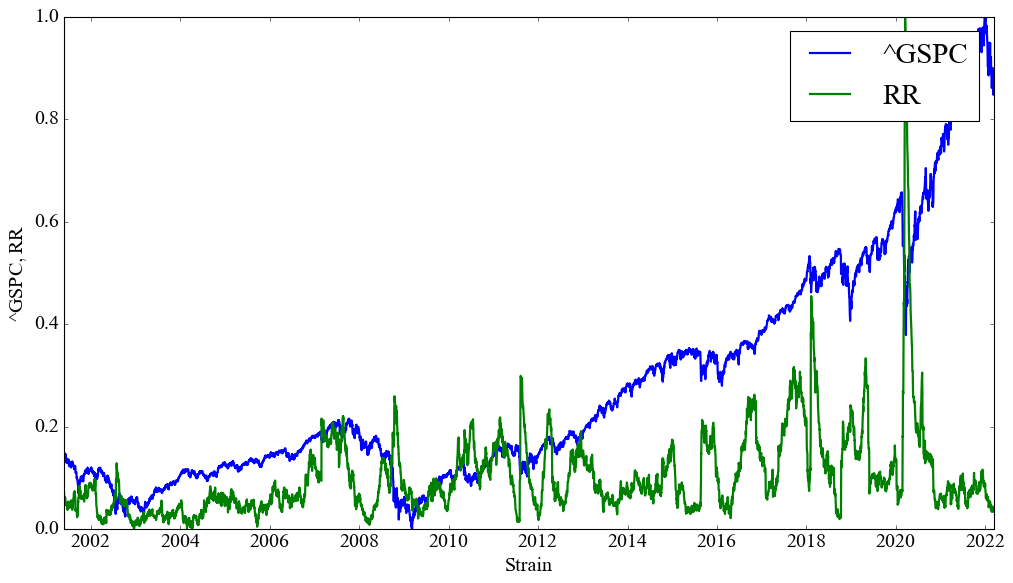

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_rr, label="RR")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "RR")

plt.savefig(path+f"JRQA_RR_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

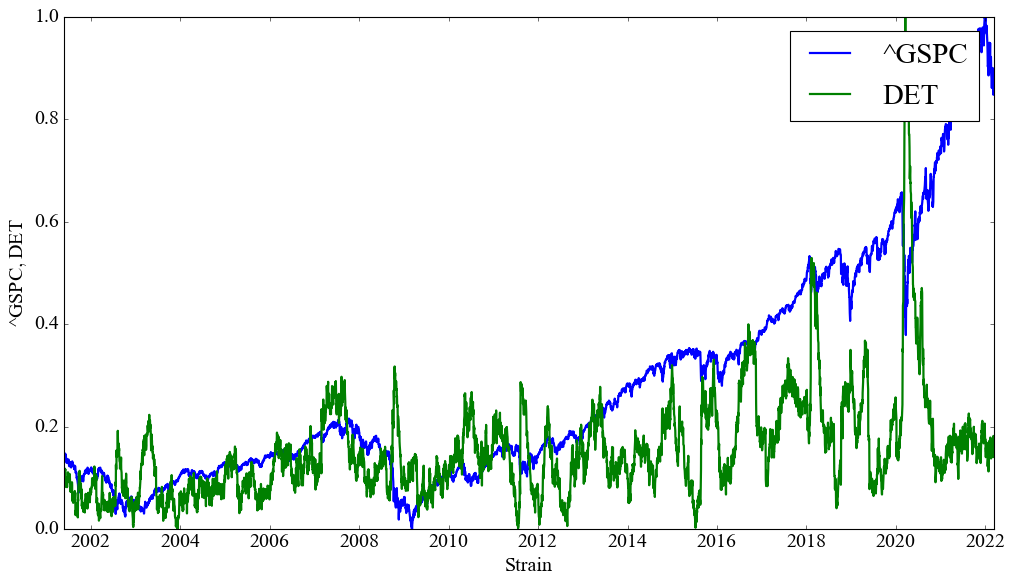

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_det, label="DET")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DET")

plt.savefig(path+f"JRQA_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

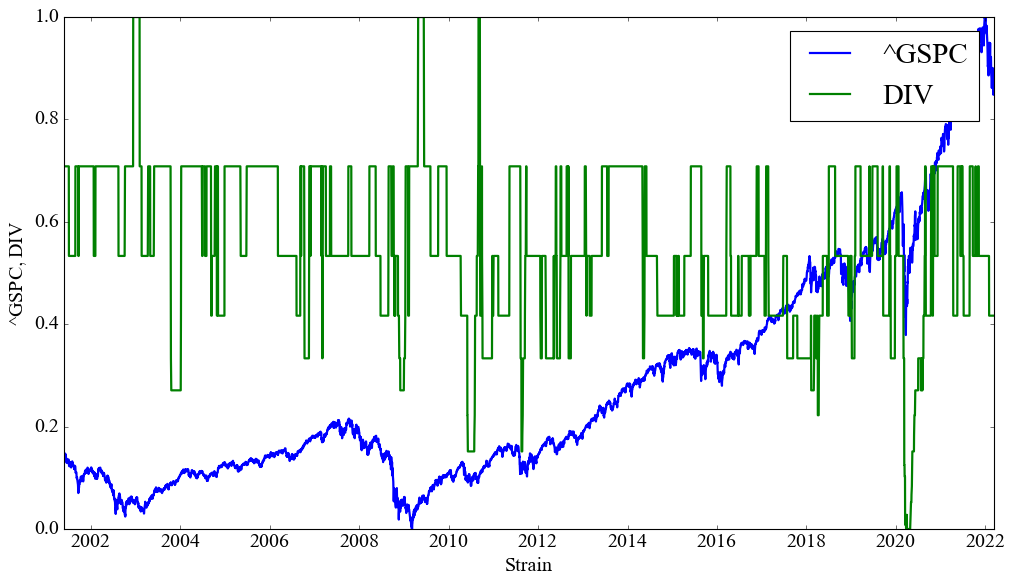

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_div, label="DIV")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DIV")

plt.savefig(path+f"JRQA_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

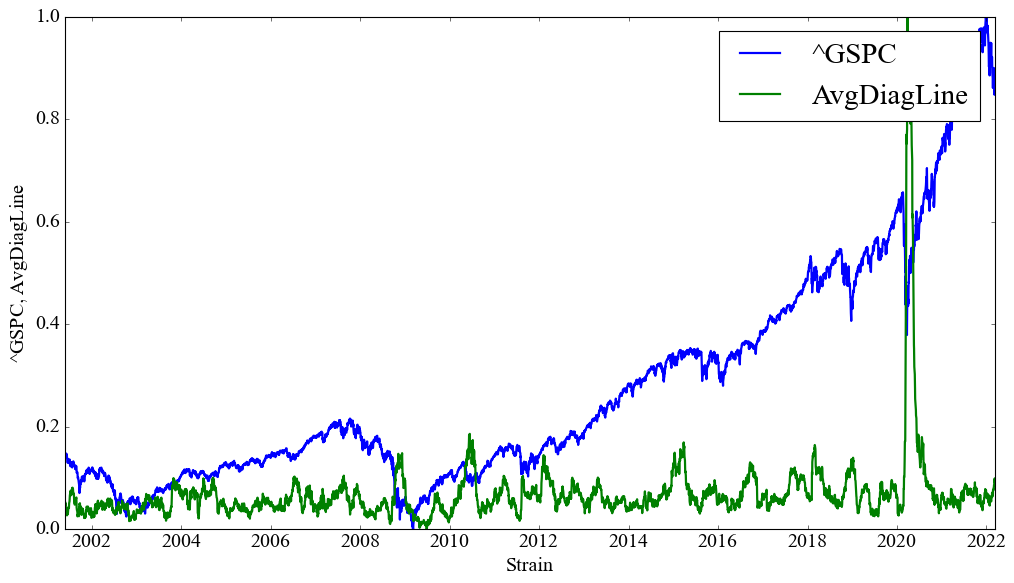

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_avg_diag_line, label="AvgDiagLine")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "AvgDiagLine")

plt.savefig(path+f"JRQA_AVG_DIAG_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

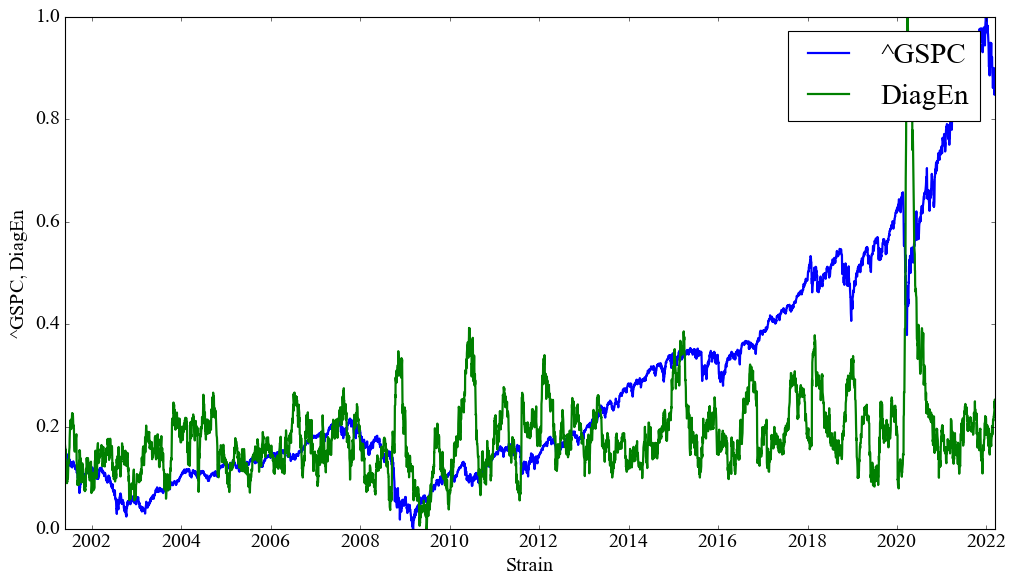

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ent_diag, label="DiagEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DiagEn")

plt.savefig(path+f"JRQA_ENT_DIAG_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

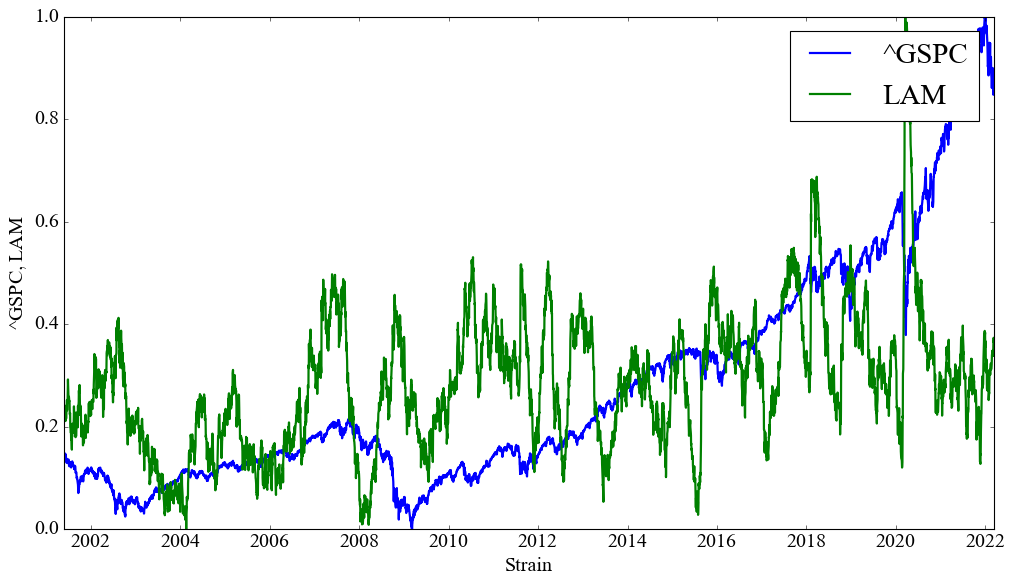

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_lam, label="LAM")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "LAM")

plt.savefig(path+f"JRQA_LAM_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

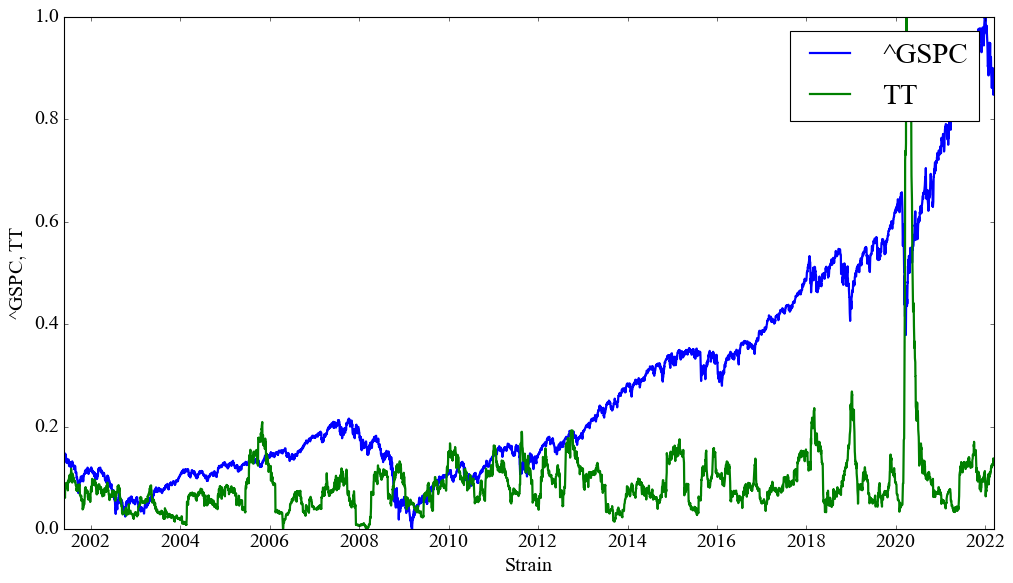

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_tt, label="TT")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "TT")

plt.savefig(path+f"JRQA_TRAPPING_TIME_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

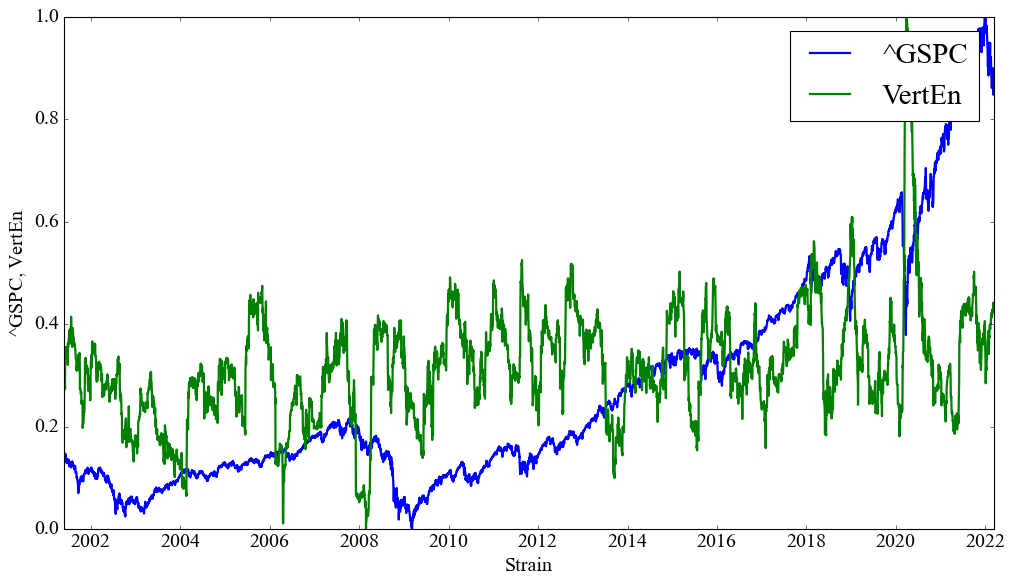

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ent_vert, label="VertEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "VertEn")

plt.savefig(path+f"JRQA_VERT_EN_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

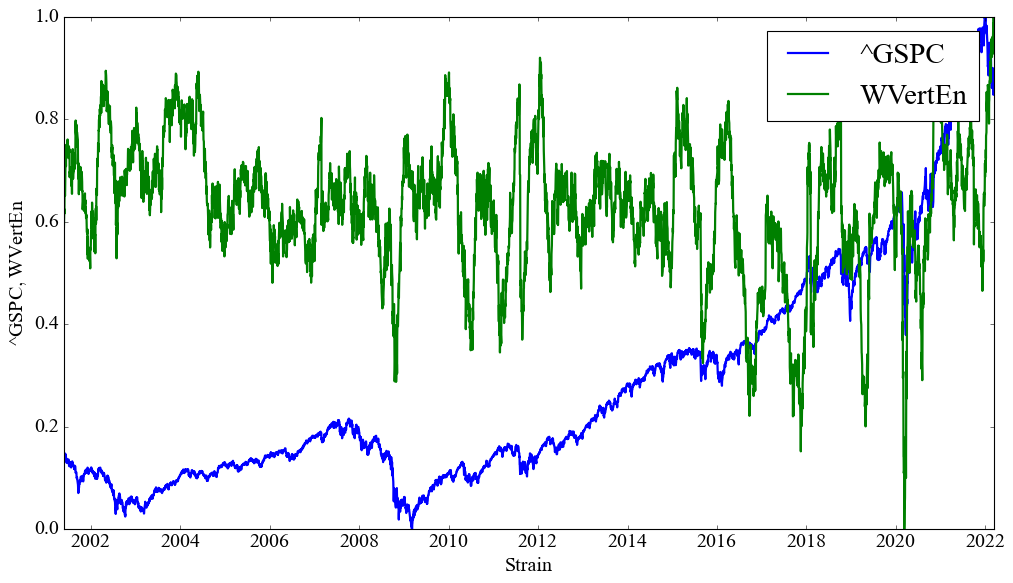

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ent_white_vert, label="WVertEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "WVertEn")

plt.savefig(path+f"JRQA_WHITE_VERT_LINE_ENT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

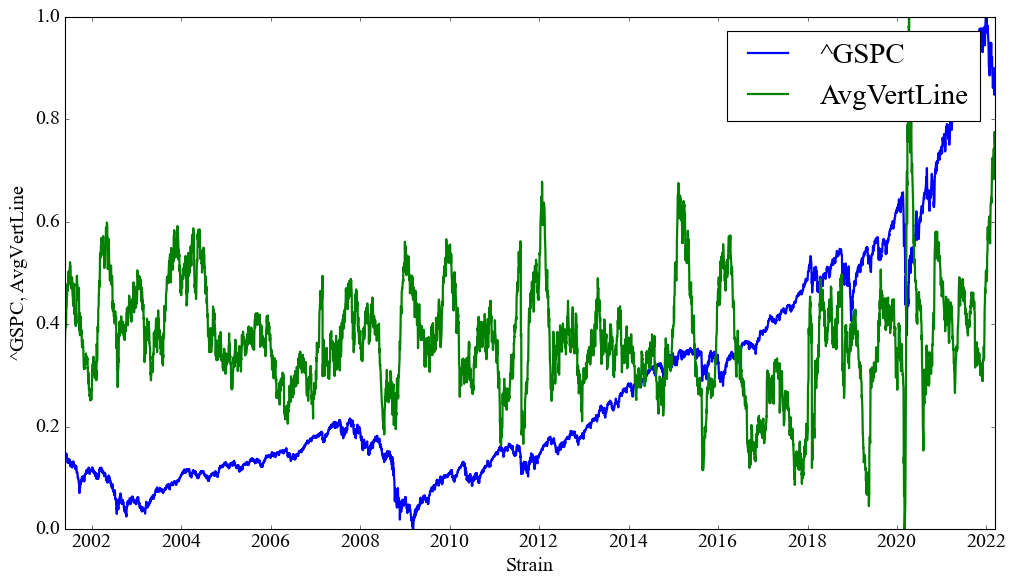

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_avg_vert_line, label="AvgVertLine")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "AvgVertLine")

plt.savefig(path+f"JRQA_AVG_VERT_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

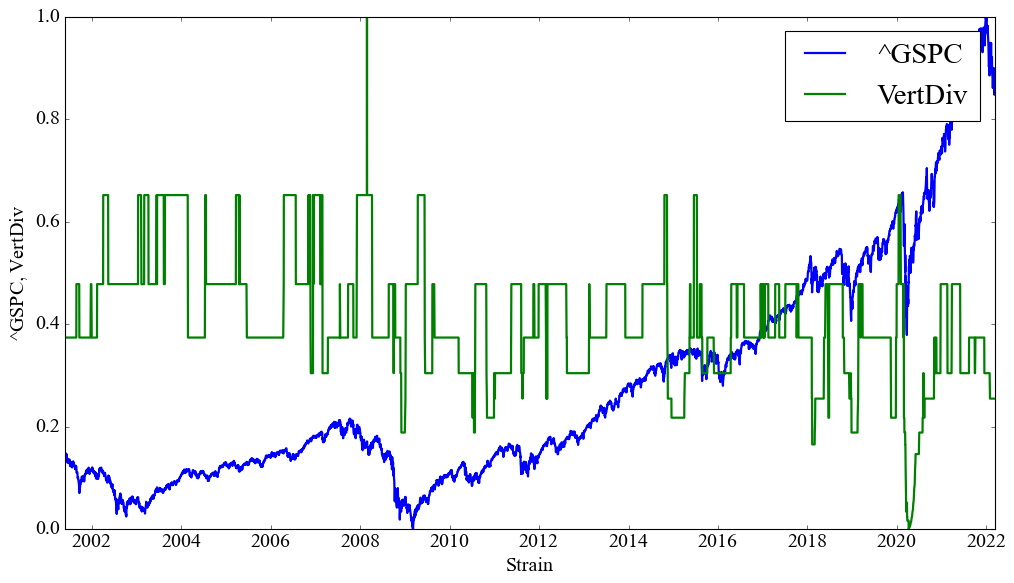

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_vert_div, label="VertDiv")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "VertDiv")

plt.savefig(path+f"JRQA_VERT_LINE_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

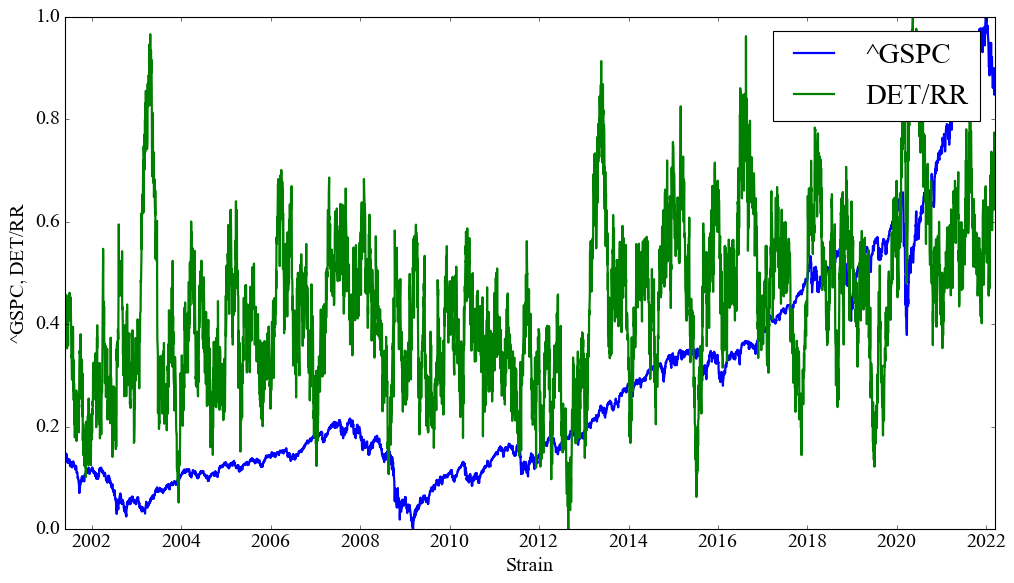

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ratio_det_rec, label="DET/RR")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DET/RR")

plt.savefig(path+f"JRQA_RATIO_DET_RR_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()

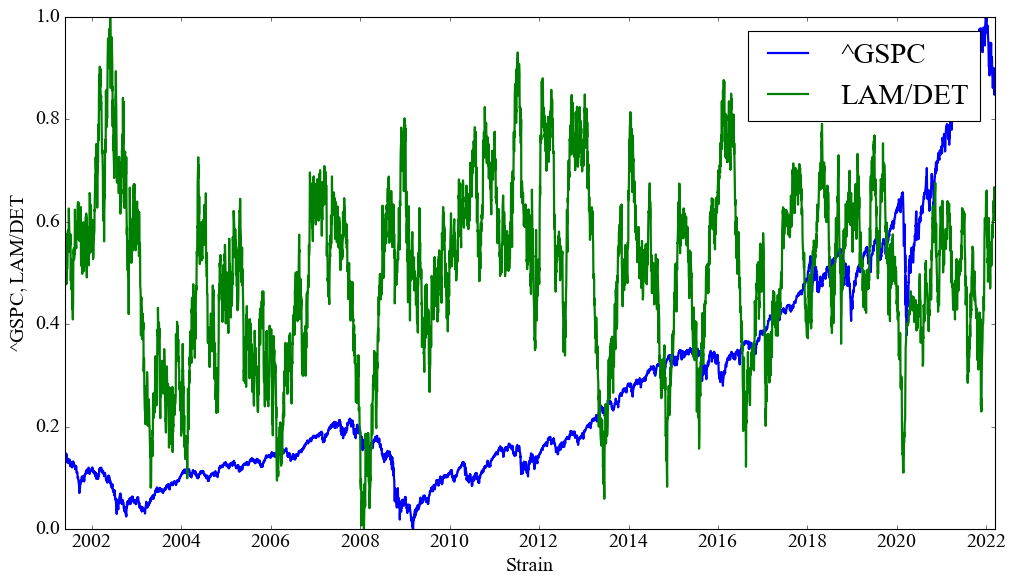

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ratio_lam_det, label="LAM/DET")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "LAM/DET")

plt.savefig(path+f"JRQA_RATIO_LAM_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps1={eps_1}_eps2={eps_2}_theilerwind1={theiler_wind_1}_theilerwind2={theiler_wind_2}.jpg", bbox_inches="tight")
plt.show()